# Evaluate the performance of our system


In this notebook we are evaluating the performance of the different models we were using to establish our project. In this regard we manually labeled 103 unique tracks in a excel file called groundTruth.xlsx in the groundTruth folder. This file contains enough information to fetch the log files created by the different models (YOLO/DeepSORT, MTCNN, FaceNet/KNN/SGD ...) of the labeled tracks. The log files will then be used to collect all the pictures taken by YOLO/DeepSORT (detecting and tracking people) or MTCNN (detecting and locating the faces) to merge all the information from the different modles together to easily follow the behaviour of the models within one HTML pandas dataframe. 

In [1]:
# import needed libraries
import pandas as pd
from datetime import datetime
import os
import matplotlib.pyplot as plt
import subprocess
import re
import itertools
from operator import itemgetter
from IPython.core.display import HTML
from helper_functions import *
from collections import Counter

# read in the manual curated datasets and assess the performance of the different tasks

we have created multiple csv files which we have manually labeled to evaluate the performance of a correctly ... 
+ detected person (cor_person)
+ tracked person (cor_tracking) 
+ reidentified person (cor_reident) 
+ detected & located face (cor_face)
+ identified area of interest (cor_area)
+ identified person (label)

For our evaluation we first need to read in all the created and manually labeled csv files

In [2]:
# path to the groundTruth folder
path = "groundTruth/"
# get all the paths to the files
files = [path + f for f in os.listdir(path) if re.match(".*\.csv", f)]
files = [f for f in files if f != "groundTruth/ground_truth.csv"]
df = pd.DataFrame(columns=["date", "time", "source", "frame_nr", "trackID", "KNN_prediction", "min_dist", 
                           "SGD_prediction", "max_prob", "label", "YOLO", "faces", "cor_person", "cor_tracking",
                           "cor_reident", "cor_face", "cor_area"])

for f in files:
    df2 = pd.read_csv(f, index_col=0)

    df = pd.concat([df, df2], ignore_index=True)

# df = df.sort_values(['date', 'time'], ascending=[True, True])
# Rendering the dataframe as HTML table
df.to_html(escape=False, formatters=dict(YOLO=path_to_image_html, faces=path_to_image_html)) #dict(YOLO=path_to_image_html, faces=path_to_image_html))
# Rendering the images in the dataframe using the HTML method.
HTML(df.to_html(escape=False,formatters=dict(YOLO=path_to_image_html, faces=path_to_image_html))) #dict(YOLO=path_to_image_html, faces=path_to_image_html)))


evaluation of the different models. 

In [3]:
y_counts = df.value_counts("cor_person")
yolo_acc = (1 - y_counts[0]/y_counts.sum()) * 100
tr_counts = df.value_counts("cor_tracking")
tracking_acc = (1 - tr_counts[0]/tr_counts.sum()) * 100
reident_counts = df.value_counts("cor_reident")
reident_acc = (1 - reident_counts[0]/reident_counts.sum()) * 100

test_df = df[df.isin(["Reidentified", "Found", "Lost", "Out"]).source == False].copy()
pos_pred_counts = test_df[test_df.faces.str.endswith(".png")].value_counts("cor_face")
neg_pred_counts = test_df[test_df.faces.str.endswith(".png")==False].value_counts("cor_face")
face_prec = pos_pred_counts[1]/pos_pred_counts.sum()
face_recall = pos_pred_counts[1]/(pos_pred_counts[1]+neg_pred_counts[0])
face_acc = (neg_pred_counts[1] + pos_pred_counts[1])/(neg_pred_counts.sum() +pos_pred_counts.sum())
face_f1 = 2* (face_prec*face_recall)/(face_prec+face_recall)

ar_counts = df.value_counts("cor_area")
ar_acc = (1 - ar_counts[0]/ar_counts.sum()) * 100
print(f"YOLO detection was observed (n={y_counts.sum()}) to have a precision of \033[1m{yolo_acc:.2f}%\033[0m ({y_counts[1]}/{y_counts.sum()})")
print(f"DeepSort tracking was observed (n={tr_counts.sum()}) to have a precision of \033[1m{tracking_acc:.2f}%\033[0m ({tr_counts[1]}/{tr_counts.sum()})")
print(f"DeepSorts reidentification was observed (n={reident_counts.sum()}) to have a precision of \033[1m{reident_acc:.2f}% \033[0m ({reident_counts[1]}/{reident_counts.sum()})")
print(f"MTCNN face detection was observed to have a precision of \033[1m{face_prec*100:.2f}% \033[0m ({pos_pred_counts[1]}/{pos_pred_counts.sum()}), recall of \033[1m{face_recall*100:.2f}% \033[0m ({pos_pred_counts[1]}/{pos_pred_counts[1]+neg_pred_counts[0]}), f1 of \033[1m{face_f1*100:.2f}% \033[0m and an accuracy \033[1m{face_acc*100:.2f}% \033[0m ({neg_pred_counts[1] + pos_pred_counts[1]}/{neg_pred_counts.sum() +pos_pred_counts.sum()})")
print(f"in and out of interest area detection was observed (n={ar_counts.sum()}) to have a precision of \033[1m{ar_acc:.2f}% \033[0m ({ar_counts[1]}/{ar_counts.sum()})")

YOLO detection was observed (n=2966) to have a precision of 93.93% (2786/2966)
DeepSort tracking was observed (n=103) to have a precision of 90.29% (93/103)
DeepSorts reidentification was observed (n=70) to have a precision of 47.14%  (33/70)
MTCNN face detection was observed to have a precision of 92.37%  (557/603), recall of 85.17%  (557/654), f1 of 88.62%  and an accuracy 89.58%  (1229/1372)
in and out of interest area detection was observed (n=102) to have a precision of 99.02%  (101/102)


Next we have evaluated the FaceRecognition models (KNN and SGD) used directly on our live streams for the last ~2 weeks.

+ True positive prediction (face is truly unknown) = 1
+ True negative prediction (face is truly known) = -1
+ False postive prediction (face is wrongly unknown) = 2
+ False negative predicion (face is wrongly known) = 0

we have to clean up the dataframe a bit. first we replace the predictions by KNN that have no minimal distance as "unknown" (thats how we have created the log files). Next we need to replace a typo we have created unkown. We are going to remove one track that is a very special case and needs to be removed for the evaluation. We are only considering the frames on which our a face was detected

In [4]:

path = "groundTruth/"
files = [path + f for f in os.listdir(path) if re.match("\d+.*\.csv", f)]

df = pd.DataFrame(columns=["date", "time", "source", "frame_nr", "trackID", "KNN_prediction", "min_dist", 
                           "SGD_prediction", "max_prob", "label", "YOLO", "faces", "cor_person", "cor_tracking",
                           "cor_reident", "cor_face", "cor_area", "cor_KNN", "cor_SGD"])
KNN = []
SGD = []
rand = []
unknown_KNN = []
unknown_SGD = []

for f in files:
    df2 = pd.read_csv(f, index_col=0)
    df2.loc[df2.min_dist.isnull(),"KNN_prediction"] = "unknown"
    df2.loc[df2.SGD_prediction.isnull(),"SGD_prediction"] = "unknown"
    df2.loc[df2.label == "unkown", "label"] = "unknown"
    df2 = df2[df2.label != "Sandro_Kyla"]
    n = sum(df2.isin(["Found", "Reidentified"]).source)

    df2 = df2[df2.isin(["Found", "Lost", "Reidentified", "Out"]).source == False]
    df2.KNN_prediction = df2.KNN_prediction.str.split("_").dropna().apply(lambda x: x[0])
    df2.SGD_prediction = df2.SGD_prediction.str.split("_").dropna().apply(lambda x: x[0])
    
    FaceRec = df2[(df2.faces.str.endswith(".png")) & (df2.cor_face == 1)]
    
    if FaceRec.empty == False:
        
        k= sum(FaceRec.KNN_prediction == FaceRec.label.iloc[0])
        s= sum(FaceRec.SGD_prediction == FaceRec.label.iloc[0])
        un_KNN = FaceRec.value_counts("KNN_prediction")
        un_SGD = FaceRec.value_counts("SGD_prediction")
        
#         if "unknown" == FaceRec.label.iloc[0]:
#             print("uknown")
        
        if "unknown" in un_KNN.index:
            unKNN= un_KNN["unknown"]
        else:
            unKNN = 0
        
        if "unknown" in un_SGD.index:
            unSGD= un_SGD["unknown"]
        else:
            unSGD = 0
            
        if ((unKNN >= sum(un_KNN)-unKNN) & (FaceRec.iloc[0].label == "unknown")):
            unknown_KNN += [1]*n
        elif((unKNN < sum(un_KNN)-unKNN) & (FaceRec.iloc[0].label != "unknown")):
            unknown_KNN += [-1]*n
        elif ((unKNN >= sum(un_KNN)-unKNN) & (FaceRec.iloc[0].label != "unknown")):
            unknown_KNN += [2]*n
        else:
#             print(un_KNN)
            unknown_KNN += [0]*n
            
        if ((unSGD >= sum(un_SGD)-unSGD) & (FaceRec.iloc[0].label == "unknown")):
            unknown_SGD += [1]*n
        elif((unSGD < sum(un_SGD)-unSGD) & (FaceRec.iloc[0].label != "unknown")):
            unknown_SGD += [-1]*n
        elif ((unSGD >= sum(un_SGD)-unSGD) & (FaceRec.iloc[0].label != "unknown")):
            unknown_SGD += [2]*n
        else:
            unknown_SGD += [0]*n
            

        if k > 0:
            KNN += [1]*n
        else:
            KNN += [0]*n

        if s > 0:
            SGD += [1]*n
        else:
            SGD  += [0]*n

FP_KNN, TN_KNN, TP_KNN, FN_KNN = [Counter(unknown_KNN)[k] if k in Counter(unknown_KNN).keys() else 0 for k in [2, -1, 1, 0]]
FP_SGD, TN_SGD, TP_SGD, FN_SGD = [Counter(unknown_SGD)[k] if k in Counter(unknown_SGD).keys() else 0 for k in [2, -1, 1, 0]]


In [5]:
print(f"KNN predicting unknown class:\nPrecision: {(TP_KNN/(TP_KNN+FP_KNN))*100:.2f}%\nRecall: {(TP_KNN/(TP_KNN+FN_KNN))*100:.2f}%\nF1 score: {2*(((TP_KNN/(TP_KNN+FP_KNN))*(TP_KNN/(TP_KNN+FN_KNN)))/((TP_KNN/(TP_KNN+FP_KNN))+((TP_KNN)/(TP_KNN+FN_KNN))))*100:.2f}%\nAccuracy:{((TP_KNN+TN_KNN)/(TN_KNN+TP_KNN+FP_KNN))*100:.2f}%")

KNN predicting unknown class:
Precision: 4.00%
Recall: 100.00%
F1 score: 7.69%
Accuracy:50.00%


In [6]:
print(f"SGD predicting unknown class:\nPrecision: {(TP_SGD/(TP_SGD+FP_SGD))*100:.2f}%\nRecall: {(TP_SGD/(TP_SGD+FN_SGD))*100:.2f}%\nF1 score: {2*(((TP_SGD/(TP_SGD+FP_SGD))*(TP_SGD/(TP_SGD+FN_SGD)))/((TP_SGD/(TP_SGD+FP_SGD))+((TP_SGD)/(TP_SGD+FN_SGD))))*100:.2f}%\nAccuracy:{((TP_SGD+TN_SGD)/(TN_SGD+TP_SGD+FP_SGD))*100:.2f}%")

SGD predicting unknown class:
Precision: 2.94%
Recall: 100.00%
F1 score: 5.71%
Accuracy:31.25%


Next we are going to evaluate the models on our reference database. For this we are going to train the models on 80% of the reference database classes 67/84 and test it on the remaining 20% reference classes and mix it with a small portion of known unseen faces.

For this purpose we have created some helper functions

In [7]:
# load in needed modules
import json
import numpy as np
from itertools import chain
from collections import Counter
from random import sample
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier


In [8]:
# some other helper functions
def rep(x):
    return [x[0]] * x[1]

def load_database(database="/mnt/golem/frodo/clusteredFaces_lower_resolution/final_low_resoloution_FaceDB.json"):

    db = json.loads(open(database).read())
    res = list(db.keys())
    
    db2 = {res[0]: {k: np.vstack(v["encodings"]) for k,v in db[res[0]].items()}}
    len_db = {res[0]: list(map(len, list(db2[res[0]].values())))}
    nest = {res[0]: list(map(rep, zip(list(db2[res[0]].keys()), len_db[res[0]])))}
    names = {res[0]: list(chain(*nest[res[0]]))}

    for r in res[1:]:
        db2.update({r: {k: np.vstack(v["encodings"]) for k,v in db[r].items()}})
        len_db.update({r: list(map(len, list(db2[r].values())))})
        nest.update({r: list(map(rep, zip(list(db2[r].keys()), len_db[r])))})
        names.update({r: list(chain(*nest[r]))})
    
    arr = {k: (np.vstack(list(v.values())), names[k]) for k,v in db2.items()}
    
    return arr



def split_data(arr, resolution="64", proportion_class=80, exclude_class ="Maureen_Leber", proportion_known = 0.05,
              seed=42):
    # How many classes result in 80% of all classes
    random.seed(seed)
    X_tot,y_tot = arr[resolution]
#     print(X_tot.shape, len(y_tot))
    thr = int(proportion_class * len(Counter(y_tot)) /100)

    X_train = np.zeros(128)
    X_test = np.zeros(128)
    y_train = []
    y_test = []

    n = 1
    freq_classes = dict(Counter(y_tot))
    tr = sample(freq_classes.keys(),thr)
    te = list(set(y_tot)-set(tr))
    for c,v in freq_classes.items():    
        ind = y_tot.index(c)
        if c == exclude_class:
            continue
        elif c in tr:
            y_train += y_tot[ind:ind+v]
            X_train = np.vstack((X_train, X_tot[ind:ind+v,:]))
        elif c in te:
            y_test += y_tot[ind:ind+v]
            X_test = np.vstack((X_test, X_tot[ind:ind+v,:]))

    X_train = np.delete(X_train, (0), axis=0)
    X_test = np.delete(X_test, (0), axis=0)
#     print(X_train.shape, len(y_train), X_test.shape, len(y_test))

    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_train, y_train, test_size=proportion_known, random_state=42)

    X_test = np.vstack((X_test, X_sub_test))
    y_test += y_sub_test
#     print(X_train.shape, len(y_train), X_test.shape, len(y_test))
    return X_train, y_train, X_test, y_test, y_sub_test

def performance(pred, pr=False):
    act_pos = Counter(elem[0] for elem in pred if (elem[0] != elem[3]) & (elem[2] == "unknown"))
    TP = act_pos["unknown"]
    FN = sum(act_pos.values())-TP
#     print(TP, FN)
    act_neg = Counter(elem[0] for elem in pred if (elem[2] == "known"))
    FP = act_neg["unknown"]
    TN = sum(act_neg.values())-FP
#     print(FP, TN)
    try:
        precision = TP / (TP+FP)
    except Exception as e:
        print(e)
        precision = 0
    try:
        recall = TP / (TP+FN)
    except Exception as e:
        print(e)
        recall = 0
    try:
        accuracy = (TP+TN) / (TP+TN+FP+FN)
    except Exception as e:
        print(e)
        accuracy = 0
    try:
        f1 = 2* (precision*recall)/(precision+recall)
    except Exception as e:
        print(e)
        f1 = 0
    if pr:
        new_line = os.linesep
        print(f"precision: {precision:.2f}{new_line}recall: {recall:.2f}{new_line}accuracy: {accuracy:.2f}{new_line}f1: {f1:.2f}")
    return {"precision": precision, "recall": recall, "accuracy": accuracy, "f1": f1}

def clf_predict(X_test,y_test,y_sub_test, clf = ["knn", "euclidean", "random", "sgd"]):
    pred_thr = {}
    loop = np.linspace(start=0, stop=1, num=17)[np.arange(0,17,2)].tolist()
    

    knn = KNeighborsClassifier(weights="distance", n_neighbors=3)
    knn.fit(X_train, y_train)
    min_dist_ecl = 100
    
    SGD = SGDClassifier(max_iter=1000, alpha=0.01, class_weight = "balanced", loss='modified_huber' )
    SGD.fit(X_train, y_train)

    for r,label in zip(X_test, y_test):    
        if label in y_sub_test:
            mode = "known"
        else:
            mode = "unknown"

        ident_knn, dist_knn, status = knn.predict(r.reshape(1,128))
        orig_ident_knn = ident_knn.copy()
        n,w = dist_knn[0]
        dist_knn = list(zip(n,w))
        dist_ind = [x for x, y in enumerate(dist_knn) if y[0] ==  ident_knn]

        min_dist_knn = 1/np.array(dist_knn)[dist_ind][:,1].astype(float).mean()
        
        for thr in tqdm(loop):
            if thr == 0.0:
                thr = 1/100000
                
            if min_dist_knn < 1/thr:
                ident_knn = "unknown"
            else:
                ident_knn = orig_ident_knn[0]
            if "knn" in pred_thr.keys():
                if thr in pred_thr["knn"].keys():
                    pred_thr["knn"][thr] +=  [(ident_knn, min_dist_knn, mode, label)]
                else:
                    pred_thr["knn"][thr] =  [(ident_knn, min_dist_knn, mode, label)]                    
            else:
                pred_thr["knn"] = {thr: [(ident_knn, min_dist_knn, mode, label)]}
                
            if "euclidean" in clf:
                dist_ecl = np.apply_along_axis(np.linalg.norm, 1, (X_train - r.reshape(1,128)))
                ind = np.argmin(dist_ecl)
                if dist_ecl[ind] < min_dist_ecl:
                    min_dist_ecl = dist_ecl[ind]
                    ident_ecl = y_train[ind]
                if min_dist_ecl < thr:
                    ident_ecl = "unknown"
                else:
                    ident_ecl = ident_ecl
                if "ecl" in pred_thr.keys():
                    if thr in pred_thr["ecl"].keys():                    
                        pred_thr["ecl"][thr] +=  [(ident_ecl, min_dist_ecl, mode, label)]
                    else:
                        pred_thr["ecl"][thr] =  [(ident_ecl, min_dist_ecl, mode, label)]
                else:
                    pred_thr["ecl"] = {thr: [(ident_ecl, min_dist_ecl, mode, label)]}
                    
                min_dist_ecl = 100
                    
            if "sgd" in clf:        
                proba = SGD.predict_proba(r.reshape(1,128))         

                #thr = 1/len(proba[0,:])*10
#                 print(proba, thr)

                ind = np.where(proba>=thr)

                if ind[1] != []:
                    ix = np.argmax(proba[0,:])
                    ident_sgd = SGD.classes_[ix]
                    min_dist_sgd = proba[0,ix]
                else:
                    ident_sgd = "unknown"
                    min_dist_sgd = 0

                if "sgd" in pred_thr.keys():
                    if thr in pred_thr["sgd"].keys():                    
                        pred_thr["sgd"][thr] +=  [(ident_sgd, min_dist_sgd, mode, label)]
                    else:
                        pred_thr["sgd"][thr] =  [(ident_sgd, min_dist_sgd, mode, label)]
                else:
                    pred_thr["sgd"] = {thr: [(ident_sgd, min_dist_sgd, mode, label)]}
                    
                    
            if "random" in clf:        
                proba_rand = np.array([random.uniform(0, 1) for i in range(len(y_test))])
#                 ident_rand = sample(list(set(y_test)), 1) 
#                 print(proba_rand)
                ind = np.where(proba_rand>=thr)
#                 print(ind)
                if ind != []:
                    ix = np.argmax(proba_rand)
                    ident_rand = list(y_test)[ix]
                    min_dist_rand = proba_rand[ix]
                else:
                    ident_rand = "unknown"
                    min_dist_rand = proba_rand[ix]

                if "rand" in pred_thr.keys():
                    if thr in pred_thr["rand"].keys():                    
                        pred_thr["rand"][thr] +=  [(ident_rand, min_dist_rand, mode, label)]
                    else:
                        pred_thr["rand"][thr] =  [(ident_rand, min_dist_rand, mode, label)]
                else:
                    pred_thr["rand"] = {thr: [(ident_rand, min_dist_rand, mode, label)]}
                
                    
    return pred_thr



if you have no access to the data or you want to save some time - just load in the precomuted evaluation in the next cell and continue with the next steps

In [9]:
# load the encodings of the whole database 64x64 pixels
arr = load_database() 
# split the data into train and test dataset
X_train, y_train, X_test, y_test, y_sub_test = split_data(arr, proportion_known=0.05, seed=42)
# make the predictions for the mentioned models
pred =  clf_predict(X_test,y_test,y_sub_test, clf = ["knn", "euclidean", "sgd", "random"]) 

[['Jaqueline_Odermatt' 'Jaqueline_Odermatt' 'Jaqueline_Odermatt']]
[[1.2084875  1.2084875  1.06227362]]
[4.89986825 4.89986825 4.89986825]
[[5.92142955 5.92142955 5.20500076]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.28it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Melanie_Leber' 'Pino_Bruno' 'Melanie_Leber']]
[[1.19795481 1.17630113 1.1590933 ]]
[1.81769306 4.89986825 1.81769306]
[[2.17751414 5.76372055 2.10687584]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.40it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jaqueline_Odermatt' 'Jaqueline_Odermatt' 'Jaqueline_Odermatt']]
[[1.165881   1.165881   1.11958232]]
[4.89986825 4.89986825 4.89986825]
[[5.71266328 5.71266328 5.48580584]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.75it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Melanie_Leber' 'Jaqueline_Odermatt' 'Jaqueline_Odermatt']]
[[1.21163534 1.19478674 1.19478674]]
[1.81769306 4.89986825 4.89986825]
[[2.20238116 5.85429762 5.85429762]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.49it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jaqueline_Odermatt' 'Jaqueline_Odermatt' 'Sandro_Bruno']]
[[1.20342895 1.20342895 1.13748593]]
[4.89986825 4.89986825 0.06148225]
[[5.89664328 5.89664328 0.0699352 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.08it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Melanie_Leber' 'Melanie_Leber' 'Pino_Bruno']]
[[1.36389667 1.19622246 1.18302203]]
[1.81769306 1.81769306 4.89986825]
[[2.47914551 2.17436526 5.7966521 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.45it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jaqueline_Odermatt' 'Jaqueline_Odermatt' 'Melanie_Leber']]
[[1.16819743 1.16819743 1.15770222]]
[4.89986825 4.89986825 1.81769306]
[[5.72401349 5.72401349 2.10434729]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.77it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jaqueline_Odermatt' 'Jaqueline_Odermatt' 'Sandro_Bruno']]
[[1.2177588 1.2177588 1.2125311]]
[4.89986825 4.89986825 0.06148225]
[[5.96685768 5.96685768 0.07454914]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.92it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jaqueline_Odermatt' 'Jaqueline_Odermatt' 'Sandro_Bruno']]
[[1.17423403 1.17423403 1.16806767]]
[4.89986825 4.89986825 0.06148225]
[[5.75359202 5.75359202 0.07181543]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.24it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.27517577 1.27517577 1.20014152]]
[0.06148225 0.06148225 0.06148225]
[[0.07840068 0.07840068 0.0737874 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.42it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jaqueline_Odermatt' 'Jaqueline_Odermatt' 'Jaqueline_Odermatt']]
[[1.2084875  1.2084875  1.06227362]]
[4.89986825 4.89986825 4.89986825]
[[5.92142955 5.92142955 5.20500076]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.54it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Melanie_Leber' 'Pino_Bruno' 'Melanie_Leber']]
[[1.19795481 1.17630113 1.1590933 ]]
[1.81769306 4.89986825 1.81769306]
[[2.17751414 5.76372055 2.10687584]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.13it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jaqueline_Odermatt' 'Jaqueline_Odermatt' 'Jaqueline_Odermatt']]
[[1.165881   1.165881   1.11958232]]
[4.89986825 4.89986825 4.89986825]
[[5.71266328 5.71266328 5.48580584]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.23it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Melanie_Leber' 'Jaqueline_Odermatt' 'Jaqueline_Odermatt']]
[[1.21163534 1.19478674 1.19478674]]
[1.81769306 4.89986825 4.89986825]
[[2.20238116 5.85429762 5.85429762]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.49it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jaqueline_Odermatt' 'Jaqueline_Odermatt' 'Sandro_Bruno']]
[[1.20342895 1.20342895 1.13748593]]
[4.89986825 4.89986825 0.06148225]
[[5.89664328 5.89664328 0.0699352 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.50it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Melanie_Leber' 'Melanie_Leber' 'Pino_Bruno']]
[[1.36389667 1.19622246 1.18302203]]
[1.81769306 1.81769306 4.89986825]
[[2.47914551 2.17436526 5.7966521 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.44it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jaqueline_Odermatt' 'Jaqueline_Odermatt' 'Melanie_Leber']]
[[1.16819743 1.16819743 1.15770222]]
[4.89986825 4.89986825 1.81769306]
[[5.72401349 5.72401349 2.10434729]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.52it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jaqueline_Odermatt' 'Jaqueline_Odermatt' 'Sandro_Bruno']]
[[1.2177588 1.2177588 1.2125311]]
[4.89986825 4.89986825 0.06148225]
[[5.96685768 5.96685768 0.07454914]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.93it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jaqueline_Odermatt' 'Jaqueline_Odermatt' 'Sandro_Bruno']]
[[1.17423403 1.17423403 1.16806767]]
[4.89986825 4.89986825 0.06148225]
[[5.75359202 5.75359202 0.07181543]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.75it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.27517577 1.27517577 1.20014152]]
[0.06148225 0.06148225 0.06148225]
[[0.07840068 0.07840068 0.0737874 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.24it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jürgen_Schäck' 'Jürgen_Schäck' 'Thomas_Tröndlin']]
[[1.06345176 1.06345176 1.06009506]]
[0.71327196 0.71327196 7.04356061]
[[0.75853032 0.75853032 7.46684381]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.03it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.09101866 1.09101866 1.08430006]]
[3.5217803 3.5217803 3.5217803]
[[3.84232802 3.84232802 3.81866658]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.84it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.14151897 1.14151897 1.13733587]]
[3.5217803 3.5217803 3.5217803]
[[4.02017901 4.02017901 4.00544706]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.01it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.14395473 1.14395473 1.14099028]]
[3.5217803 3.5217803 3.5217803]
[[4.02875725 4.02875725 4.01831709]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.02it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.16645652 1.16645652 1.16075661]]
[3.5217803 3.5217803 3.5217803]
[[4.10800358 4.10800358 4.08792978]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.77it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.16209781 1.16209781 1.15066088]]
[3.5217803 3.5217803 3.5217803]
[[4.09265319 4.09265319 4.05237484]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.19it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.14058152 1.14058152 1.11677557]]
[3.5217803 3.5217803 3.5217803]
[[4.01687754 4.01687754 3.93303821]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.56it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.21025441 1.21025441 1.20296061]]
[3.5217803 3.5217803 3.5217803]
[[4.26225016 4.26225016 4.23656298]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.23519328 1.23519328 1.21985839]]
[3.5217803 3.5217803 3.5217803]
[[4.35007936 4.35007936 4.29607325]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.77it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.16584379 1.16584379 1.13315189]]
[3.5217803 3.5217803 3.5217803]
[[4.10584568 4.10584568 3.99071202]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.83it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.09101866 1.09101866 1.08430006]]
[3.5217803 3.5217803 3.5217803]
[[3.84232802 3.84232802 3.81866658]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.19it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.14151897 1.14151897 1.13733587]]
[3.5217803 3.5217803 3.5217803]
[[4.02017901 4.02017901 4.00544706]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.38it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.14395473 1.14395473 1.14099028]]
[3.5217803 3.5217803 3.5217803]
[[4.02875725 4.02875725 4.01831709]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.77it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.16645652 1.16645652 1.16075661]]
[3.5217803 3.5217803 3.5217803]
[[4.10800358 4.10800358 4.08792978]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.80it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.16209781 1.16209781 1.15066088]]
[3.5217803 3.5217803 3.5217803]
[[4.09265319 4.09265319 4.05237484]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.17it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.14058152 1.14058152 1.11677557]]
[3.5217803 3.5217803 3.5217803]
[[4.01687754 4.01687754 3.93303821]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.29it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.21025441 1.21025441 1.20296061]]
[3.5217803 3.5217803 3.5217803]
[[4.26225016 4.26225016 4.23656298]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.61it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.23519328 1.23519328 1.21985839]]
[3.5217803 3.5217803 3.5217803]
[[4.35007936 4.35007936 4.29607325]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.30it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.16584379 1.16584379 1.13315189]]
[3.5217803 3.5217803 3.5217803]
[[4.10584568 4.10584568 3.99071202]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.52it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Philipp' 'Philipp' 'Philipp']]
[[1.02226255 1.02226255 1.01003896]]
[4.02489177 4.02489177 4.02489177]
[[4.11449612 4.11449612 4.06529752]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.63it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.04890673 1.04652356 1.04652356]]
[0.06148225 0.06148225 0.06148225]
[[0.06448915 0.06434263 0.06434263]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.17it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Benjamin_Haas' 'Benjamin_Haas' 'Benjamin_Haas']]
[[1.0079824 1.0079824 1.0079824]]
[3.75656566 3.75656566 3.75656566]
[[3.78655206 3.78655206 3.78655206]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.41it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.07968621 1.07968621 1.07968621]]
[0.06148225 0.06148225 0.06148225]
[[0.06638154 0.06638154 0.06638154]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.00it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.13852725 1.09771067 1.09771067]]
[0.06148225 0.06148225 0.06148225]
[[0.06999922 0.06748973 0.06748973]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.75it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Philipp' 'Philipp' 'Philipp']]
[[1.00002233 1.00002233 0.99859491]]
[4.02489177 4.02489177 4.02489177]
[[4.02498166 4.02498166 4.01923645]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.25it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.01711374 1.00775715 1.00775715]]
[0.04431654 0.06148225 0.06148225]
[[0.04507496 0.06195918 0.06195918]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.13it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1.0400153  1.02098469 1.01796273]]
[0.06148225 0.04431654 0.04431654]
[[0.06394248 0.04524651 0.04511259]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.66it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.13169116 1.08167464 1.06705057]]
[0.44899191 0.44899191 0.44899191]
[[0.50812018 0.48566316 0.47909707]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.71it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1.00329562 0.99564461 0.99378732]]
[0.06148225 0.04431654 0.04431654]
[[0.06168488 0.04412353 0.04404122]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.20it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Sandro_Bruno']]
[[1.0245883  1.00964688 1.00856623]]
[0.04431654 0.04431654 0.06148225]
[[0.04540621 0.04474406 0.06200892]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.56it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Philipp' 'Philipp' 'Philipp']]
[[1.03434089 1.03434089 1.02090823]]
[4.02489177 4.02489177 4.02489177]
[[4.16311012 4.16311012 4.10904514]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.51it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[0.99560054 0.98684878 0.98684878]]
[0.06148225 0.06148225 0.06148225]
[[0.06121176 0.06067369 0.06067369]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.76it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.09533615 1.06047332 1.06047332]]
[0.06148225 0.06148225 0.06148225]
[[0.06734373 0.06520029 0.06520029]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.52it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.02385081 1.00965247 1.00965247]]
[0.06148225 0.06148225 0.06148225]
[[0.06294865 0.06207571 0.06207571]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.88it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.0165493  1.0165493  1.00604945]]
[0.06148225 0.06148225 0.06148225]
[[0.06249974 0.06249974 0.06185419]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.91it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.14698773 1.11223581 1.11223581]]
[0.06148225 0.06148225 0.06148225]
[[0.07051939 0.06838276 0.06838276]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.00it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.07968621 1.07968621 1.07968621]]
[0.06148225 0.06148225 0.06148225]
[[0.06638154 0.06638154 0.06638154]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.82it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.13852725 1.09771067 1.09771067]]
[0.06148225 0.06148225 0.06148225]
[[0.06999922 0.06748973 0.06748973]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.00it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Philipp' 'Philipp' 'Philipp']]
[[1.00002233 1.00002233 0.99859491]]
[4.02489177 4.02489177 4.02489177]
[[4.02498166 4.02498166 4.01923645]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.82it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.01711374 1.00775715 1.00775715]]
[0.04431654 0.06148225 0.06148225]
[[0.04507496 0.06195918 0.06195918]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.64it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1.0400153  1.02098469 1.01796273]]
[0.06148225 0.04431654 0.04431654]
[[0.06394248 0.04524651 0.04511259]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.41it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.13169116 1.08167464 1.06705057]]
[0.44899191 0.44899191 0.44899191]
[[0.50812018 0.48566316 0.47909707]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.82it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1.00329562 0.99564461 0.99378732]]
[0.06148225 0.04431654 0.04431654]
[[0.06168488 0.04412353 0.04404122]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.09it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Sandro_Bruno']]
[[1.0245883  1.00964688 1.00856623]]
[0.04431654 0.04431654 0.06148225]
[[0.04540621 0.04474406 0.06200892]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.54it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Philipp' 'Philipp' 'Philipp']]
[[1.03434089 1.03434089 1.02090823]]
[4.02489177 4.02489177 4.02489177]
[[4.16311012 4.16311012 4.10904514]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.62it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[0.99560054 0.98684878 0.98684878]]
[0.06148225 0.06148225 0.06148225]
[[0.06121176 0.06067369 0.06067369]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.09533615 1.06047332 1.06047332]]
[0.06148225 0.06148225 0.06148225]
[[0.06734373 0.06520029 0.06520029]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.41it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.02385081 1.00965247 1.00965247]]
[0.06148225 0.06148225 0.06148225]
[[0.06294865 0.06207571 0.06207571]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.29it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.0165493  1.0165493  1.00604945]]
[0.06148225 0.06148225 0.06148225]
[[0.06249974 0.06249974 0.06185419]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.95it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Martin']]
[[1.23449746 1.23449746 1.20720024]]
[4.17396184 4.17396184 4.17396184]
[[5.1527453  5.1527453  5.03880775]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.67it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.10957722 1.10957722 1.09932268]]
[0.06148225 0.06148225 0.06148225]
[[0.06821931 0.06821931 0.06758883]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.98it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Stefan_Leber']]
[[1.16544477 1.16544477 1.14788564]]
[4.17396184 4.17396184 0.44899191]
[[4.86452198 4.86452198 0.51539137]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anja_Odermatt' 'Anja_Odermatt' 'Sandro_Bruno']]
[[1.14070485 1.14070485 1.10161859]]
[3.75656566 3.75656566 0.06148225]
[[4.28513267 4.28513267 0.06772999]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.38it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Matthias_Tröndle' 'Matthias_Tröndle' 'Matthias_Tröndle']]
[[1.16875698 1.16875698 1.16094235]]
[5.36652237 5.36652237 5.36652237]
[[6.27216046 6.27216046 6.23022306]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.68it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Stefan_Leber']]
[[1.29841031 1.29841031 1.29261482]]
[4.17396184 4.17396184 0.44899191]
[[5.41951508 5.41951508 0.5803736 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.90it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Stefan_Leber']]
[[1.32741793 1.32741793 1.32407317]]
[4.17396184 4.17396184 0.44899191]
[[5.54059179 5.54059179 0.59449814]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.61it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Martin']]
[[1.15072283 1.15072283 1.10438114]]
[4.17396184 4.17396184 4.17396184]
[[4.80307317 4.80307317 4.60964472]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.06it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Benjamin_Haas']]
[[1.14219816 1.14219816 1.13395796]]
[0.06148225 0.06148225 3.75656566]
[[0.07022492 0.07022492 4.25978751]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.37it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Martin']]
[[1.16365128 1.16365128 1.16117186]]
[4.17396184 4.17396184 4.17396184]
[[4.85703603 4.85703603 4.84668705]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.99it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Stefan_Leber']]
[[1.29340677 1.29340677 1.25348521]]
[4.17396184 4.17396184 0.44899191]
[[5.39863049 5.39863049 0.56280472]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.93it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Caren_Bruno' 'Stefan_Leber']]
[[1.15835847 1.12428335 1.12280688]]
[0.44899191 0.04431654 0.44899191]
[[0.52009358 0.04982435 0.50413121]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.40it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.21348978 1.195781   1.16969501]]
[0.44899191 0.44899191 0.44899191]
[[0.5448471 0.536896  0.5251836]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.66it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Stefan_Leber']]
[[1.21669845 1.21669845 1.20878469]]
[0.06148225 0.06148225 0.44899191]
[[0.07480536 0.07480536 0.54273455]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.60it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.23032944 1.18792399 1.18455194]]
[0.44899191 0.44899191 0.44899191]
[[0.55240797 0.53336826 0.53185424]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.90it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Stefan_Leber']]
[[1.29841031 1.29841031 1.29261482]]
[4.17396184 4.17396184 0.44899191]
[[5.41951508 5.41951508 0.5803736 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.17it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.23622562 1.22224671 1.17966228]]
[0.44899191 0.44899191 0.44899191]
[[0.5550553  0.54877889 0.52965882]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.65it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Martin']]
[[1.36597548 1.36597548 1.31325548]]
[4.17396184 4.17396184 4.17396184]
[[5.70152952 5.70152952 5.48147826]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.09it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Martin']]
[[1.14039242 1.14039242 1.11979112]]
[4.17396184 4.17396184 4.17396184]
[[4.75995446 4.75995446 4.67396542]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.73it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Martin' 'Martin' 'Martin']]
[[1.10342235 1.10342235 1.08269247]]
[4.17396184 4.17396184 4.17396184]
[[4.60564277 4.60564277 4.51911706]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.93it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.34361149 1.3377131  1.31556765]]
[0.44899191 0.44899191 0.44899191]
[[0.60327069 0.60062236 0.59067924]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.04it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.32197362 1.24544291 1.17873831]]
[0.44899191 0.44899191 0.44899191]
[[0.59355546 0.55919379 0.52924397]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Sandro_Bruno']]
[[1.0383416  1.0383416  1.02921288]]
[4.17396184 4.17396184 0.06148225]
[[4.33399822 4.33399822 0.06327833]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.47it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Caren_Bruno']]
[[1.23168974 1.19852733 1.17420572]]
[0.44899191 0.44899191 0.04431654]
[[0.55301873 0.53812908 0.05203674]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.93it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.21828839 1.19112859 1.19112859]]
[0.06148225 0.06148225 0.06148225]
[[0.07490311 0.07323327 0.07323327]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.54it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Martin']]
[[1.15072283 1.15072283 1.10438114]]
[4.17396184 4.17396184 4.17396184]
[[4.80307317 4.80307317 4.60964472]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Martin']]
[[1.14039242 1.14039242 1.11979112]]
[4.17396184 4.17396184 4.17396184]
[[4.75995446 4.75995446 4.67396542]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.10it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Martin' 'Martin' 'Martin']]
[[1.10342235 1.10342235 1.08269247]]
[4.17396184 4.17396184 4.17396184]
[[4.60564277 4.60564277 4.51911706]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.00it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.21348978 1.195781   1.16969501]]
[0.44899191 0.44899191 0.44899191]
[[0.5448471 0.536896  0.5251836]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.47it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.34361149 1.3377131  1.31556765]]
[0.44899191 0.44899191 0.44899191]
[[0.60327069 0.60062236 0.59067924]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.22it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.32197362 1.24544291 1.17873831]]
[0.44899191 0.44899191 0.44899191]
[[0.59355546 0.55919379 0.52924397]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.55it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Sandro_Bruno']]
[[1.0383416  1.0383416  1.02921288]]
[4.17396184 4.17396184 0.06148225]
[[4.33399822 4.33399822 0.06327833]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.87it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Caren_Bruno']]
[[1.23168974 1.19852733 1.17420572]]
[0.44899191 0.44899191 0.04431654]
[[0.55301873 0.53812908 0.05203674]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.53it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.21828839 1.19112859 1.19112859]]
[0.06148225 0.06148225 0.06148225]
[[0.07490311 0.07323327 0.07323327]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.37it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Stefan_Leber']]
[[1.21669845 1.21669845 1.20878469]]
[0.06148225 0.06148225 0.44899191]
[[0.07480536 0.07480536 0.54273455]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.80it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Martin' 'Martin' 'Martin']]
[[1.15072283 1.15072283 1.10438114]]
[4.17396184 4.17396184 4.17396184]
[[4.80307317 4.80307317 4.60964472]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.79it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Martin']]
[[1.16365128 1.16365128 1.16117186]]
[4.17396184 4.17396184 4.17396184]
[[4.85703603 4.85703603 4.84668705]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.93it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Martin']]
[[1.28875904 1.28875904 1.28471735]]
[4.17396184 4.17396184 4.17396184]
[[5.37923104 5.37923104 5.3623612 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.83it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Matthias_Tröndle']]
[[1.13415577 1.13415577 1.10751634]]
[0.06148225 0.06148225 5.36652237]
[[0.06973045 0.06973045 5.94351123]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.05it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Sandro_Bruno']]
[[1.16237987 1.16237987 1.15274364]]
[4.17396184 4.17396184 0.06148225]
[[4.85172923 4.85172923 0.07087328]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.95it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.17282068 1.17219347 1.17219347]]
[0.06148225 0.06148225 0.06148225]
[[0.07210766 0.0720691  0.0720691 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.05it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Martin']]
[[1.20084011 1.20084011 1.17620911]]
[4.17396184 4.17396184 4.17396184]
[[5.0122608  5.0122608  4.90945195]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.72it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Martin' 'Martin' 'Martin']]
[[1.23827822 1.23827822 1.19014104]]
[4.17396184 4.17396184 4.17396184]
[[5.16852603 5.16852603 4.96760329]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.79it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.10490878 1.10490878 1.08792568]]
[0.06148225 0.06148225 0.06148225]
[[0.06793228 0.06793228 0.06688812]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.52it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.05089186 1.05089186 1.04835815]]
[0.06148225 0.06148225 0.06148225]
[[0.0646112  0.0646112  0.06445542]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.86it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Esther_Olifant' 'Esther_Olifant']]
[[1.04216791 1.04120511 1.04120511]]
[0.04431654 0.46377354 0.46377354]
[[0.04618528 0.48288338 0.48288338]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.54it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Stefan_Leber']]
[[1.1037991  1.1037991  1.05174138]]
[0.06148225 0.06148225 0.44899191]
[[0.06786406 0.06786406 0.47222337]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.71it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Stefan_Leber']]
[[1.11759611 1.11759611 1.06227991]]
[0.06148225 0.06148225 0.44899191]
[[0.06871233 0.06871233 0.47695509]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.52it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Stefan_Leber']]
[[1.10714279 1.10714279 1.07350139]]
[0.06148225 0.06148225 0.44899191]
[[0.06806963 0.06806963 0.48199344]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.45it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Esther_Olifant' 'Esther_Olifant' 'Esther_Olifant']]
[[1.03105892 1.03105892 1.03105892]]
[0.46377354 0.46377354 0.46377354]
[[0.47817784 0.47817784 0.47817784]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.58it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Stefan_Leber' 'Sandro_Bruno']]
[[1.0202214  1.00708715 1.00375811]]
[0.04431654 0.44899191 0.06148225]
[[0.04521269 0.45217399 0.06171331]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.94it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Sandro_Bruno' 'Stefan_Leber']]
[[1.08546883 1.07281158 1.06554695]]
[0.04431654 0.06148225 0.44899191]
[[0.04810423 0.06595887 0.47842196]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.64it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Stefan_Leber' 'Caren_Bruno']]
[[1.09791682 1.08151868 1.0810435 ]]
[0.04431654 0.44899191 0.04431654]
[[0.04865588 0.48559314 0.04790811]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.98it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Stefan_Leber' 'Caren_Bruno']]
[[1.21861517 1.12690148 1.12001417]]
[0.04431654 0.44899191 0.04431654]
[[0.05400481 0.50596965 0.04963516]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.56it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.11160386 1.11127947 1.11127947]]
[0.04431654 0.06148225 0.06148225]
[[0.04926244 0.06832397 0.06832397]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.31it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jessica' 'Caren_Bruno' 'Caren_Bruno']]
[[1.08319103 1.08077509 1.06604236]]
[2.29993816 0.04431654 0.04431654]
[[2.49127239 0.04789622 0.04724331]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.02it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Caren_Bruno' 'Sandro_Bruno']]
[[1.14139687 1.10601583 1.09990079]]
[0.44899191 0.04431654 0.06148225]
[[0.51247796 0.0490148  0.06762438]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.23it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.10481274 1.10481274 1.10481274]]
[0.06148225 0.06148225 0.06148225]
[[0.06792638 0.06792638 0.06792638]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.09it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an 

[['Caren_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.02922258 0.99392244 0.99392244]]
[0.04431654 0.06148225 0.06148225]
[[0.04561159 0.06110859 0.06110859]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.51it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.06747544 1.03686849 1.03686849]]
[0.04431654 0.06148225 0.06148225]
[[0.04730682 0.06374901 0.06374901]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.82it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Patrick_Möske' 'Patrick_Möske']]
[[1.09012535 1.03371815 1.02818634]]
[0.44899191 0.99731832 0.99731832]
[[0.48945746 1.03094605 1.02542907]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.85it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Stefan_Leber' 'Sandro_Bruno']]
[[1.0202214  1.00708715 1.00375811]]
[0.04431654 0.44899191 0.06148225]
[[0.04521269 0.45217399 0.06171331]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Sandro_Bruno' 'Stefan_Leber']]
[[1.08546883 1.07281158 1.06554695]]
[0.04431654 0.06148225 0.44899191]
[[0.04810423 0.06595887 0.47842196]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.49it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Stefan_Leber' 'Caren_Bruno']]
[[1.09791682 1.08151868 1.0810435 ]]
[0.04431654 0.44899191 0.04431654]
[[0.04865588 0.48559314 0.04790811]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.93it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Stefan_Leber' 'Caren_Bruno']]
[[1.21861517 1.12690148 1.12001417]]
[0.04431654 0.44899191 0.04431654]
[[0.05400481 0.50596965 0.04963516]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.69it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.11160386 1.11127947 1.11127947]]
[0.04431654 0.06148225 0.06148225]
[[0.04926244 0.06832397 0.06832397]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.31it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jessica' 'Caren_Bruno' 'Caren_Bruno']]
[[1.08319103 1.08077509 1.06604236]]
[2.29993816 0.04431654 0.04431654]
[[2.49127239 0.04789622 0.04724331]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.06it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Caren_Bruno' 'Sandro_Bruno']]
[[1.14139687 1.10601583 1.09990079]]
[0.44899191 0.04431654 0.06148225]
[[0.51247796 0.0490148  0.06762438]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.13it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.10481274 1.10481274 1.10481274]]
[0.06148225 0.06148225 0.06148225]
[[0.06792638 0.06792638 0.06792638]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.02it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an 

[['Caren_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.02922258 0.99392244 0.99392244]]
[0.04431654 0.06148225 0.06148225]
[[0.04561159 0.06110859 0.06110859]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.74it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.06747544 1.03686849 1.03686849]]
[0.04431654 0.06148225 0.06148225]
[[0.04730682 0.06374901 0.06374901]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.62it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Patrick_Möske' 'Patrick_Möske']]
[[1.09012535 1.03371815 1.02818634]]
[0.44899191 0.99731832 0.99731832]
[[0.48945746 1.03094605 1.02542907]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.53it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Kyla_Bruno' 'Kyla_Bruno' 'Zola_Bruno']]
[[1.48059636 1.44845538 1.44817923]]
[4.50787879 4.50787879 1.44483294]
[[6.67434892 6.52946129 2.09237706]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.36it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Zola_Bruno' 'Zola_Bruno' 'Zola_Bruno']]
[[1.59366159 1.56807516 1.49738529]]
[1.44483294 1.44483294 1.44483294]
[[2.30257476 2.26560666 2.16347159]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.90it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Zola_Bruno' 'Zola_Bruno' 'Zola_Bruno']]
[[1.59098553 1.48830927 1.48295601]]
[1.44483294 1.44483294 1.44483294]
[[2.29870831 2.15035826 2.1426237 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.05it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an 

[['Zola_Bruno' 'Zola_Bruno' 'Zola_Bruno']]
[[1.34303211 1.31000385 1.30156124]]
[1.44483294 1.44483294 1.44483294]
[[1.94045703 1.89273671 1.88053856]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.45it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Zola_Bruno' 'Zola_Bruno' 'Zola_Bruno']]
[[1.33451542 1.30541388 1.29342334]]
[1.44483294 1.44483294 1.44483294]
[[1.92815184 1.88610498 1.86878065]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.31it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Zola_Bruno' 'Zola_Bruno' 'Kyla_Bruno']]
[[1.38877747 1.36437199 1.32986195]]
[1.44483294 1.44483294 4.50787879]
[[2.00655144 1.9712896  5.99485648]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.13it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Zola_Bruno' 'Zola_Bruno' 'Zola_Bruno']]
[[1.34303211 1.31000385 1.30156124]]
[1.44483294 1.44483294 1.44483294]
[[1.94045703 1.89273671 1.88053856]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.40it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Zola_Bruno' 'Zola_Bruno' 'Zola_Bruno']]
[[1.59366159 1.56807516 1.49738529]]
[1.44483294 1.44483294 1.44483294]
[[2.30257476 2.26560666 2.16347159]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.31it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Zola_Bruno' 'Zola_Bruno' 'Zola_Bruno']]
[[1.59098553 1.48830927 1.48295601]]
[1.44483294 1.44483294 1.44483294]
[[2.29870831 2.15035826 2.1426237 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.02it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an 

[['Zola_Bruno' 'Zola_Bruno' 'Zola_Bruno']]
[[1.31155888 1.26854857 1.25819591]]
[1.44483294 1.44483294 1.44483294]
[[1.89498348 1.83284077 1.8178829 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.22it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Zola_Bruno' 'Zola_Bruno' 'Zola_Bruno']]
[[1.34303211 1.31000385 1.30156124]]
[1.44483294 1.44483294 1.44483294]
[[1.94045703 1.89273671 1.88053856]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.97it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Zola_Bruno' 'Zola_Bruno' 'Zola_Bruno']]
[[1.33451542 1.30541388 1.29342334]]
[1.44483294 1.44483294 1.44483294]
[[1.92815184 1.88610498 1.86878065]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.35it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Zola_Bruno' 'Zola_Bruno' 'Kyla_Bruno']]
[[1.38877747 1.36437199 1.32986195]]
[1.44483294 1.44483294 4.50787879]
[[2.00655144 1.9712896  5.99485648]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.20it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Zola_Bruno' 'Zola_Bruno' 'Zola_Bruno']]
[[1.34303211 1.31000385 1.30156124]]
[1.44483294 1.44483294 1.44483294]
[[1.94045703 1.89273671 1.88053856]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.25it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Zola_Bruno' 'Zola_Bruno' 'Zola_Bruno']]
[[1.59366159 1.56807516 1.49738529]]
[1.44483294 1.44483294 1.44483294]
[[2.30257476 2.26560666 2.16347159]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.60it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Zola_Bruno' 'Zola_Bruno' 'Zola_Bruno']]
[[1.59098553 1.48830927 1.48295601]]
[1.44483294 1.44483294 1.44483294]
[[2.29870831 2.15035826 2.1426237 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.86it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an 

[['Zola_Bruno' 'Zola_Bruno' 'Zola_Bruno']]
[[1.31155888 1.26854857 1.25819591]]
[1.44483294 1.44483294 1.44483294]
[[1.89498348 1.83284077 1.8178829 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.75it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Zola_Bruno' 'Zola_Bruno' 'Zola_Bruno']]
[[1.33451542 1.30541388 1.29342334]]
[1.44483294 1.44483294 1.44483294]
[[1.92815184 1.88610498 1.86878065]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.99it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Zola_Bruno' 'Zola_Bruno' 'Kyla_Bruno']]
[[1.38877747 1.36437199 1.32986195]]
[1.44483294 1.44483294 4.50787879]
[[2.00655144 1.9712896  5.99485648]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.74it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Zola_Bruno' 'Zola_Bruno' 'Zola_Bruno']]
[[1.34303211 1.31000385 1.30156124]]
[1.44483294 1.44483294 1.44483294]
[[1.94045703 1.89273671 1.88053856]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.83it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Iris_Bruno' 'Emöke' 'Emöke']]
[[1.60781324 1.35477449 1.35477449]]
[5.36652237 3.21991342 3.21991342]
[[8.62836569 4.36225657 4.36225657]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.01it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Iris_Bruno' 'Emöke' 'Emöke']]
[[1.51780072 1.4146903  1.4146903 ]]
[5.36652237 3.21991342 3.21991342]
[[8.14531153 4.55518028 4.55518028]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.84it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sigrid_Leber' 'Melanie_Leber' 'Melanie_Leber']]
[[1.23452245 1.1419205  1.11499939]]
[3.8861024  1.81769306 1.81769306]
[[4.79748064 2.07566097 2.02672665]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.85it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sigrid_Leber' 'Sigrid_Leber' 'Melanie_Leber']]
[[1.19565737 1.1276003  1.09957385]]
[3.8861024  3.8861024  1.81769306]
[[4.646447   4.38197025 1.99868775]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.55it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sigrid_Leber' 'Melanie_Leber' 'Sigrid_Leber']]
[[1.2755621  1.1911563  1.13194837]]
[3.8861024  1.81769306 3.8861024 ]
[[4.95696496 2.16515655 4.39886728]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.76it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sigrid_Leber' 'Sigrid_Leber' 'Sigrid_Leber']]
[[1.31672952 1.20302495 1.1756027 ]]
[3.8861024 3.8861024 3.8861024]
[[5.11694573 4.67507814 4.56851249]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.36it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sigrid_Leber' 'Sigrid_Leber' 'Sigrid_Leber']]
[[1.26042487 1.16711    1.16343135]]
[3.8861024 3.8861024 3.8861024]
[[4.89814011 4.53550898 4.52121337]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.21it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sigrid_Leber' 'Sigrid_Leber' 'Sigrid_Leber']]
[[1.26357981 1.14773763 1.1291876 ]]
[3.8861024 3.8861024 3.8861024]
[[4.91040054 4.46022595 4.38813866]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.92it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sigrid_Leber' 'Sigrid_Leber' 'Sigrid_Leber']]
[[1.29326616 1.15517775 1.14349332]]
[3.8861024 3.8861024 3.8861024]
[[5.02576472 4.48913902 4.44373212]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.46it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sigrid_Leber' 'Sigrid_Leber' 'Sigrid_Leber']]
[[1.27599443 1.14195077 1.13042605]]
[3.8861024 3.8861024 3.8861024]
[[4.95864501 4.43773763 4.3929514 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.50it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Iris_Bruno' 'Emöke' 'Emöke']]
[[1.25911534 1.16061708 1.16061708]]
[5.36652237 3.21991342 3.21991342]
[[6.75707066 3.73708653 3.73708653]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.66it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Salvatore_Bruno' 'Iris_Bruno' 'Salvatore_Bruno']]
[[1.29071826 1.28436057 1.26627168]]
[0.59945197 5.36652237 0.59945197]
[[0.7737236  6.89254973 0.75906905]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.90it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Salvatore_Bruno' 'Jochen_Weber' 'Jochen_Weber']]
[[1.27390439 1.18314524 1.18314524]]
[0.59945197 6.26094276 6.26094276]
[[0.76364449 7.4076046  7.4076046 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.17it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sigrid_Leber' 'Sigrid_Leber' 'Sigrid_Leber']]
[[1.30439072 1.22402203 1.21223085]]
[3.8861024 3.8861024 3.8861024]
[[5.06899592 4.75667496 4.7108532 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.61it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sigrid_Leber' 'Sigrid_Leber' 'Sigrid_Leber']]
[[2.25181312 1.48604382 1.48604382]]
[3.8861024 3.8861024 3.8861024]
[[8.75077637 5.77491846 5.77491846]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.54it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Iris_Bruno' 'Emöke' 'Emöke']]
[[1.3137089  1.25053164 1.25053164]]
[5.36652237 3.21991342 3.21991342]
[[7.05004821 4.02660362 4.02660362]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.24it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jochen_Weber' 'Jochen_Weber' 'Sigrid_Leber']]
[[1.39205856 1.39205856 1.36388904]]
[6.26094276 6.26094276 3.8861024 ]
[[8.71559895 8.71559895 5.30021248]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.68it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jochen_Weber' 'Jochen_Weber' 'Sigrid_Leber']]
[[1.42816621 1.42816621 1.26309245]]
[6.26094276 6.26094276 3.8861024 ]
[[8.94166691 8.94166691 4.90850661]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.48it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sigrid_Leber' 'Sigrid_Leber' 'Sigrid_Leber']]
[[1.3359703  1.28036176 1.27937431]]
[3.8861024 3.8861024 3.8861024]
[[5.19171738 4.97561692 4.97177956]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.86it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Iris_Bruno' 'Emöke' 'Emöke']]
[[1.60781324 1.35477449 1.35477449]]
[5.36652237 3.21991342 3.21991342]
[[8.62836569 4.36225657 4.36225657]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.68it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sigrid_Leber' 'Melanie_Leber' 'Melanie_Leber']]
[[1.23452245 1.1419205  1.11499939]]
[3.8861024  1.81769306 1.81769306]
[[4.79748064 2.07566097 2.02672665]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.60it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sigrid_Leber' 'Sigrid_Leber' 'Melanie_Leber']]
[[1.19565737 1.1276003  1.09957385]]
[3.8861024  3.8861024  1.81769306]
[[4.646447   4.38197025 1.99868775]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.56it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sigrid_Leber' 'Melanie_Leber' 'Sigrid_Leber']]
[[1.2755621  1.1911563  1.13194837]]
[3.8861024  1.81769306 3.8861024 ]
[[4.95696496 2.16515655 4.39886728]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.69it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sigrid_Leber' 'Sigrid_Leber' 'Sigrid_Leber']]
[[1.31672952 1.20302495 1.1756027 ]]
[3.8861024 3.8861024 3.8861024]
[[5.11694573 4.67507814 4.56851249]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.34it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sigrid_Leber' 'Sigrid_Leber' 'Sigrid_Leber']]
[[1.26042487 1.16711    1.16343135]]
[3.8861024 3.8861024 3.8861024]
[[4.89814011 4.53550898 4.52121337]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.31it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sigrid_Leber' 'Sigrid_Leber' 'Sigrid_Leber']]
[[1.26357981 1.14773763 1.1291876 ]]
[3.8861024 3.8861024 3.8861024]
[[4.91040054 4.46022595 4.38813866]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.34it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sigrid_Leber' 'Sigrid_Leber' 'Sigrid_Leber']]
[[1.29326616 1.15517775 1.14349332]]
[3.8861024 3.8861024 3.8861024]
[[5.02576472 4.48913902 4.44373212]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.37it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sigrid_Leber' 'Sigrid_Leber' 'Sigrid_Leber']]
[[1.27599443 1.14195077 1.13042605]]
[3.8861024 3.8861024 3.8861024]
[[4.95864501 4.43773763 4.3929514 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.37it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Iris_Bruno' 'Emöke' 'Emöke']]
[[1.25911534 1.16061708 1.16061708]]
[5.36652237 3.21991342 3.21991342]
[[6.75707066 3.73708653 3.73708653]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Salvatore_Bruno' 'Iris_Bruno' 'Salvatore_Bruno']]
[[1.29071826 1.28436057 1.26627168]]
[0.59945197 5.36652237 0.59945197]
[[0.7737236  6.89254973 0.75906905]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Salvatore_Bruno' 'Jochen_Weber' 'Jochen_Weber']]
[[1.27390439 1.18314524 1.18314524]]
[0.59945197 6.26094276 6.26094276]
[[0.76364449 7.4076046  7.4076046 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.69it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sigrid_Leber' 'Sigrid_Leber' 'Sigrid_Leber']]
[[1.30439072 1.22402203 1.21223085]]
[3.8861024 3.8861024 3.8861024]
[[5.06899592 4.75667496 4.7108532 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.34it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Jochen_Weber' 'Jochen_Weber' 'Sigrid_Leber']]
[[1.39205856 1.39205856 1.36388904]]
[6.26094276 6.26094276 3.8861024 ]
[[8.71559895 8.71559895 5.30021248]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.67it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Benjamin_Haas' 'Benjamin_Haas' 'Sandro_Bruno']]
[[0.96615172 0.96615172 0.9543864 ]]
[3.75656566 3.75656566 0.06148225]
[[3.62941236 3.62941236 0.05867783]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.26it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Patrick_Möske' 'Markus_Odermatt' 'Markus_Odermatt']]
[[0.95816755 0.95691916 0.95691916]]
[0.99731832 3.5217803  3.5217803 ]
[[0.95559805 3.37005906 3.37005906]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.36it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Markus_Odermatt' 'Markus_Odermatt']]
[[0.957809   0.95589388 0.95589388]]
[0.06148225 3.5217803  3.5217803 ]
[[0.05888826 3.36644822 3.36644822]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.75it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Philipp' 'Philipp' 'Philipp']]
[[1.08195511 1.08195511 1.02774404]]
[4.02489177 4.02489177 4.02489177]
[[4.35475222 4.35475222 4.13655851]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.23it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.03676397 1.00773601 0.98916589]]
[0.06148225 0.06148225 0.06148225]
[[0.06374258 0.06195788 0.06081615]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.65it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jürgen_Schäck' 'Jürgen_Schäck' 'Sandro_Bruno']]
[[1.0252832  1.0252832  1.01251109]]
[0.71327196 0.71327196 0.06148225]
[[0.73130576 0.73130576 0.06225146]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.47it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Stefan_Leber']]
[[1.08664656 1.07721154 1.06375129]]
[0.04431654 0.04431654 0.44899191]
[[0.04815642 0.04773829 0.47761572]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.90it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.16469619 1.16469619 1.15994848]]
[0.44899191 0.44899191 0.44899191]
[[0.52293917 0.52293917 0.52080748]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.59it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Thomas_Tröndlin' 'Thomas_Tröndlin' 'Thomas_Tröndlin']]
[[0.99170275 0.98516738 0.98516738]]
[7.04356061 7.04356061 7.04356061]
[[6.98511842 6.93908615 6.93908615]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.33it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Philipp' 'Philipp' 'Philipp']]
[[1.0702622  1.0702622  0.98386228]]
[4.02489177 4.02489177 4.02489177]
[[4.30768952 4.30768952 3.95993918]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.05it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Martin' 'Martin' 'Philipp']]
[[1.0559387  1.0559387  1.03356876]]
[4.17396184 4.17396184 4.02489177]
[[4.40744782 4.40744782 4.1600024 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.39it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Philipp' 'Philipp' 'Martin']]
[[1.01965385 1.01965385 0.97516678]]
[4.02489177 4.02489177 4.17396184]
[[4.10399639 4.10399639 4.07030892]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.84it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Yannick_Reith' 'Yannick_Reith' 'Yannick_Reith']]
[[1.1243884  1.07417213 1.05945911]]
[3.31461676 3.31461676 3.31461676]
[[3.72691664 3.56046896 3.51170092]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.87it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Philipp']]
[[0.99962994 0.99962994 0.99604568]]
[4.17396184 4.17396184 4.02489177]
[[4.17241721 4.17241721 4.00897607]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.54it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Martin' 'Martin' 'Thomas_Tröndlin']]
[[0.99377011 0.99377011 0.98697414]]
[4.17396184 4.17396184 7.04356061]
[[4.14795851 4.14795851 6.95181218]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.32it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Philipp' 'Philipp' 'Philipp']]
[[1.02191694 1.02191694 0.97713777]]
[4.02489177 4.02489177 4.02489177]
[[4.11310507 4.11310507 3.93287378]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.50it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Patrick_Möske']]
[[1.07116669 1.07116669 1.0157055 ]]
[4.17396184 4.17396184 0.99731832]
[[4.4710089 4.4710089 1.0129817]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.07it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Patrick_Möske' 'Patrick_Möske' 'Patrick_Möske']]
[[1.11822902 1.11822902 1.09950577]]
[0.99731832 0.99731832 0.99731832]
[[1.11523028 1.11523028 1.09655725]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.06it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Julien' 'Patrick_Möske' 'Patrick_Möske']]
[[1.11283432 1.08890624 1.08890624]]
[3.21991342 0.99731832 0.99731832]
[[3.58323016 1.08598613 1.08598613]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.38it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.16469619 1.16469619 1.15994848]]
[0.44899191 0.44899191 0.44899191]
[[0.52293917 0.52293917 0.52080748]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.64it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Thomas_Tröndlin' 'Thomas_Tröndlin' 'Thomas_Tröndlin']]
[[0.99170275 0.98516738 0.98516738]]
[7.04356061 7.04356061 7.04356061]
[[6.98511842 6.93908615 6.93908615]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.73it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Philipp' 'Philipp' 'Philipp']]
[[1.0702622  1.0702622  0.98386228]]
[4.02489177 4.02489177 4.02489177]
[[4.30768952 4.30768952 3.95993918]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.82it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Martin' 'Martin' 'Philipp']]
[[1.0559387  1.0559387  1.03356876]]
[4.17396184 4.17396184 4.02489177]
[[4.40744782 4.40744782 4.1600024 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.41it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Philipp' 'Philipp' 'Martin']]
[[1.01965385 1.01965385 0.97516678]]
[4.02489177 4.02489177 4.17396184]
[[4.10399639 4.10399639 4.07030892]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.28it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Yannick_Reith' 'Yannick_Reith' 'Yannick_Reith']]
[[1.1243884  1.07417213 1.05945911]]
[3.31461676 3.31461676 3.31461676]
[[3.72691664 3.56046896 3.51170092]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.74it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Philipp']]
[[0.99962994 0.99962994 0.99604568]]
[4.17396184 4.17396184 4.02489177]
[[4.17241721 4.17241721 4.00897607]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.90it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Martin' 'Martin' 'Thomas_Tröndlin']]
[[0.99377011 0.99377011 0.98697414]]
[4.17396184 4.17396184 7.04356061]
[[4.14795851 4.14795851 6.95181218]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.57it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Philipp' 'Philipp' 'Philipp']]
[[1.02191694 1.02191694 0.97713777]]
[4.02489177 4.02489177 4.02489177]
[[4.11310507 4.11310507 3.93287378]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.07it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Patrick_Möske']]
[[1.07116669 1.07116669 1.0157055 ]]
[4.17396184 4.17396184 0.99731832]
[[4.4710089 4.4710089 1.0129817]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.80it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Julien' 'Patrick_Möske' 'Patrick_Möske']]
[[1.11283432 1.08890624 1.08890624]]
[3.21991342 0.99731832 0.99731832]
[[3.58323016 1.08598613 1.08598613]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Patrick_Möske' 'Patrick_Möske' 'Patrick_Möske']]
[[1.11822902 1.11822902 1.09950577]]
[0.99731832 0.99731832 0.99731832]
[[1.11523028 1.11523028 1.09655725]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.98it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Philipp' 'Philipp' 'Philipp']]
[[1.0702622  1.0702622  0.98386228]]
[4.02489177 4.02489177 4.02489177]
[[4.30768952 4.30768952 3.95993918]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.79it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Martin' 'Martin' 'Philipp']]
[[1.0559387  1.0559387  1.03356876]]
[4.17396184 4.17396184 4.02489177]
[[4.40744782 4.40744782 4.1600024 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.66it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Martin' 'Martin' 'Patrick_Möske']]
[[1.07116669 1.07116669 1.0157055 ]]
[4.17396184 4.17396184 0.99731832]
[[4.4710089 4.4710089 1.0129817]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.55it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Patrick_Möske' 'Patrick_Möske' 'Patrick_Möske']]
[[1.11822902 1.11822902 1.09950577]]
[0.99731832 0.99731832 0.99731832]
[[1.11523028 1.11523028 1.09655725]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.18it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Julien' 'Patrick_Möske' 'Patrick_Möske']]
[[1.11283432 1.08890624 1.08890624]]
[3.21991342 0.99731832 0.99731832]
[[3.58323016 1.08598613 1.08598613]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.16it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.21576409 1.21576409 1.21326393]]
[3.5217803 3.5217803 3.5217803]
[[4.28165404 4.28165404 4.27284901]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.21it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.179656   1.179656   1.17748172]]
[3.5217803 3.5217803 3.5217803]
[[4.15448928 4.15448928 4.14683193]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.58it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.16155871 1.16155871 1.14369555]]
[3.5217803 3.5217803 3.5217803]
[[4.0907546  4.0907546  4.02784446]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.76it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Philipp' 'Philipp' 'Philipp']]
[[1.16362452 1.16362452 1.12832691]]
[4.02489177 4.02489177 4.02489177]
[[4.68346275 4.68346275 4.54139372]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.32it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.14430033 1.13597083 1.13597083]]
[3.5217803 3.5217803 3.5217803]
[[4.02997435 4.00063971 4.00063971]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.37it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Markus_Odermatt' 'Markus_Odermatt' 'Philipp']]
[[1.12142408 1.12142408 1.09004438]]
[3.5217803  3.5217803  4.02489177]
[[3.94940925 3.94940925 4.38731064]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.00it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Markus_Odermatt' 'Philipp' 'Philipp']]
[[1.10771349 1.0928911  1.0928911 ]]
[3.5217803  4.02489177 4.02489177]
[[3.90112354 4.39876839 4.39876839]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.67it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Philipp' 'Philipp' 'Benjamin_Haas']]
[[1.14338967 1.14338967 1.09098909]]
[4.02489177 4.02489177 3.75656566]
[[4.60201967 4.60201967 4.09837214]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.52it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Philipp' 'Philipp' 'Philipp']]
[[1.12665848 1.12665848 1.04471283]]
[4.02489177 4.02489177 4.02489177]
[[4.53467844 4.53467844 4.20485606]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.81it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Philipp' 'Philipp' 'Philipp']]
[[1.14617532 1.14617532 1.07919556]]
[4.02489177 4.02489177 4.02489177]
[[4.61323163 4.61323163 4.34364533]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.11it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.15324763 1.15324763 1.13752075]]
[3.5217803 3.5217803 3.5217803]
[[4.0614848  4.0614848  4.00609819]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.90it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.21576409 1.21576409 1.21326393]]
[3.5217803 3.5217803 3.5217803]
[[4.28165404 4.28165404 4.27284901]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.93it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.179656   1.179656   1.17748172]]
[3.5217803 3.5217803 3.5217803]
[[4.15448928 4.15448928 4.14683193]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.57it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.16155871 1.16155871 1.14369555]]
[3.5217803 3.5217803 3.5217803]
[[4.0907546  4.0907546  4.02784446]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.52it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Philipp' 'Philipp' 'Philipp']]
[[1.16362452 1.16362452 1.12832691]]
[4.02489177 4.02489177 4.02489177]
[[4.68346275 4.68346275 4.54139372]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.59it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.14430033 1.13597083 1.13597083]]
[3.5217803 3.5217803 3.5217803]
[[4.02997435 4.00063971 4.00063971]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.19it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Markus_Odermatt' 'Markus_Odermatt' 'Philipp']]
[[1.12142408 1.12142408 1.09004438]]
[3.5217803  3.5217803  4.02489177]
[[3.94940925 3.94940925 4.38731064]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.33it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Markus_Odermatt' 'Philipp' 'Philipp']]
[[1.10771349 1.0928911  1.0928911 ]]
[3.5217803  4.02489177 4.02489177]
[[3.90112354 4.39876839 4.39876839]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.04it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Philipp' 'Philipp' 'Benjamin_Haas']]
[[1.14338967 1.14338967 1.09098909]]
[4.02489177 4.02489177 3.75656566]
[[4.60201967 4.60201967 4.09837214]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.95it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Philipp' 'Philipp' 'Philipp']]
[[1.12665848 1.12665848 1.04471283]]
[4.02489177 4.02489177 4.02489177]
[[4.53467844 4.53467844 4.20485606]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.82it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Philipp' 'Philipp' 'Philipp']]
[[1.14617532 1.14617532 1.07919556]]
[4.02489177 4.02489177 4.02489177]
[[4.61323163 4.61323163 4.34364533]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.05it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Elvira_Bruno' 'Daniela' 'Elvira_Bruno']]
[[1.12466043 1.07667078 1.05128001]]
[0.47752953 6.62923351 0.47752953]
[[0.53705857 7.13750203 0.50201725]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.26it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.27523975 1.23911523 1.22203831]]
[0.47752953 0.47752953 0.47752953]
[[0.60896464 0.59171412 0.58355938]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.55it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Daniela' 'Daniela' 'Daniela']]
[[1.05976361 1.04398719 1.04398719]]
[6.62923351 6.62923351 6.62923351]
[[7.02542043 6.9208349  6.9208349 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.42it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.12349429 1.10018971 1.10018971]]
[0.47752953 0.47752953 0.47752953]
[[0.5365017  0.52537308 0.52537308]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.51it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.19365293 1.19365293 1.07061125]]
[0.47752953 0.47752953 0.47752953]
[[0.57000453 0.57000453 0.51124849]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.38it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.12321101 1.12321101 1.03858966]]
[0.47752953 0.47752953 0.47752953]
[[0.53636643 0.53636643 0.49595723]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.96it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.06176118 1.06176118 1.04050814]]
[0.47752953 0.47752953 0.47752953]
[[0.50702232 0.50702232 0.49687337]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.57it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.10391461 1.10391461 1.0789    ]]
[0.47752953 0.47752953 0.47752953]
[[0.52715183 0.52715183 0.51520661]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.12it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Melanie_Leber' 'Melanie_Leber' 'Marion']]
[[1.0046601  0.97423917 0.97383763]]
[1.81769306 1.81769306 4.69570707]
[[1.82616368 1.77086778 4.57285625]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.50it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.05535423 1.05535423 1.01313661]]
[0.47752953 0.47752953 0.47752953]
[[0.50396281 0.50396281 0.48380265]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.14it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.07245149 1.00926739 1.00785981]]
[0.47752953 0.47752953 0.47752953]
[[0.51212726 0.48195498 0.48128283]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.65it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.09414541 1.05946495 1.02566576]]
[0.47752953 0.47752953 0.47752953]
[[0.52248675 0.5059258  0.48978569]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.20it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.00852126 1.00835558 0.98730322]]
[0.47752953 0.47752953 0.47752953]
[[0.48159869 0.48151957 0.47146644]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.99it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.10470112 1.08283004 1.03962188]]
[0.47752953 0.47752953 0.47752953]
[[0.52752741 0.51708332 0.49645015]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.87it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Leonie']]
[[1.02713036 0.99153624 0.98992961]]
[0.47752953 0.47752953 4.89986825]
[[0.49048508 0.47348784 4.85052466]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.17it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Silvia' 'Silvia' 'Silvia']]
[[1.21953151 1.21953151 1.13943523]]
[3.75656566 3.75656566 3.75656566]
[[4.58125018 4.58125018 4.28036325]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.84it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Silvia' 'Silvia' 'Silvia']]
[[1.27163171 1.27163171 1.19222061]]
[3.75656566 3.75656566 3.75656566]
[[4.776968   4.776968   4.47865499]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.84it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[0.98756799 0.96338287 0.96338287]]
[0.47752953 0.47752953 0.47752953]
[[0.47159288 0.46004377 0.46004377]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.15it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.00230966 1.00230966 0.9962304 ]]
[0.47752953 0.47752953 0.47752953]
[[0.47863246 0.47863246 0.47572944]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.96it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.0741539  1.0741539  1.01797613]]
[0.47752953 0.47752953 0.47752953]
[[0.51294021 0.51294021 0.48611367]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.61it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Anja_Odermatt']]
[[1.04617799 1.00139462 0.97581023]]
[0.47752953 0.47752953 3.75656566]
[[0.49958088 0.4781955  3.66569521]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.48it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Daniela' 'Elvira_Bruno']]
[[1.12466043 1.07667078 1.05128001]]
[0.47752953 6.62923351 0.47752953]
[[0.53705857 7.13750203 0.50201725]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.27523975 1.23911523 1.22203831]]
[0.47752953 0.47752953 0.47752953]
[[0.60896464 0.59171412 0.58355938]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.68it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Daniela' 'Daniela' 'Daniela']]
[[1.05976361 1.04398719 1.04398719]]
[6.62923351 6.62923351 6.62923351]
[[7.02542043 6.9208349  6.9208349 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.36it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.12349429 1.10018971 1.10018971]]
[0.47752953 0.47752953 0.47752953]
[[0.5365017  0.52537308 0.52537308]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.15it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.19365293 1.19365293 1.07061125]]
[0.47752953 0.47752953 0.47752953]
[[0.57000453 0.57000453 0.51124849]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.82it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.12321101 1.12321101 1.03858966]]
[0.47752953 0.47752953 0.47752953]
[[0.53636643 0.53636643 0.49595723]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.39it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.06176118 1.06176118 1.04050814]]
[0.47752953 0.47752953 0.47752953]
[[0.50702232 0.50702232 0.49687337]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.74it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.10391461 1.10391461 1.0789    ]]
[0.47752953 0.47752953 0.47752953]
[[0.52715183 0.52715183 0.51520661]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.73it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Melanie_Leber' 'Melanie_Leber' 'Marion']]
[[1.0046601  0.97423917 0.97383763]]
[1.81769306 1.81769306 4.69570707]
[[1.82616368 1.77086778 4.57285625]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.84it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.05535423 1.05535423 1.01313661]]
[0.47752953 0.47752953 0.47752953]
[[0.50396281 0.50396281 0.48380265]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.55it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.07245149 1.00926739 1.00785981]]
[0.47752953 0.47752953 0.47752953]
[[0.51212726 0.48195498 0.48128283]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.60it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.09414541 1.05946495 1.02566576]]
[0.47752953 0.47752953 0.47752953]
[[0.52248675 0.5059258  0.48978569]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.96it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.00852126 1.00835558 0.98730322]]
[0.47752953 0.47752953 0.47752953]
[[0.48159869 0.48151957 0.47146644]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.69it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.10470112 1.08283004 1.03962188]]
[0.47752953 0.47752953 0.47752953]
[[0.52752741 0.51708332 0.49645015]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.41it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[0.98756799 0.96338287 0.96338287]]
[0.47752953 0.47752953 0.47752953]
[[0.47159288 0.46004377 0.46004377]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.87it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.00230966 1.00230966 0.9962304 ]]
[0.47752953 0.47752953 0.47752953]
[[0.47863246 0.47863246 0.47572944]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.32it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1.0741539  1.0741539  1.01797613]]
[0.47752953 0.47752953 0.47752953]
[[0.51294021 0.51294021 0.48611367]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.24it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Anja_Odermatt']]
[[1.04617799 1.00139462 0.97581023]]
[0.47752953 0.47752953 3.75656566]
[[0.49958088 0.4781955  3.66569521]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.46it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Silvia' 'Silvia' 'Silvia']]
[[1.21953151 1.21953151 1.13943523]]
[3.75656566 3.75656566 3.75656566]
[[4.58125018 4.58125018 4.28036325]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.22it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Daniela' 'Daniela' 'Ladina_Odermatt']]
[[1.08802967 1.07117673 1.03072878]]
[6.62923351 6.62923351 4.69570707]
[[7.21280272 7.10108065 4.84000041]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.14it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Daniela' 'Melanie' 'Melanie']]
[[1.0139886  1.00151888 1.00151888]]
[6.62923351 5.63484848 5.63484848]
[[6.72196719 5.64340713 5.64340713]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.83it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Melanie' 'Melanie' 'Melanie']]
[[1.10589205 1.10589205 1.04119754]]
[5.63484848 5.63484848 5.63484848]
[[6.23153411 6.23153411 5.86699037]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.97it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Ladina_Odermatt' 'Ladina_Odermatt' 'Ladina_Odermatt']]
[[1.13935755 1.13935755 1.11437984]]
[4.69570707 4.69570707 4.69570707]
[[5.35008929 5.35008929 5.23280129]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.72it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Tanja_Haas' 'Josi' 'Josi']]
[[1.20630076 1.20281792 1.20281792]]
[2.88966589 2.62085976 2.62085976]
[[3.48580615 3.15241709 3.15241709]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.31it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Melanie' 'Melanie' 'Tanja_Haas']]
[[1.17582364 1.17582364 1.05443603]]
[5.63484848 5.63484848 2.88966589]
[[6.62558804 6.62558804 3.04696783]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.05it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Daniela' 'Daniela' 'Ladina_Odermatt']]
[[1.06976275 1.05589182 0.99626416]]
[6.62923351 6.62923351 4.69570707]
[[7.09170709 6.99975342 4.67816465]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.34it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Daniela' 'Daniela' 'Daniela']]
[[1.08646733 1.06041436 1.02122755]]
[6.62923351 6.62923351 6.62923351]
[[7.20244562 7.02973439 6.76995592]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.81it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Daniela' 'Daniela' 'Ladina_Odermatt']]
[[1.10425683 1.08435399 1.01953636]]
[6.62923351 6.62923351 4.69570707]
[[7.32037641 7.1884358  4.78744409]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.98it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Daniela' 'Daniela' 'Ladina_Odermatt']]
[[1.0812173  1.06732772 1.00197151]]
[6.62923351 6.62923351 4.69570707]
[[7.16764198 7.07556467 4.70496472]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.45it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Melanie' 'Melanie' 'Melanie']]
[[1.10589205 1.10589205 1.04119754]]
[5.63484848 5.63484848 5.63484848]
[[6.23153411 6.23153411 5.86699037]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.71it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Ladina_Odermatt' 'Ladina_Odermatt' 'Ladina_Odermatt']]
[[1.13935755 1.13935755 1.11437984]]
[4.69570707 4.69570707 4.69570707]
[[5.35008929 5.35008929 5.23280129]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.81it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Melanie' 'Melanie' 'Tanja_Haas']]
[[1.17582364 1.17582364 1.05443603]]
[5.63484848 5.63484848 2.88966589]
[[6.62558804 6.62558804 3.04696783]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.46it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Daniela' 'Daniela' 'Ladina_Odermatt']]
[[1.06976275 1.05589182 0.99626416]]
[6.62923351 6.62923351 4.69570707]
[[7.09170709 6.99975342 4.67816465]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.40it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Daniela' 'Daniela' 'Daniela']]
[[1.08646733 1.06041436 1.02122755]]
[6.62923351 6.62923351 6.62923351]
[[7.20244562 7.02973439 6.76995592]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.46it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Daniela' 'Daniela' 'Ladina_Odermatt']]
[[1.10425683 1.08435399 1.01953636]]
[6.62923351 6.62923351 4.69570707]
[[7.32037641 7.1884358  4.78744409]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.77it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Daniela' 'Daniela' 'Ladina_Odermatt']]
[[1.0812173  1.06732772 1.00197151]]
[6.62923351 6.62923351 4.69570707]
[[7.16764198 7.07556467 4.70496472]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.56it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.19875394 1.12528257 1.12528257]]
[4.33449883 4.89986825 4.89986825]
[[5.19599755 5.51373635 5.51373635]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.42it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.28325744 1.19525357 1.19525357]]
[4.33449883 4.89986825 4.89986825]
[[5.56227788 5.85658503 5.85658503]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.03it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Iris_Bruno']]
[[1.10583853 1.07836872 1.07416088]]
[4.33449883 4.33449883 5.36652237]
[[4.79325584 4.67418798 5.76450839]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.94it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anna_Klockhof' 'Anna_Klockhof' 'Josi_Dulemont']]
[[1.24667765 1.23127276 1.21772581]]
[4.33449883 4.33449883 4.89986825]
[[5.40372282 5.33695036 5.96669604]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.01it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.1411122  1.1411122  1.11614048]]
[4.89986825 4.89986825 4.89986825]
[[5.59129943 5.59129943 5.46894131]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.63it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.1752582  1.1752582  1.14339719]]
[4.89986825 4.89986825 4.89986825]
[[5.75861032 5.75861032 5.60249557]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.01it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.14073869 1.14073869 1.12625401]]
[4.89986825 4.89986825 4.89986825]
[[5.58946928 5.58946928 5.51849624]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.68it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.25738731 1.25738731 1.25738731]]
[4.89986825 4.89986825 4.89986825]
[[6.16103215 6.16103215 6.16103215]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.02it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.18824671 1.18824671 1.16492131]]
[4.89986825 4.89986825 4.89986825]
[[5.82225231 5.82225231 5.70796096]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.18it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anja_Odermatt' 'Anja_Odermatt' 'Anja_Odermatt']]
[[1.26209531 1.26209531 1.19736925]]
[3.75656566 3.75656566 3.75656566]
[[4.74114389 4.74114389 4.4979962 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.84it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anja_Odermatt' 'Anja_Odermatt' 'Silvia']]
[[1.04525633 1.04525633 1.04025401]]
[3.75656566 3.75656566 3.75656566]
[[3.92657403 3.92657403 3.9077825 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.03it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anja_Odermatt' 'Anja_Odermatt' 'Katharina_II_Murg']]
[[1.17646961 1.17646961 1.12166796]]
[3.75656566 3.75656566 4.89986825]
[[4.41948531 4.41948531 5.49602523]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.64it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.29756901 1.29756901 1.1923861 ]]
[4.89986825 4.89986825 4.89986825]
[[6.35791717 6.35791717 5.84253478]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.88it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.29438301 1.29438301 1.27597852]]
[4.89986825 4.89986825 4.89986825]
[[6.3423062  6.3423062  6.25212663]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.60it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.13203726 1.12255233 1.12255233]]
[4.33449883 4.89986825 4.89986825]
[[4.90681417 5.50035851 5.50035851]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.88it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Anna_Klockhof']]
[[1.23895827 1.23895827 1.18883175]]
[4.89986825 4.89986825 4.33449883]
[[6.07073228 6.07073228 5.15298984]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.87it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.1345269  1.12628694 1.12628694]]
[4.33449883 4.89986825 4.89986825]
[[4.91760552 5.51865763 5.51865763]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.25it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Tanja_Haas']]
[[1.17858461 1.17858461 1.17257704]]
[4.89986825 4.89986825 2.88966589]
[[5.77490932 5.77490932 3.38835587]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.60it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Tanja_Haas' 'Tanja_Haas' 'Tanja_Haas']]
[[1.15353736 1.15353736 1.14856221]]
[2.88966589 2.88966589 2.88966589]
[[3.33333755 3.33333755 3.31896103]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.36it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.07194667 1.07194667 1.04092677]]
[4.89986825 4.89986825 4.89986825]
[[5.25239747 5.25239747 5.100404  ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.51it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sabrina' 'Anna_Klockhof' 'Josi_Dulemont']]
[[1.03439169 1.03106008 1.01896983]]
[4.50787879 4.33449883 4.89986825]
[[4.66291236 4.4691287  4.99281793]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.86it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sabrina' 'Sabrina' 'Sabrina']]
[[1.04817399 1.04817399 1.04367807]]
[4.50787879 4.50787879 4.50787879]
[[4.72504129 4.72504129 4.70477422]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.91it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Anna_Klockhof']]
[[1.22001438 1.22001438 1.19935706]]
[4.89986825 4.89986825 4.33449883]
[[5.97790972 5.97790972 5.19861178]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.59it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Anna_Klockhof']]
[[1.15534969 1.15534969 1.14410809]]
[4.89986825 4.89986825 4.33449883]
[[5.66106125 5.66106125 4.95913517]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.83it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.12214345 1.12214345 1.12214345]]
[4.89986825 4.89986825 4.89986825]
[[5.49835508 5.49835508 5.49835508]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.15it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.0936366  1.0936366  1.07696258]]
[4.89986825 4.89986825 4.89986825]
[[5.35867524 5.35867524 5.27697476]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.42it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anja_Odermatt' 'Anja_Odermatt' 'Olga']]
[[1.16177471 1.16177471 1.07006511]]
[3.75656566 3.75656566 2.81742424]
[[4.36428299 4.36428299 3.01482737]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.92it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anja_Odermatt' 'Anja_Odermatt' 'Tina']]
[[1.09435058 1.09435058 1.04906008]]
[3.75656566 3.75656566 7.04356061]
[[4.11099982 4.11099982 7.38911825]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.35it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anja_Odermatt' 'Anja_Odermatt' 'Katharina_II_Murg']]
[[1.08479204 1.08479204 1.00932793]]
[3.75656566 3.75656566 4.89986825]
[[4.07509251 4.07509251 4.94557385]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.96it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Anna_Klockhof']]
[[1.02508624 1.02508624 1.01366572]]
[4.89986825 4.89986825 4.33449883]
[[5.0227875 5.0227875 4.3937329]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.94it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Tanja_Haas']]
[[1.0372023  1.0372023  1.03611857]]
[4.89986825 4.89986825 2.88966589]
[[5.08215459 5.08215459 2.99403647]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.96it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Franka' 'Franka' 'Franka']]
[[1.11528623 1.01246622 0.97809469]]
[28.17424242 28.17424242 28.17424242]
[[31.42234464 28.52546876 27.55707697]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.09it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Tanja_Haas' 'Sabrina' 'Sabrina']]
[[1.00732794 0.99958321 0.99958321]]
[2.88966589 4.50787879 4.50787879]
[[2.91084118 4.50599996 4.50599996]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.10it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anja_Odermatt' 'Anja_Odermatt' 'Katharina_II_Murg']]
[[0.98141494 0.98141494 0.97754429]]
[3.75656566 3.75656566 4.89986825]
[[3.68674967 3.68674967 4.78983823]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.09it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sabrina' 'Sabrina' 'Sabrina']]
[[1.13830335 1.13830335 1.11325559]]
[4.50787879 4.50787879 4.50787879]
[[5.13133354 5.13133354 5.01842126]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.46it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anja_Odermatt' 'Anja_Odermatt']]
[[1.05197098 1.04112337 1.04112337]]
[4.33449883 3.75656566 3.75656566]
[[4.55976698 3.91104829 3.91104829]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.23it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anna_Klockhof' 'Tanja_Haas' 'Anna_Klockhof']]
[[1.02097233 0.99103623 0.96173473]]
[4.33449883 2.88966589 4.33449883]
[[4.42540339 2.86376359 4.16863807]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.37it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anna_Klockhof' 'Tanja_Haas' 'Josi_Dulemont']]
[[1.0452801  0.99952664 0.98409045]]
[4.33449883 2.88966589 4.89986825]
[[4.53076539 2.88829804 4.82191353]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.46it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Olga' 'Olga' 'Anna_Klockhof']]
[[0.96233546 0.96233546 0.96189473]]
[2.81742424 2.81742424 4.33449883]
[[2.71130725 2.71130725 4.16933159]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.42it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Katharina_II_Murg' 'Katharina_II_Murg' 'Katharina_II_Murg']]
[[1.00762241 1.00762241 1.00461387]]
[4.89986825 4.89986825 4.89986825]
[[4.93721705 4.93721705 4.9224756 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.43it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Franka' 'Sabrina' 'Sabrina']]
[[1.00591771 1.00201933 1.00201933]]
[28.17424242  4.50787879  4.50787879]
[[28.34096937  4.5169817   4.5169817 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.56it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anna_Klockhof' 'Anna_Klockhof' 'Anna_Klockhof']]
[[1.04272591 0.99439183 0.95493306]]
[4.33449883 4.33449883 4.33449883]
[[4.51969426 4.31019022 4.13915624]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.92it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Katharina_II_Murg' 'Sabrina' 'Tanja_Haas']]
[[0.98536488 0.98037199 0.97493257]]
[4.89986825 4.50787879 2.88966589]
[[4.8281581  4.41939808 2.81722939]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.60it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[0.98972908 0.98972908 0.98972908]]
[4.89986825 4.89986825 4.89986825]
[[4.84954208 4.84954208 4.84954208]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.60it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.00204196 1.00204196 1.00204196]]
[4.89986825 4.89986825 4.89986825]
[[4.90987358 4.90987358 4.90987358]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.23it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anna_Klockhof' 'Sabrina' 'Tanja_Haas']]
[[1.04541588 1.03729075 1.02787869]]
[4.33449883 4.50787879 2.88966589]
[[4.5313539  4.67598098 2.970226  ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Tanja_Haas' 'Anna_Klockhof' 'Tanja_Haas']]
[[0.99237416 0.95405725 0.9533187 ]]
[2.88966589 4.33449883 2.88966589]
[[2.86762977 4.13536003 2.75477252]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.85it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.0576897  1.02325126 1.02325126]]
[4.33449883 4.89986825 4.89986825]
[[4.58455477 5.01379634 5.01379634]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.83it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Katharina_II_Murg' 'Katharina_II_Murg' 'Katharina_II_Murg']]
[[1.10566824 1.10566824 1.05013269]]
[4.89986825 4.89986825 4.89986825]
[[5.41762872 5.41762872 5.14551181]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.05it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sabrina' 'Sabrina' 'Sabrina']]
[[1.04336339 1.0156071  1.0156071 ]]
[4.50787879 4.50787879 4.50787879]
[[4.70335571 4.57823369 4.57823369]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.44it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Anna_Klockhof']]
[[0.97253481 0.96725153 0.96725153]]
[4.33449883 4.33449883 4.33449883]
[[4.21545101 4.19255065 4.19255065]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.68it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anna_Klockhof' 'Anna_Klockhof' 'Anna_Klockhof']]
[[1.14402748 1.05253331 1.05253331]]
[4.33449883 4.33449883 4.33449883]
[[4.95878578 4.5622044  4.5622044 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.93it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.05195048 1.05195048 1.05195048]]
[4.89986825 4.89986825 4.89986825]
[[5.15441874 5.15441874 5.15441874]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.44it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.18487393 1.1764646  1.1764646 ]]
[4.33449883 4.89986825 4.89986825]
[[5.13583465 5.76452152 5.76452152]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.68it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anna_Klockhof' 'Anna_Klockhof' 'Anja_Odermatt']]
[[1.15191687 1.01982466 1.00850809]]
[4.33449883 4.33449883 3.75656566]
[[4.99298234 4.42042879 3.78852687]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.71it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anna_Klockhof' 'Katharina_II_Murg' 'Anja_Odermatt']]
[[1.13580002 1.04643239 1.03975474]]
[4.33449883 4.89986825 3.75656566]
[[4.92312387 5.12738083 3.90590693]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.42it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.23447116 1.23447116 1.17210671]]
[4.89986825 4.89986825 4.89986825]
[[6.04874605 6.04874605 5.74316847]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.91it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.17490671 1.17490671 1.17205793]]
[4.89986825 4.89986825 4.89986825]
[[5.75688807 5.75688807 5.74292946]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.16it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.41745839 1.41745839 1.41254468]]
[4.89986825 4.89986825 4.89986825]
[[6.94535936 6.94535936 6.92128282]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.43it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.24297127 1.24297127 1.24031661]]
[4.89986825 4.89986825 4.89986825]
[[6.09039544 6.09039544 6.07738797]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.62it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.21041094 1.21041094 1.19133193]]
[4.89986825 4.89986825 4.89986825]
[[5.93085411 5.93085411 5.83736951]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.98it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.19640084 1.19640084 1.14859865]]
[4.89986825 4.89986825 4.89986825]
[[5.86220648 5.86220648 5.62798207]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.45it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Marion']]
[[1.11378798 1.11378798 1.09455718]]
[4.89986825 4.89986825 4.69570707]
[[5.45741436 5.45741436 5.13971988]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.36it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.22840778 1.22840778 1.20189839]]
[4.89986825 4.89986825 4.89986825]
[[6.01903626 6.01903626 5.88914376]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.81it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.18566988 1.18566988 1.12292173]]
[4.89986825 4.89986825 4.89986825]
[[5.80962618 5.80962618 5.50216851]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.95it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.21130082 1.21130082 1.19642767]]
[4.89986825 4.89986825 4.89986825]
[[5.93521445 5.93521445 5.86233796]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.82it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.20476674 1.20476674 1.17049523]]
[4.89986825 4.89986825 4.89986825]
[[5.90319831 5.90319831 5.7352724 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.16it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.18101662 1.18101662 1.17868129]]
[4.89986825 4.89986825 4.89986825]
[[5.78682584 5.78682584 5.77538301]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.37it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.24220029 1.24220029 1.20827665]]
[4.89986825 4.89986825 4.89986825]
[[6.08661774 6.08661774 5.9203964 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.65it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.14881843 1.14881843 1.10879784]]
[4.89986825 4.89986825 4.89986825]
[[5.62905897 5.62905897 5.43296334]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.71it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.15866405 1.15866405 1.1293697 ]]
[4.89986825 4.89986825 4.89986825]
[[5.67730119 5.67730119 5.53376275]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.95it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.0807117  1.0807117  1.06940955]]
[4.89986825 4.89986825 4.89986825]
[[5.29534495 5.29534495 5.23996592]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.54it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.13201173 1.13201173 1.12467301]]
[4.89986825 4.89986825 4.89986825]
[[5.54670833 5.54670833 5.51074956]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.21it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.13584889 1.13584889 1.13360229]]
[4.89986825 4.89986825 4.89986825]
[[5.56550992 5.56550992 5.55450189]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.26it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.21718294 1.21718294 1.189655  ]]
[4.89986825 4.89986825 4.89986825]
[[5.96403605 5.96403605 5.82915278]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.20it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.16927294 1.16927294 1.15842723]]
[4.89986825 4.89986825 4.89986825]
[[5.72928337 5.72928337 5.67614081]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.62it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.18867909 1.18867909 1.16806313]]
[4.89986825 4.89986825 4.89986825]
[[5.82437093 5.82437093 5.72335546]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.68it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.17294848 1.17294848 1.155612  ]]
[4.89986825 4.89986825 4.89986825]
[[5.74729302 5.74729302 5.66234654]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.16437467 1.16437467 1.13678821]]
[4.89986825 4.89986825 4.89986825]
[[5.70528249 5.70528249 5.57011248]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.74it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.13470421 1.13470421 1.11802943]]
[4.89986825 4.89986825 4.89986825]
[[5.55990111 5.55990111 5.47819692]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.77it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.20687603 1.20687603 1.20687603]]
[4.89986825 4.89986825 4.89986825]
[[5.91353352 5.91353352 5.91353352]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.72it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.23250821 1.23250821 1.1999163 ]]
[4.89986825 4.89986825 4.89986825]
[[6.03912787 6.03912787 5.87943177]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.67it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.2484944  1.2484944  1.22467483]]
[4.89986825 4.89986825 4.89986825]
[[6.11745806 6.11745806 6.00074531]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.91it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.25021601 1.25021601 1.19918196]]
[4.89986825 4.89986825 4.89986825]
[[6.12589375 6.12589375 5.87583362]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.62it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.08969047 1.08969047 1.08860021]]
[4.89986825 4.89986825 4.89986825]
[[5.33933974 5.33933974 5.33399761]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.90it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.19236767 1.19236767 1.15428584]]
[4.89986825 4.89986825 4.89986825]
[[5.84244451 5.84244451 5.65584855]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.19it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.15362524 1.15362524 1.09464768]]
[4.89986825 4.89986825 4.89986825]
[[5.65261168 5.65261168 5.3636294 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.42it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.14982937 1.14982937 1.14218951]]
[4.89986825 4.89986825 4.89986825]
[[5.63401242 5.63401242 5.59657812]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.29it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Sabrina']]
[[1.12891069 1.12891069 1.09567614]]
[4.89986825 4.89986825 4.50787879]
[[5.53151363 5.53151363 4.93917523]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.26it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.0990273  1.0990273  1.09397533]]
[4.89986825 4.89986825 4.89986825]
[[5.38508895 5.38508895 5.36033499]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.10it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.1668462  1.1668462  1.06007386]]
[4.89986825 4.89986825 4.89986825]
[[5.71739266 5.71739266 5.19422227]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.91it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.06166113 1.06166113 1.03905557]]
[4.89986825 4.89986825 4.89986825]
[[5.20199966 5.20199966 5.0912354 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.84it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.14682558 1.14682558 1.14568123]]
[4.89986825 4.89986825 4.89986825]
[[5.61929423 5.61929423 5.61368706]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.90it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.23311374 1.23311374 1.23064328]]
[4.89986825 4.89986825 4.89986825]
[[6.04209487 6.04209487 6.02998992]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.72it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Theresa_Reith' 'Theresa_Reith' 'Josi_Dulemont']]
[[1.1294705  1.12527794 1.12327945]]
[4.17396184 4.17396184 4.89986825]
[[4.71436678 4.69686717 5.5039213 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.41it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.15703347 1.15703347 1.1517546 ]]
[4.89986825 4.89986825 4.89986825]
[[5.66931157 5.66931157 5.6434458 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.24it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Anna_Klockhof']]
[[1.1635265  1.1635265  1.14563872]]
[4.89986825 4.89986825 4.33449883]
[[5.70112656 5.70112656 4.96576969]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.15it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anna_Klockhof' 'Anna_Klockhof' 'Anna_Klockhof']]
[[1.21866941 1.17921364 1.16030868]]
[4.33449883 4.33449883 4.33449883]
[[5.28232113 5.11130014 5.02935662]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.48it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Anna_Klockhof']]
[[1.28649606 1.23994418 1.20272669]]
[4.33449883 4.33449883 4.33449883]
[[5.57631568 5.37453658 5.21321745]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.49it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.18356047 1.18356047 1.15971768]]
[4.89986825 4.89986825 4.89986825]
[[5.79929037 5.79929037 5.68246386]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.31it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Anna_Klockhof']]
[[1.24636155 1.23381474 1.2226756 ]]
[4.33449883 4.33449883 4.33449883]
[[5.40235269 5.34796855 5.29968597]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.08it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Tanja_Haas' 'Tanja_Haas']]
[[1.21822265 1.14904753 1.14904753]]
[4.33449883 2.88966589 2.88966589]
[[5.28038466 3.32036345 3.32036345]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.05it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Anna_Klockhof']]
[[1.13378581 1.11812685 1.11776262]]
[4.33449883 4.33449883 4.33449883]
[[4.91439328 4.84651951 4.84494078]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.52it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anna_Klockhof' 'Anna_Klockhof' 'Anna_Klockhof']]
[[1.13378581 1.11812685 1.11776262]]
[4.33449883 4.33449883 4.33449883]
[[4.91439328 4.84651951 4.84494078]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.20it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.18356047 1.18356047 1.15971768]]
[4.89986825 4.89986825 4.89986825]
[[5.79929037 5.79929037 5.68246386]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.55it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Anna_Klockhof']]
[[1.24636155 1.23381474 1.2226756 ]]
[4.33449883 4.33449883 4.33449883]
[[5.40235269 5.34796855 5.29968597]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 23.75it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Tanja_Haas' 'Tanja_Haas']]
[[1.21822265 1.14904753 1.14904753]]
[4.33449883 2.88966589 2.88966589]
[[5.28038466 3.32036345 3.32036345]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.64it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.14826793 1.0398021  1.0398021 ]]
[4.33449883 4.89986825 4.89986825]
[[4.97716601 5.09489328 5.09489328]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.53it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.23853611 1.16804833 1.16804833]]
[4.33449883 4.89986825 4.89986825]
[[5.36843332 5.72328294 5.72328294]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.92it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Anna_Klockhof']]
[[1.37099086 1.21680617 1.15183426]]
[4.33449883 4.33449883 4.33449883]
[[5.94255828 5.27424492 4.99262427]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 23.56it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.20952305 1.20952305 1.1830239 ]]
[4.89986825 4.89986825 4.89986825]
[[5.92650361 5.92650361 5.79666125]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 23.82it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Anna_Klockhof']]
[[1.36135463 1.22165608 1.16138207]]
[4.33449883 4.33449883 4.33449883]
[[5.90079008 5.29526684 5.03400921]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.56it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Anna_Klockhof']]
[[1.36117301 1.23531403 1.17235299]]
[4.33449883 4.33449883 4.33449883]
[[5.90000284 5.35446721 5.08156268]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.40it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Josi_Dulemont']]
[[1.37113493 1.20614417 1.15207161]]
[4.33449883 4.33449883 4.89986825]
[[5.94318277 5.22803048 5.64499908]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 23.80it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.29327316 1.19190917 1.19190917]]
[4.33449883 4.89986825 4.89986825]
[[5.605691   5.84019788 5.84019788]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.77it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Josi_Dulemont']]
[[1.39596088 1.19032942 1.14503944]]
[4.33449883 4.33449883 4.89986825]
[[6.05079081 5.1594815  5.61054238]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.76it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Josi_Dulemont']]
[[1.38435899 1.19690073 1.15915165]]
[4.33449883 4.33449883 4.89986825]
[[6.00050244 5.18796482 5.67969038]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.65it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Josi_Dulemont']]
[[1.31212641 1.1806303  1.14773997]]
[4.33449883 4.33449883 4.89986825]
[[5.6874104  5.11744068 5.62377465]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.84it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.27450766 1.17095287 1.17095287]]
[4.33449883 4.89986825 4.89986825]
[[5.52435196 5.73751478 5.73751478]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.79it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.27185797 1.22694338 1.22694338]]
[4.33449883 4.89986825 4.89986825]
[[5.51286687 6.01186092 6.01186092]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.68it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.11424401 1.11424401 1.11424401]]
[4.89986825 4.89986825 4.89986825]
[[5.45964885 5.45964885 5.45964885]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.55it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.1816456  1.1816456  1.15380851]]
[4.89986825 4.89986825 4.89986825]
[[5.78990778 5.78990778 5.65350969]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.67it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Anna_Klockhof']]
[[1.29719918 1.27218985 1.27218985]]
[4.33449883 4.33449883 4.33449883]
[[5.62270833 5.51430543 5.51430543]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.81it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Anna_Klockhof']]
[[1.30629186 1.21263877 1.16800753]]
[4.33449883 4.33449883 4.33449883]
[[5.66212053 5.25618132 5.06272728]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.76it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.27672338 1.15211618 1.15211618]]
[4.33449883 4.89986825 4.89986825]
[[5.53395598 5.64521751 5.64521751]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.88it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Anna_Klockhof']]
[[1.29895763 1.17403947 1.13148302]]
[4.33449883 4.33449883 4.33449883]
[[5.63033034 5.08887271 4.90441182]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.68it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Anna_Klockhof']]
[[1.24899739 1.13195921 1.10896769]]
[4.33449883 4.33449883 4.33449883]
[[5.41377773 4.90647587 4.80681918]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.14it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.31799208 1.20660973 1.20660973]]
[4.33449883 4.89986825 4.89986825]
[[5.71283513 5.91222871 5.91222871]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.93it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.24741798 1.14853239 1.14853239]]
[4.33449883 4.89986825 4.89986825]
[[5.40693176 5.62765737 5.62765737]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.13it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.2450581  1.17560095 1.17560095]]
[4.33449883 4.89986825 4.89986825]
[[5.39670286 5.76028978 5.76028978]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.27it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.24602966 1.16335334 1.16335334]]
[4.33449883 4.89986825 4.89986825]
[[5.40091411 5.70027807 5.70027807]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.23it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.31642202 1.14696648 1.14696648]]
[4.33449883 4.89986825 4.89986825]
[[5.70602972 5.61998462 5.61998462]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.03it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.30439467 1.16533483 1.16533483]]
[4.33449883 4.89986825 4.89986825]
[[5.65389717 5.70998715 5.70998715]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.46it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.32240032 1.20176853 1.20176853]]
[4.33449883 4.89986825 4.89986825]
[[5.73194263 5.88850749 5.88850749]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.71it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.21560425 1.15398648 1.15398648]]
[4.33449883 4.89986825 4.89986825]
[[5.26903522 5.65438172 5.65438172]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.35it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.22973084 1.17740125 1.17740125]]
[4.33449883 4.89986825 4.89986825]
[[5.33026691 5.76911099 5.76911099]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.85it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.20551214 1.19100065 1.19100065]]
[4.33449883 4.89986825 4.89986825]
[[5.22529096 5.83574629 5.83574629]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.41it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.23554018 1.15749309 1.15749309]]
[4.33449883 4.89986825 4.89986825]
[[5.35544748 5.67156366 5.67156366]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.46it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.26352029 1.15032196 1.15032196]]
[4.33449883 4.89986825 4.89986825]
[[5.4767272  5.63642605 5.63642605]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.50it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.313332   1.20935422 1.20935422]]
[4.33449883 4.89986825 4.89986825]
[[5.69263604 5.92567634 5.92567634]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.27it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.32894267 1.17030586 1.17030586]]
[4.33449883 4.89986825 4.89986825]
[[5.76030045 5.7343445  5.7343445 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.50it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Josi_Dulemont']]
[[1.12831707 1.05107593 1.02410365]]
[4.33449883 4.33449883 4.89986825]
[[4.89068903 4.55588737 5.01797294]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.12it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.21159119 1.11418759 1.11418759]]
[4.33449883 4.89986825 4.89986825]
[[5.2516406  5.45937241 5.45937241]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Anna_Klockhof']]
[[1.20444223 1.12758832 1.1057365 ]]
[4.33449883 4.33449883 4.33449883]
[[5.22065345 4.88753024 4.79281358]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.51it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Josi_Dulemont']]
[[1.23861312 1.13383056 1.1076661 ]]
[4.33449883 4.33449883 4.89986825]
[[5.36876714 4.91458726 5.42741793]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.75it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.28530727 1.28530727 1.24611129]]
[4.89986825 4.89986825 4.89986825]
[[6.2978363  6.2978363  6.10578116]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.31it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.24473135 1.11731016 1.11731016]]
[4.33449883 4.89986825 4.89986825]
[[5.39528657 5.47467258 5.47467258]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.32it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.15114138 1.15114138 1.11743617]]
[4.89986825 4.89986825 4.89986825]
[[5.64044108 5.64044108 5.47529001]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.52it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anna_Klockhof' 'Anna_Klockhof' 'Anna_Klockhof']]
[[1.21866941 1.17921364 1.16030868]]
[4.33449883 4.33449883 4.33449883]
[[5.28232113 5.11130014 5.02935662]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.41it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Anna_Klockhof']]
[[1.28649606 1.23994418 1.20272669]]
[4.33449883 4.33449883 4.33449883]
[[5.57631568 5.37453658 5.21321745]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.34642893 1.34642893 1.2819159 ]]
[4.89986825 4.89986825 4.89986825]
[[6.59732437 6.59732437 6.28121903]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.81it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.36497496 1.36497496 1.32053007]]
[4.89986825 4.89986825 4.89986825]
[[6.68819747 6.68819747 6.47042338]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.63it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Tanja_Haas' 'Tanja_Haas' 'Tanja_Haas']]
[[1.17361923 1.06209347 1.06209347]]
[2.88966589 2.88966589 2.88966589]
[[3.39136746 3.06909528 3.06909528]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.63it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Tanja_Haas' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.16949401 1.06803056 1.06803056]]
[2.88966589 4.89986825 4.89986825]
[[3.37944695 5.23320901 5.23320901]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.95it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Tanja_Haas' 'Tanja_Haas' 'Tanja_Haas']]
[[1.56080862 1.21731101 1.21731101]]
[2.88966589 2.88966589 2.88966589]
[[4.51021543 3.5176221  3.5176221 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.66it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Tina']]
[[1.18296146 1.18296146 1.1297551 ]]
[4.89986825 4.89986825 7.04356061]
[[5.79635529 5.79635529 7.95749855]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.08it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.2494836  1.2494836  1.20221397]]
[4.89986825 4.89986825 4.89986825]
[[6.12230503 6.12230503 5.89069005]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.62it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.38930582 1.38930582 1.17829327]]
[4.89986825 4.89986825 4.89986825]
[[6.80741549 6.80741549 5.77348179]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.08it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.29600567 1.29600567 1.23249373]]
[4.89986825 4.89986825 4.89986825]
[[6.35025701 6.35025701 6.03905689]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.67it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.26995404 1.26995404 1.15603282]]
[4.89986825 4.89986825 4.89986825]
[[6.2226075  6.2226075  5.66440851]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.60it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Tanja_Haas']]
[[1.32930244 1.32930244 1.10443074]]
[4.89986825 4.89986825 2.88966589]
[[6.51340684 6.51340684 3.19143583]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.34it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.21175329 1.14310607 1.14310607]]
[4.33449883 4.89986825 4.89986825]
[[5.25234324 5.60106912 5.60106912]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.69it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Anna_Klockhof']]
[[1.18588778 1.18588778 1.18228784]]
[4.89986825 4.89986825 4.33449883]
[[5.81069386 5.81069386 5.12462525]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.72it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.34571934 1.34571934 1.31232899]]
[4.89986825 4.89986825 4.89986825]
[[6.59384749 6.59384749 6.43023913]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.72it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Anna_Klockhof']]
[[1.32371863 1.32371863 1.19836333]]
[4.89986825 4.89986825 4.33449883]
[[6.48604687 6.48604687 5.19430444]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.35it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.4117306  1.4117306  1.26646966]]
[4.89986825 4.89986825 4.89986825]
[[6.91729392 6.91729392 6.20553448]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.30it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.46059878 1.46059878 1.27016032]]
[4.89986825 4.89986825 4.89986825]
[[7.15674161 7.15674161 6.22361822]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.05it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.4572844  1.4572844  1.33527649]]
[4.89986825 4.89986825 4.89986825]
[[7.14050157 7.14050157 6.54267888]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.62it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.34683443 1.34683443 1.28086214]]
[4.89986825 4.89986825 4.89986825]
[[6.59931126 6.59931126 6.27605574]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.16it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.27882064 1.27882064 1.1412959 ]]
[4.89986825 4.89986825 4.89986825]
[[6.26605263 6.26605263 5.59219952]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.23it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.24570179 1.24570179 1.15876805]]
[4.89986825 4.89986825 4.89986825]
[[6.10377464 6.10377464 5.67781075]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.65it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.25349894 1.25349894 1.11986632]]
[4.89986825 4.89986825 4.89986825]
[[6.14197965 6.14197965 5.48719742]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.83it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.35017007 1.35017007 1.12806443]]
[4.89986825 4.89986825 4.89986825]
[[6.61565544 6.61565544 5.52736709]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.75it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.27603735 1.27603735 1.07968077]]
[4.89986825 4.89986825 4.89986825]
[[6.25241491 6.25241491 5.29029353]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.40it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.18608078 1.18608078 1.15711032]]
[4.89986825 4.89986825 4.89986825]
[[5.81163955 5.81163955 5.66968813]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.43it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.19191128 1.19191128 1.13030466]]
[4.89986825 4.89986825 4.89986825]
[[5.84020825 5.84020825 5.53834391]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.78it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Josi_Dulemont']]
[[1.16676806 1.16676806 1.15066962]]
[4.33449883 4.33449883 4.89986825]
[[5.05735481 5.05735481 5.63812955]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.46it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Anna_Klockhof']]
[[1.20483084 1.20483084 1.17227158]]
[4.89986825 4.89986825 4.33449883]
[[5.9035124 5.9035124 5.0812098]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.69it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Anna_Klockhof']]
[[1.29921079 1.29921079 1.21673042]]
[4.89986825 4.89986825 4.33449883]
[[6.36596168 6.36596168 5.27391659]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.77it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Anna_Klockhof']]
[[1.09910194 1.09910194 1.09083592]]
[4.33449883 4.33449883 4.33449883]
[[4.76405607 4.76405607 4.72822702]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.36it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Anna_Klockhof']]
[[1.13831191 1.13831191 1.10328086]]
[4.89986825 4.89986825 4.33449883]
[[5.5775784  5.5775784  4.78216962]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.51it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.21499176 1.21499176 1.17100992]]
[4.89986825 4.89986825 4.89986825]
[[5.95329955 5.95329955 5.73779433]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.59it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Anna_Klockhof']]
[[1.28740548 1.28740548 1.17657775]]
[4.89986825 4.89986825 4.33449883]
[[6.30811723 6.30811723 5.09987489]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.66it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.1928235  1.1928235  1.16670296]]
[4.89986825 4.89986825 4.89986825]
[[5.84467801 5.84467801 5.71669077]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.70it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Anna_Klockhof']]
[[1.22495826 1.22495826 1.15929806]]
[4.89986825 4.89986825 4.33449883]
[[6.00213407 6.00213407 5.02497611]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.05it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.27498663 1.27498663 1.17127934]]
[4.89986825 4.89986825 4.89986825]
[[6.2472665  6.2472665  5.73911443]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.25it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.24004378 1.24004378 1.17509675]]
[4.89986825 4.89986825 4.89986825]
[[6.07605117 6.07605117 5.75781925]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.96it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.18514718 1.18514718 1.14074045]]
[4.89986825 4.89986825 4.89986825]
[[5.80706502 5.80706502 5.5894779 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.35it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.25064414 1.24976643 1.24976643]]
[4.33449883 4.89986825 4.89986825]
[[5.42091557 6.12369083 6.12369083]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.69it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.25625045 1.25625045 1.24214029]]
[4.89986825 4.89986825 4.89986825]
[[6.15546171 6.15546171 6.08632378]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.65it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.15406512 1.15406512 1.13242553]]
[4.89986825 4.89986825 4.89986825]
[[5.65476702 5.65476702 5.5487359 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.09it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.14570215 1.14570215 1.11199351]]
[4.89986825 4.89986825 4.89986825]
[[5.61378959 5.61378959 5.44862167]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.57it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Tanja_Haas' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.28539131 1.18519035 1.18519035]]
[2.88966589 4.89986825 4.89986825]
[[3.71435144 5.80727658 5.80727658]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.40it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Anna_Klockhof']]
[[1.1954472  1.1954472  1.17406855]]
[4.89986825 4.89986825 4.33449883]
[[5.85753377 5.85753377 5.08899875]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.61it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.36497496 1.36497496 1.32053007]]
[4.89986825 4.89986825 4.89986825]
[[6.68819747 6.68819747 6.47042338]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.90it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Tanja_Haas' 'Tanja_Haas' 'Tanja_Haas']]
[[1.17361923 1.06209347 1.06209347]]
[2.88966589 2.88966589 2.88966589]
[[3.39136746 3.06909528 3.06909528]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.04it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Tanja_Haas' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.16949401 1.06803056 1.06803056]]
[2.88966589 4.89986825 4.89986825]
[[3.37944695 5.23320901 5.23320901]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.00it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Tanja_Haas' 'Tanja_Haas' 'Tanja_Haas']]
[[1.56080862 1.21731101 1.21731101]]
[2.88966589 2.88966589 2.88966589]
[[4.51021543 3.5176221  3.5176221 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Tina']]
[[1.18296146 1.18296146 1.1297551 ]]
[4.89986825 4.89986825 7.04356061]
[[5.79635529 5.79635529 7.95749855]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.95it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.2494836  1.2494836  1.20221397]]
[4.89986825 4.89986825 4.89986825]
[[6.12230503 6.12230503 5.89069005]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.68it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.38930582 1.38930582 1.17829327]]
[4.89986825 4.89986825 4.89986825]
[[6.80741549 6.80741549 5.77348179]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.57it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.29600567 1.29600567 1.23249373]]
[4.89986825 4.89986825 4.89986825]
[[6.35025701 6.35025701 6.03905689]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.45it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.26995404 1.26995404 1.15603282]]
[4.89986825 4.89986825 4.89986825]
[[6.2226075  6.2226075  5.66440851]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.38it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Tanja_Haas']]
[[1.32930244 1.32930244 1.10443074]]
[4.89986825 4.89986825 2.88966589]
[[6.51340684 6.51340684 3.19143583]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.01it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Anna_Klockhof' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.21175329 1.14310607 1.14310607]]
[4.33449883 4.89986825 4.89986825]
[[5.25234324 5.60106912 5.60106912]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.77it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Anna_Klockhof']]
[[1.18588778 1.18588778 1.18228784]]
[4.89986825 4.89986825 4.33449883]
[[5.81069386 5.81069386 5.12462525]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.01it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.34571934 1.34571934 1.31232899]]
[4.89986825 4.89986825 4.89986825]
[[6.59384749 6.59384749 6.43023913]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.41it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Anna_Klockhof']]
[[1.32371863 1.32371863 1.19836333]]
[4.89986825 4.89986825 4.33449883]
[[6.48604687 6.48604687 5.19430444]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.48it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.4117306  1.4117306  1.26646966]]
[4.89986825 4.89986825 4.89986825]
[[6.91729392 6.91729392 6.20553448]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.51it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.46059878 1.46059878 1.27016032]]
[4.89986825 4.89986825 4.89986825]
[[7.15674161 7.15674161 6.22361822]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.15it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.4572844  1.4572844  1.33527649]]
[4.89986825 4.89986825 4.89986825]
[[7.14050157 7.14050157 6.54267888]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.05it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.34683443 1.34683443 1.28086214]]
[4.89986825 4.89986825 4.89986825]
[[6.59931126 6.59931126 6.27605574]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.73it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.27882064 1.27882064 1.1412959 ]]
[4.89986825 4.89986825 4.89986825]
[[6.26605263 6.26605263 5.59219952]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.34it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.25349894 1.25349894 1.11986632]]
[4.89986825 4.89986825 4.89986825]
[[6.14197965 6.14197965 5.48719742]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.59it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.18608078 1.18608078 1.15711032]]
[4.89986825 4.89986825 4.89986825]
[[5.81163955 5.81163955 5.66968813]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.53it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Josi_Dulemont']]
[[1.16676806 1.16676806 1.15066962]]
[4.33449883 4.33449883 4.89986825]
[[5.05735481 5.05735481 5.63812955]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.36it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Anna_Klockhof']]
[[1.20483084 1.20483084 1.17227158]]
[4.89986825 4.89986825 4.33449883]
[[5.9035124 5.9035124 5.0812098]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.82it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Anna_Klockhof']]
[[1.29921079 1.29921079 1.21673042]]
[4.89986825 4.89986825 4.33449883]
[[6.36596168 6.36596168 5.27391659]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.70it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Anna_Klockhof' 'Anna_Klockhof' 'Anna_Klockhof']]
[[1.09910194 1.09910194 1.09083592]]
[4.33449883 4.33449883 4.33449883]
[[4.76405607 4.76405607 4.72822702]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.16it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Anna_Klockhof']]
[[1.13831191 1.13831191 1.10328086]]
[4.89986825 4.89986825 4.33449883]
[[5.5775784  5.5775784  4.78216962]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.43it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Anna_Klockhof']]
[[1.28740548 1.28740548 1.17657775]]
[4.89986825 4.89986825 4.33449883]
[[6.30811723 6.30811723 5.09987489]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.66it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.1928235  1.1928235  1.16670296]]
[4.89986825 4.89986825 4.89986825]
[[5.84467801 5.84467801 5.71669077]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.11it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Anna_Klockhof']]
[[1.22495826 1.22495826 1.15929806]]
[4.89986825 4.89986825 4.33449883]
[[6.00213407 6.00213407 5.02497611]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.31it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Josi_Dulemont' 'Josi_Dulemont' 'Josi_Dulemont']]
[[1.24004378 1.24004378 1.17509675]]
[4.89986825 4.89986825 4.89986825]
[[6.07605117 6.07605117 5.75781925]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.31it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Salvatore_Bruno' 'Salvatore_Bruno' 'Salvatore_Bruno']]
[[1.05041574 1.00074776 0.99561189]]
[0.59945197 0.59945197 0.59945197]
[[0.62967378 0.59990021 0.59682151]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.00it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Salvatore_Bruno' 'Salvatore_Bruno' 'Salvatore_Bruno']]
[[1.10940267 1.10811874 1.10327261]]
[0.59945197 0.59945197 0.59945197]
[[0.66503361 0.66426396 0.66135894]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.62it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Salvatore_Bruno' 'Salvatore_Bruno' 'Salvatore_Bruno']]
[[1.08475982 1.08475982 1.07726031]]
[0.59945197 0.59945197 0.59945197]
[[0.65026141 0.65026141 0.64576581]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.50it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Salvatore_Bruno' 'Salvatore_Bruno' 'Salvatore_Bruno']]
[[1.12949337 1.10645732 1.10645732]]
[0.59945197 0.59945197 0.59945197]
[[0.67707702 0.66326802 0.66326802]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.66it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Georg' 'Georg' 'Georg']]
[[1.07433225 1.07433225 1.06759523]]
[4.69570707 4.69570707 4.69570707]
[[5.04474955 5.04474955 5.01311449]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.85it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Salvatore_Bruno' 'Georg' 'Georg']]
[[1.12082459 1.10157447 1.10157447]]
[0.59945197 4.69570707 4.69570707]
[[0.67188051 5.17267102 5.17267102]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.85it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Joe_Danz' 'Joe_Danz' 'Joe_Danz']]
[[1.04934389 1.04934389 1.04019644]]
[3.75656566 3.75656566 3.75656566]
[[3.94192924 3.94192924 3.90756621]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.97it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Joe_Danz' 'Joe_Danz' 'Georg']]
[[1.08056263 1.08056263 1.05041154]]
[3.75656566 3.75656566 4.69570707]
[[4.05920448 4.05920448 4.93242487]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.70it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Salvatore_Bruno' 'Georg' 'Georg']]
[[1.02641568 1.01655417 1.01655417]]
[0.59945197 4.69570707 4.69570707]
[[0.6152869  4.77344058 4.77344058]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.92it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Giuseppina_Rotolo' 'Giuseppina_Rotolo' 'Georg']]
[[1.08134937 1.08134937 1.07974221]]
[2.88966589 2.88966589 4.69570707]
[[3.12473839 3.12473839 5.07015315]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.28it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Giuseppina_Rotolo' 'Giuseppina_Rotolo' 'Georg']]
[[1.08306052 1.08306052 1.04235742]]
[2.88966589 2.88966589 4.69570707]
[[3.12968305 3.12968305 4.89460512]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.55it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Joe_Danz' 'Joe_Danz' 'Salvatore_Bruno']]
[[1.01484563 1.01484563 1.00727243]]
[3.75656566 3.75656566 0.59945197]
[[3.81233425 3.81233425 0.60381144]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.79it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Joe_Danz' 'Joe_Danz' 'Joe_Danz']]
[[1.08129144 1.08129144 1.02203433]]
[3.75656566 3.75656566 3.75656566]
[[4.06194231 4.06194231 3.83933905]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.81it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Salvatore_Bruno' 'Giuseppina_Rotolo' 'Giuseppina_Rotolo']]
[[1.14449322 1.08340758 1.08340758]]
[0.59945197 2.88966589 2.88966589]
[[0.68606871 3.13068594 3.13068594]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.35it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Salvatore_Bruno' 'Georg' 'Georg']]
[[1.01432716 0.98934457 0.98934457]]
[0.59945197 4.69570707 4.69570707]
[[0.60804041 4.64567227 4.64567227]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.34it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Salvatore_Bruno' 'Giuseppina_Rotolo' 'Giuseppina_Rotolo']]
[[1.06464835 1.01034402 1.01034402]]
[0.59945197 2.88966589 2.88966589]
[[0.63820554 2.91955667 2.91955667]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.34it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Joe_Danz' 'Joe_Danz' 'Joe_Danz']]
[[1.01353288 1.01353288 1.00149772]]
[3.75656566 3.75656566 3.75656566]
[[3.8074028  3.8074028  3.76219193]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.22it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Salvatore_Bruno' 'Georg' 'Georg']]
[[1.12082459 1.10157447 1.10157447]]
[0.59945197 4.69570707 4.69570707]
[[0.67188051 5.17267102 5.17267102]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.64it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Joe_Danz' 'Joe_Danz' 'Joe_Danz']]
[[1.04934389 1.04934389 1.04019644]]
[3.75656566 3.75656566 3.75656566]
[[3.94192924 3.94192924 3.90756621]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.72it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Joe_Danz' 'Joe_Danz' 'Georg']]
[[1.08056263 1.08056263 1.05041154]]
[3.75656566 3.75656566 4.69570707]
[[4.05920448 4.05920448 4.93242487]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.17it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Salvatore_Bruno' 'Georg' 'Georg']]
[[1.02641568 1.01655417 1.01655417]]
[0.59945197 4.69570707 4.69570707]
[[0.6152869  4.77344058 4.77344058]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.86it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Giuseppina_Rotolo' 'Giuseppina_Rotolo' 'Georg']]
[[1.08134937 1.08134937 1.07974221]]
[2.88966589 2.88966589 4.69570707]
[[3.12473839 3.12473839 5.07015315]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.77it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Giuseppina_Rotolo' 'Giuseppina_Rotolo' 'Georg']]
[[1.08306052 1.08306052 1.04235742]]
[2.88966589 2.88966589 4.69570707]
[[3.12968305 3.12968305 4.89460512]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.83it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Joe_Danz' 'Joe_Danz' 'Salvatore_Bruno']]
[[1.01484563 1.01484563 1.00727243]]
[3.75656566 3.75656566 0.59945197]
[[3.81233425 3.81233425 0.60381144]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.69it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Joe_Danz' 'Joe_Danz' 'Joe_Danz']]
[[1.08129144 1.08129144 1.02203433]]
[3.75656566 3.75656566 3.75656566]
[[4.06194231 4.06194231 3.83933905]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.07it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Salvatore_Bruno' 'Giuseppina_Rotolo' 'Giuseppina_Rotolo']]
[[1.14449322 1.08340758 1.08340758]]
[0.59945197 2.88966589 2.88966589]
[[0.68606871 3.13068594 3.13068594]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.68it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Salvatore_Bruno' 'Georg' 'Georg']]
[[1.01432716 0.98934457 0.98934457]]
[0.59945197 4.69570707 4.69570707]
[[0.60804041 4.64567227 4.64567227]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.20it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Salvatore_Bruno' 'Giuseppina_Rotolo' 'Giuseppina_Rotolo']]
[[1.06464835 1.01034402 1.01034402]]
[0.59945197 2.88966589 2.88966589]
[[0.63820554 2.91955667 2.91955667]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.70it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Joe_Danz' 'Joe_Danz' 'Joe_Danz']]
[[1.01353288 1.01353288 1.00149772]]
[3.75656566 3.75656566 3.75656566]
[[3.8074028  3.8074028  3.76219193]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.96it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandra_Bürchner' 'Sandra_Bürchner' 'Ladina_Odermatt']]
[[1.12462419 1.12462419 1.05195088]]
[6.26094276 6.26094276 4.69570707]
[[7.04120765 7.04120765 4.93965321]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.68it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandra_Bürchner' 'Sandra_Bürchner' 'Melanie_Leber']]
[[1.06088581 1.06088581 1.05790702]]
[6.26094276 6.26094276 1.81769306]
[[6.64214536 6.64214536 1.92295025]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.53it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi' 'Josi' 'Sandra_Bürchner']]
[[1.04264013 1.04264013 1.03776765]]
[2.62085976 2.62085976 6.26094276]
[[2.73261356 2.73261356 6.49740385]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.77it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandra_Bürchner' 'Sandra_Bürchner' 'Emöke']]
[[1.13184776 1.13184776 1.06215874]]
[6.26094276 6.26094276 3.21991342]
[[7.08643401 7.08643401 3.42005919]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.10it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandra_Bürchner' 'Sandra_Bürchner' 'Ladina_Odermatt']]
[[1.12462419 1.12462419 1.05195088]]
[6.26094276 6.26094276 4.69570707]
[[7.04120765 7.04120765 4.93965321]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.43it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandra_Bürchner' 'Sandra_Bürchner' 'Melanie_Leber']]
[[1.06088581 1.06088581 1.05790702]]
[6.26094276 6.26094276 1.81769306]
[[6.64214536 6.64214536 1.92295025]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.37it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandra_Bürchner' 'Sandra_Bürchner' 'Ladina_Odermatt']]
[[1.12462419 1.12462419 1.05195088]]
[6.26094276 6.26094276 4.69570707]
[[7.04120765 7.04120765 4.93965321]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.58it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandra_Bürchner' 'Sandra_Bürchner' 'Ladina_Odermatt']]
[[1.12462419 1.12462419 1.05195088]]
[6.26094276 6.26094276 4.69570707]
[[7.04120765 7.04120765 4.93965321]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.18it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandra_Bürchner' 'Sandra_Bürchner' 'Ladina_Odermatt']]
[[1.12462419 1.12462419 1.05195088]]
[6.26094276 6.26094276 4.69570707]
[[7.04120765 7.04120765 4.93965321]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.20it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandra_Bürchner' 'Sandra_Bürchner' 'Melanie_Leber']]
[[1.06088581 1.06088581 1.05790702]]
[6.26094276 6.26094276 1.81769306]
[[6.64214536 6.64214536 1.92295025]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.07it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Leonie' 'Leonie' 'Leonie']]
[[1.08907499 1.08907499 1.06965444]]
[4.89986825 4.89986825 4.89986825]
[[5.33632396 5.33632396 5.24116581]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.43it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Martin' 'Martin' 'Martin']]
[[1.06727062 1.06727062 1.05173086]]
[4.17396184 4.17396184 4.17396184]
[[4.45474683 4.45474683 4.38988447]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.18it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Martin' 'Martin' 'Leonie']]
[[0.97845382 0.97845382 0.97290006]]
[4.17396184 4.17396184 4.89986825]
[[4.08402893 4.08402893 4.76708211]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.06it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Leonie' 'Sabrina' 'Sabrina']]
[[1.14632976 1.13476658 1.0897215 ]]
[4.89986825 4.50787879 4.50787879]
[[5.61686481 5.11539017 4.91233242]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.44it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Leonie' 'Emöke' 'Emöke']]
[[1.1652678  1.10473536 1.10473536]]
[4.89986825 3.21991342 3.21991342]
[[5.70965869 3.55715222 3.55715222]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.42it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Emöke' 'Emöke' 'Emöke']]
[[1.06455001 1.06455001 1.04538331]]
[3.21991342 3.21991342 3.21991342]
[[3.42775886 3.42775886 3.36604376]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.44it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sabrina' 'Leonie' 'Sabrina']]
[[1.12339397 1.10174381 1.0953994 ]]
[4.50787879 4.89986825 4.50787879]
[[5.06412387 5.39839949 4.9379277 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.34it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sabrina' 'Sabrina' 'Leonie']]
[[1.1040723  1.09624856 1.08281233]]
[4.50787879 4.50787879 4.89986825]
[[4.97702408 4.94175561 5.30563774]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.74it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Leonie' 'Sabrina' 'Leonie']]
[[1.17802149 1.09148268 1.08810682]]
[4.89986825 4.50787879 4.89986825]
[[5.77215012 4.92027162 5.33158008]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.35it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sabrina' 'Sabrina' 'Leonie']]
[[1.1783941  1.14150462 1.13861172]]
[4.50787879 4.50787879 4.89986825]
[[5.31205776 5.14576444 5.57904743]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.50it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Melanie_Leber' 'Sabrina' 'Sabrina']]
[[1.17195531 1.17135586 1.13936633]]
[1.81769306 4.50787879 4.50787879]
[[2.13025503 5.28033025 5.1361253 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.29it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sabrina' 'Sabrina' 'Sabrina']]
[[1.13877826 1.12079893 1.11261528]]
[4.50787879 4.50787879 4.50787879]
[[5.13347436 5.05242571 5.0155348 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.78it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Emöke' 'Emöke' 'Emöke']]
[[1.01892343 1.01892343 1.01026211]]
[3.21991342 3.21991342 3.21991342]
[[3.28084523 3.28084523 3.25295652]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.91it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Emöke' 'Emöke' 'Emöke']]
[[1.05700201 1.05700201 1.03901252]]
[3.21991342 3.21991342 3.21991342]
[[3.40345494 3.40345494 3.34553035]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.57it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Emöke' 'Emöke' 'Emöke']]
[[1.07498814 1.06985355 1.06985355]]
[3.21991342 3.21991342 3.21991342]
[[3.46136872 3.44483581 3.44483581]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.98it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Melanie' 'Melanie' 'Sandra_Bürchner']]
[[1.05540475 1.05179224 1.04231702]]
[5.63484848 5.63484848 6.26094276]
[[5.94704588 5.9266899  6.5258872 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.49it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi' 'Josi' 'Sandra_Bürchner']]
[[1.04264013 1.04264013 1.03776765]]
[2.62085976 2.62085976 6.26094276]
[[2.73261356 2.73261356 6.49740385]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.87it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandra_Bürchner' 'Sandra_Bürchner' 'Emöke']]
[[1.13184776 1.13184776 1.06215874]]
[6.26094276 6.26094276 3.21991342]
[[7.08643401 7.08643401 3.42005919]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.88it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.1214936  1.09364192 1.09364192]]
[0.44899191 0.44899191 0.44899191]
[[0.50354155 0.49103637 0.49103637]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.13it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.1214936  1.09364192 1.09364192]]
[0.44899191 0.44899191 0.44899191]
[[0.50354155 0.49103637 0.49103637]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.05it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.1214936  1.09364192 1.09364192]]
[0.44899191 0.44899191 0.44899191]
[[0.50354155 0.49103637 0.49103637]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.32it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.1214936  1.09364192 1.09364192]]
[0.44899191 0.44899191 0.44899191]
[[0.50354155 0.49103637 0.49103637]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.98it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.1214936  1.09364192 1.09364192]]
[0.44899191 0.44899191 0.44899191]
[[0.50354155 0.49103637 0.49103637]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.60it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Melanie_Leber' 'Melanie_Leber' 'Caren_Bruno']]
[[1.16893425 1.16893425 1.14298498]]
[1.81769306 1.81769306 0.04431654]
[[2.12476367 2.12476367 0.05065314]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.25it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Martin']]
[[1.12331525 1.12331525 1.10383887]]
[0.44899191 0.44899191 4.17396184]
[[0.50435946 0.50435946 4.60738133]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.95it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Leonie']]
[[1.13106763 1.13106763 1.08243978]]
[0.44899191 0.44899191 4.89986825]
[[0.50784022 0.50784022 5.3038123 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.74it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Tanja_Haas' 'Tanja_Haas' 'Tanja_Haas']]
[[1.07843335 1.07843335 1.06626121]]
[2.88966589 2.88966589 2.88966589]
[[3.11631207 3.11631207 3.08113865]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.32it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Melanie_Leber' 'Melanie_Leber' 'Melanie_Leber']]
[[1.30143863 1.26320001 1.1817221 ]]
[1.81769306 1.81769306 1.81769306]
[[2.36561596 2.2961099  2.14800807]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.64it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Martin' 'Martin' 'Martin']]
[[1.05692235 1.05692235 1.05217759]]
[4.17396184 4.17396184 4.17396184]
[[4.41155358 4.41155358 4.39174912]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.17it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Melanie_Leber' 'Melanie_Leber' 'Caren_Bruno']]
[[1.16893425 1.16893425 1.14298498]]
[1.81769306 1.81769306 0.04431654]
[[2.12476367 2.12476367 0.05065314]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.83it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Martin']]
[[1.12331525 1.12331525 1.10383887]]
[0.44899191 0.44899191 4.17396184]
[[0.50435946 0.50435946 4.60738133]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.49it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Leonie']]
[[1.13106763 1.13106763 1.08243978]]
[0.44899191 0.44899191 4.89986825]
[[0.50784022 0.50784022 5.3038123 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.79it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Tanja_Haas' 'Tanja_Haas' 'Tanja_Haas']]
[[1.07843335 1.07843335 1.06626121]]
[2.88966589 2.88966589 2.88966589]
[[3.11631207 3.11631207 3.08113865]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.88it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Melanie_Leber' 'Melanie_Leber' 'Melanie_Leber']]
[[1.30143863 1.26320001 1.1817221 ]]
[1.81769306 1.81769306 1.81769306]
[[2.36561596 2.2961099  2.14800807]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.48it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Zola_Bruno']]
[[1.31113581 1.30018577 1.20029926]]
[0.04431654 0.04431654 1.44483294]
[[0.05810501 0.05761974 1.73423192]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.52it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Zola_Bruno']]
[[1.31113581 1.30018577 1.20029926]]
[0.04431654 0.04431654 1.44483294]
[[0.05810501 0.05761974 1.73423192]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.34it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jochen_Weber' 'Jochen_Weber' 'Sigrid_Leber']]
[[1.1291669  1.1291669  1.09260728]]
[6.26094276 6.26094276 3.8861024 ]
[[7.06964934 7.06964934 4.24598376]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.41it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Jochen_Weber' 'Jochen_Weber' 'Sigrid_Leber']]
[[1.10349324 1.10349324 1.08620242]]
[6.26094276 6.26094276 3.8861024 ]
[[6.90890798 6.90890798 4.22109382]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.72it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sigrid_Leber' 'Jochen_Weber' 'Jochen_Weber']]
[[1.34928192 1.19486485 1.19486485]]
[3.8861024  6.26094276 6.26094276]
[[5.2434477  7.48098044 7.48098044]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.66it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Salvatore_Bruno' 'Salvatore_Bruno' 'Salvatore_Bruno']]
[[0.96838606 0.96617737 0.96491679]]
[0.59945197 0.59945197 0.59945197]
[[0.58050093 0.57917692 0.57842127]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.46it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jürgen_Schäck' 'Jürgen_Schäck' 'Salvatore_Bruno']]
[[1.03341409 1.0265213  1.0005737 ]]
[0.71327196 0.71327196 0.59945197]
[[0.73710529 0.73218886 0.59979587]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.64it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Hubert_Leber' 'Hubert_Leber' 'Hubert_Leber']]
[[1.00720785 1.00720785 0.99573585]]
[0.65521494 0.65521494 0.65521494]
[[0.65993763 0.65993763 0.65242101]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.88it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jochen_Weber' 'Jochen_Weber' 'Jochen_Weber']]
[[1.00933654 1.00933654 0.98745221]]
[6.26094276 6.26094276 6.26094276]
[[6.3193983  6.3193983  6.18238174]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.05it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jochen_Weber' 'Jochen_Weber' 'Giuseppina_Rotolo']]
[[1.05562198 1.05562198 0.9762337 ]]
[6.26094276 6.26094276 2.88966589]
[[6.6091888  6.6091888  2.82098923]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.91it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jochen_Weber' 'Jochen_Weber' 'Hubert_Leber']]
[[1.02521121 1.02521121 0.9521827 ]]
[6.26094276 6.26094276 0.65521494]
[[6.41878869 6.41878869 0.62388433]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.30it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Salvatore_Bruno' 'Salvatore_Bruno' 'Salvatore_Bruno']]
[[1.01611512 1.01252632 1.01252632]]
[0.59945197 0.59945197 0.59945197]
[[0.6091122  0.60696089 0.60696089]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.64it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jochen_Weber' 'Jochen_Weber' 'Jürgen_Schäck']]
[[1.02774989 1.02774989 1.0050221 ]]
[6.26094276 6.26094276 0.71327196]
[[6.43468321 6.43468321 0.71685408]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.46it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Salvatore_Bruno' 'Jochen_Weber' 'Jochen_Weber']]
[[0.99881298 0.99695263 0.99695263]]
[0.59945197 6.26094276 6.26094276]
[[0.59874041 6.24186335 6.24186335]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.43it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jochen_Weber' 'Jochen_Weber' 'Salvatore_Bruno']]
[[1.00650785 1.00650785 0.96690337]]
[6.26094276 6.26094276 0.59945197]
[[6.30168803 6.30168803 0.57961213]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.09it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jochen_Weber' 'Jochen_Weber' 'Salvatore_Bruno']]
[[1.11741232 1.11741232 1.02252492]]
[6.26094276 6.26094276 0.59945197]
[[6.9960546  6.9960546  0.61295457]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.37it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jochen_Weber' 'Jochen_Weber' 'Salvatore_Bruno']]
[[1.10533081 1.10533081 1.00200962]]
[6.26094276 6.26094276 0.59945197]
[[6.92041293 6.92041293 0.60065664]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.27it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Hubert_Leber' 'Hubert_Leber' 'Jochen_Weber']]
[[0.97442726 0.97442726 0.96784382]]
[0.65521494 0.65521494 6.26094276]
[[0.6384593  0.6384593  6.05961477]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.57it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jochen_Weber' 'Jochen_Weber' 'Sigrid_Leber']]
[[0.96720113 0.96720113 0.96140332]]
[6.26094276 6.26094276 3.8861024 ]
[[6.05559093 6.05559093 3.73611176]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.46it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sigrid_Leber' 'Sigrid_Leber' 'Sigrid_Leber']]
[[1.29082868 1.29082868 1.20835383]]
[3.8861024 3.8861024 3.8861024]
[[5.01629242 5.01629242 4.69578672]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.60it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sigrid_Leber' 'Sigrid_Leber' 'Jochen_Weber']]
[[0.99893589 0.99893589 0.98628039]]
[3.8861024  3.8861024  6.26094276]
[[3.88196716 3.88196716 6.17504504]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.99it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sigrid_Leber' 'Sigrid_Leber' 'Joe_Danz']]
[[0.97741422 0.97741422 0.95452711]]
[3.8861024  3.8861024  3.75656566]
[[3.79833176 3.79833176 3.58574375]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.58it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Frau_Möske' 'Hubert_Leber' 'Hubert_Leber']]
[[0.94150613 0.93761142 0.93761142]]
[9.39141414 0.65521494 0.65521494]
[[8.84207402 0.61433701 0.61433701]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.03it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Hubert_Leber' 'Hubert_Leber' 'Hubert_Leber']]
[[0.95284182 0.95284182 0.92979047]]
[0.65521494 0.65521494 0.65521494]
[[0.6243162  0.6243162  0.60921261]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.19it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jochen_Weber' 'Jochen_Weber' 'Sigrid_Leber']]
[[1.01966069 1.01966069 1.01716212]]
[6.26094276 6.26094276 3.8861024 ]
[[6.38403721 6.38403721 3.95279617]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.61it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jochen_Weber' 'Jochen_Weber' 'Giuseppina_Rotolo']]
[[1.05562198 1.05562198 0.9762337 ]]
[6.26094276 6.26094276 2.88966589]
[[6.6091888  6.6091888  2.82098923]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.97it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jochen_Weber' 'Jochen_Weber' 'Hubert_Leber']]
[[1.02521121 1.02521121 0.9521827 ]]
[6.26094276 6.26094276 0.65521494]
[[6.41878869 6.41878869 0.62388433]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.66it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Salvatore_Bruno' 'Salvatore_Bruno' 'Salvatore_Bruno']]
[[1.01611512 1.01252632 1.01252632]]
[0.59945197 0.59945197 0.59945197]
[[0.6091122  0.60696089 0.60696089]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.58it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jochen_Weber' 'Jochen_Weber' 'Jürgen_Schäck']]
[[1.02774989 1.02774989 1.0050221 ]]
[6.26094276 6.26094276 0.71327196]
[[6.43468321 6.43468321 0.71685408]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.43it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Salvatore_Bruno' 'Jochen_Weber' 'Jochen_Weber']]
[[0.99881298 0.99695263 0.99695263]]
[0.59945197 6.26094276 6.26094276]
[[0.59874041 6.24186335 6.24186335]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.77it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jochen_Weber' 'Jochen_Weber' 'Salvatore_Bruno']]
[[1.00650785 1.00650785 0.96690337]]
[6.26094276 6.26094276 0.59945197]
[[6.30168803 6.30168803 0.57961213]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.73it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jochen_Weber' 'Jochen_Weber' 'Salvatore_Bruno']]
[[1.11741232 1.11741232 1.02252492]]
[6.26094276 6.26094276 0.59945197]
[[6.9960546  6.9960546  0.61295457]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.06it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jochen_Weber' 'Jochen_Weber' 'Salvatore_Bruno']]
[[1.10533081 1.10533081 1.00200962]]
[6.26094276 6.26094276 0.59945197]
[[6.92041293 6.92041293 0.60065664]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.06it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Hubert_Leber' 'Hubert_Leber' 'Jochen_Weber']]
[[0.97442726 0.97442726 0.96784382]]
[0.65521494 0.65521494 6.26094276]
[[0.6384593  0.6384593  6.05961477]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.05it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jochen_Weber' 'Jochen_Weber' 'Sigrid_Leber']]
[[0.96720113 0.96720113 0.96140332]]
[6.26094276 6.26094276 3.8861024 ]
[[6.05559093 6.05559093 3.73611176]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.45it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sigrid_Leber' 'Sigrid_Leber' 'Sigrid_Leber']]
[[1.29082868 1.29082868 1.20835383]]
[3.8861024 3.8861024 3.8861024]
[[5.01629242 5.01629242 4.69578672]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.05it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sigrid_Leber' 'Sigrid_Leber' 'Jochen_Weber']]
[[0.99893589 0.99893589 0.98628039]]
[3.8861024  3.8861024  6.26094276]
[[3.88196716 3.88196716 6.17504504]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.01it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jochen_Weber' 'Jochen_Weber' 'Jochen_Weber']]
[[1.00933654 1.00933654 0.98745221]]
[6.26094276 6.26094276 6.26094276]
[[6.3193983  6.3193983  6.18238174]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.75it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Frau_Möske' 'Hubert_Leber' 'Hubert_Leber']]
[[0.94150613 0.93761142 0.93761142]]
[9.39141414 0.65521494 0.65521494]
[[8.84207402 0.61433701 0.61433701]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.33it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.18807501 1.18807501 1.16404603]]
[0.44899191 0.44899191 0.44899191]
[[0.53343607 0.53343607 0.52264725]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.62it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.18789815 1.15272154 1.14802963]]
[0.44899191 0.44899191 0.44899191]
[[0.53335666 0.51756265 0.51545602]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.02it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Thomas_Tröndlin' 'Thomas_Tröndlin' 'Stefan_Leber']]
[[1.2005033 1.2005033 1.1113715]]
[7.04356061 7.04356061 0.44899191]
[[8.45581775 8.45581775 0.49899682]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.17it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Thomas_Tröndlin' 'Thomas_Tröndlin' 'Sandro_Bruno']]
[[1.10790571 1.10790571 1.10778174]]
[7.04356061 7.04356061 0.06148225]
[[7.80360102 7.80360102 0.06810892]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.65it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1.11067765 1.11067765 1.09257865]]
[0.04431654 0.04431654 0.04431654]
[[0.04922139 0.04922139 0.04841931]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.54it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.27376828 1.26957265 1.25585948]]
[0.44899191 0.44899191 0.44899191]
[[0.57191166 0.57002785 0.56387075]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.48it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.05384512 1.05384512 1.04573419]]
[0.06148225 0.06148225 0.06148225]
[[0.06479277 0.06479277 0.06429409]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.07it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.1328391  1.1328391  1.12118411]]
[0.44899191 0.44899191 0.44899191]
[[0.50863559 0.50863559 0.5034026 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.25it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.19769733 1.19769733 1.14411874]]
[0.44899191 0.44899191 0.44899191]
[[0.53775641 0.53775641 0.51370006]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.58it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Patrick_Möske' 'Patrick_Möske' 'Patrick_Möske']]
[[1.21943991 1.21461845 1.19007627]]
[0.99731832 0.99731832 0.99731832]
[[1.21616975 1.21136123 1.18688486]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.07it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.14000377 1.13512376 1.13391881]]
[0.44899191 0.44899191 0.44899191]
[[0.51185247 0.50966139 0.50912037]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.81it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.25908676 1.25100056 1.25100056]]
[0.44899191 0.44899191 0.44899191]
[[0.56531977 0.56168913 0.56168913]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 23.80it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Patrick_Möske' 'Patrick_Möske' 'Patrick_Möske']]
[[1.14133183 1.08751782 1.07336734]]
[0.99731832 0.99731832 0.99731832]
[[1.13827113 1.08460144 1.07048891]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.87it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.09855292 1.09855292 1.07685446]]
[0.44899191 0.44899191 0.44899191]
[[0.49324138 0.49324138 0.48349894]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.29it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Sandro_Bruno']]
[[1.15539534 1.1551624  1.11530581]]
[0.44899191 0.44899191 0.06148225]
[[0.51876316 0.51865857 0.06857151]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.52it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.1328391  1.1328391  1.12118411]]
[0.44899191 0.44899191 0.44899191]
[[0.50863559 0.50863559 0.5034026 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.80it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.19769733 1.19769733 1.14411874]]
[0.44899191 0.44899191 0.44899191]
[[0.53775641 0.53775641 0.51370006]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.82it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Patrick_Möske' 'Patrick_Möske' 'Patrick_Möske']]
[[1.21943991 1.21461845 1.19007627]]
[0.99731832 0.99731832 0.99731832]
[[1.21616975 1.21136123 1.18688486]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.00it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.14000377 1.13512376 1.13391881]]
[0.44899191 0.44899191 0.44899191]
[[0.51185247 0.50966139 0.50912037]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.02it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.25908676 1.25100056 1.25100056]]
[0.44899191 0.44899191 0.44899191]
[[0.56531977 0.56168913 0.56168913]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.47it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Patrick_Möske' 'Patrick_Möske' 'Patrick_Möske']]
[[1.14133183 1.08751782 1.07336734]]
[0.99731832 0.99731832 0.99731832]
[[1.13827113 1.08460144 1.07048891]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.08it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1.09855292 1.09855292 1.07685446]]
[0.44899191 0.44899191 0.44899191]
[[0.49324138 0.49324138 0.48349894]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.25it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Nora_Tröndlin' 'Nora_Tröndlin' 'Nora_Tröndlin']]
[[1.54974807 1.35104462 1.35104462]]
[11.26969697 11.26969697 11.26969697]
[[17.46519109 15.22586343 15.22586343]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.56it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Nora_Tröndlin' 'Nora_Tröndlin' 'Nora_Tröndlin']]
[[1.50777401 1.32802352 1.32802352]]
[11.26969697 11.26969697 11.26969697]
[[16.99215618 14.96642267 14.96642267]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.69it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Hubert_Leber' 'Hubert_Leber' 'Hubert_Leber']]
[[1.15959035 1.11343115 1.01453964]]
[0.65521494 0.65521494 0.65521494]
[[0.75978092 0.72953672 0.66474153]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.47it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Salvatore_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.05085633 1.01422491 1.01422491]]
[0.59945197 0.06148225 0.06148225]
[[0.62993789 0.06235683 0.06235683]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.26it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Hubert_Leber' 'Hubert_Leber' 'Hubert_Leber']]
[[1.01228026 1.00831971 1.00128329]]
[0.65521494 0.65521494 0.65521494]
[[0.66326115 0.66066614 0.65605577]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.33it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Hubert_Leber' 'Hubert_Leber' 'Hubert_Leber']]
[[1.01228026 1.00831971 1.00128329]]
[0.65521494 0.65521494 0.65521494]
[[0.66326115 0.66066614 0.65605577]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.43it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Bastian' 'Bastian' 'Bastian']]
[[1.0096997  1.0096997  0.96147716]]
[2.74870658 2.74870658 2.74870658]
[[2.77536822 2.77536822 2.6428186 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.29it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Hubert_Leber' 'Herr_Möske' 'Salvatore_Bruno']]
[[0.94915571 0.94694395 0.93943067]]
[ 0.65521494 10.24517906  0.59945197]
[[0.621901   9.70161032 0.56314356]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.97it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Bastian' 'Bastian' 'Bastian']]
[[1.02891063 1.02891063 1.00885392]]
[2.74870658 2.74870658 2.74870658]
[[2.8281734 2.8281734 2.7730434]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.55it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.07611511 1.07611511 1.05488551]]
[0.06148225 0.06148225 0.06148225]
[[0.06616198 0.06616198 0.06485674]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.85it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Joe_Danz' 'Melanie_Leber' 'Melanie_Leber']]
[[1.02032016 0.9972882  0.995253  ]]
[3.75656566 1.81769306 1.81769306]
[[3.83289967 1.81276384 1.80906447]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.42it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Bastian' 'Bastian' 'Bastian']]
[[1.07703037 1.04522082 1.04522082]]
[2.74870658 2.74870658 2.74870658]
[[2.96044047 2.87300535 2.87300535]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.61it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Hubert_Leber' 'Hubert_Leber' 'Bastian']]
[[1.12452878 1.04807838 1.04106716]]
[0.65521494 0.65521494 2.74870658]
[[0.73680806 0.68671661 2.86158815]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.69it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Hubert_Leber' 'Hubert_Leber' 'Hubert_Leber']]
[[1.16959228 1.03958843 1.03760529]]
[0.65521494 0.65521494 0.65521494]
[[0.76633433 0.68115387 0.67985449]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.31it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Joe_Danz' 'Joe_Danz' 'Joe_Danz']]
[[0.9830159  0.96892823 0.96892823]]
[3.75656566 3.75656566 3.75656566]
[[3.69276375 3.6398425  3.6398425 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.35it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Hubert_Leber' 'Hubert_Leber' 'Hubert_Leber']]
[[0.98723084 0.96595305 0.95006793]]
[0.65521494 0.65521494 0.65521494]
[[0.64684839 0.63290687 0.6224987 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.00it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Bastian' 'Bastian' 'Bastian']]
[[1.07832115 1.07832115 1.02590807]]
[2.74870658 2.74870658 2.74870658]
[[2.96398844 2.96398844 2.81992027]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.58it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Hubert_Leber' 'Hubert_Leber' 'Markus_Odermatt']]
[[1.01497028 1.0138447  1.00613395]]
[0.65521494 0.65521494 3.5217803 ]
[[0.66502369 0.6642862  3.54338273]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.91it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Hubert_Leber' 'Hubert_Leber' 'Bastian']]
[[1.04254376 1.03978088 1.0390532 ]]
[0.65521494 0.65521494 2.74870658]
[[0.68309025 0.68127997 2.85605237]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.20it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1.05353586 1.03921701 1.03921701]]
[3.5217803 3.5217803 3.5217803]
[[3.71032185 3.659894   3.659894  ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.90it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Bastian' 'Bastian' 'Bastian']]
[[1.0096997  1.0096997  0.96147716]]
[2.74870658 2.74870658 2.74870658]
[[2.77536822 2.77536822 2.6428186 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.67it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Hubert_Leber' 'Herr_Möske' 'Salvatore_Bruno']]
[[0.94915571 0.94694395 0.93943067]]
[ 0.65521494 10.24517906  0.59945197]
[[0.621901   9.70161032 0.56314356]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.20it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Bastian' 'Bastian' 'Bastian']]
[[1.02891063 1.02891063 1.00885392]]
[2.74870658 2.74870658 2.74870658]
[[2.8281734 2.8281734 2.7730434]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.01it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.07611511 1.07611511 1.05488551]]
[0.06148225 0.06148225 0.06148225]
[[0.06616198 0.06616198 0.06485674]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Joe_Danz' 'Melanie_Leber' 'Melanie_Leber']]
[[1.02032016 0.9972882  0.995253  ]]
[3.75656566 1.81769306 1.81769306]
[[3.83289967 1.81276384 1.80906447]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.60it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Bastian' 'Bastian' 'Bastian']]
[[1.07703037 1.04522082 1.04522082]]
[2.74870658 2.74870658 2.74870658]
[[2.96044047 2.87300535 2.87300535]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.96it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Hubert_Leber' 'Hubert_Leber' 'Bastian']]
[[1.12452878 1.04807838 1.04106716]]
[0.65521494 0.65521494 2.74870658]
[[0.73680806 0.68671661 2.86158815]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.05it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Hubert_Leber' 'Hubert_Leber' 'Hubert_Leber']]
[[1.16959228 1.03958843 1.03760529]]
[0.65521494 0.65521494 0.65521494]
[[0.76633433 0.68115387 0.67985449]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.49it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Joe_Danz' 'Joe_Danz' 'Joe_Danz']]
[[0.9830159  0.96892823 0.96892823]]
[3.75656566 3.75656566 3.75656566]
[[3.69276375 3.6398425  3.6398425 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.38it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Hubert_Leber' 'Hubert_Leber' 'Hubert_Leber']]
[[0.98723084 0.96595305 0.95006793]]
[0.65521494 0.65521494 0.65521494]
[[0.64684839 0.63290687 0.6224987 ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.18it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Bastian' 'Bastian' 'Bastian']]
[[1.07832115 1.07832115 1.02590807]]
[2.74870658 2.74870658 2.74870658]
[[2.96398844 2.96398844 2.81992027]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.90it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Hubert_Leber' 'Hubert_Leber' 'Bastian']]
[[1.04254376 1.03978088 1.0390532 ]]
[0.65521494 0.65521494 2.74870658]
[[0.68309025 0.68127997 2.85605237]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.77it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.67it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1. 1. 0.]]
[0.47752953 0.47752953 0.47752953]
[[0.47752953 0.47752953 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.76it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Kyla_Bruno' 'Kyla_Bruno' 'Kyla_Bruno']]
[[6.71088640e+07 3.68210209e+00 3.02133358e+00]]
[4.50787879 4.50787879 4.50787879]
[[3.02518625e+08 1.65984699e+01 1.36198055e+01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.05it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an 

[['Theresa_Reith' 'Theresa_Reith' 'Theresa_Reith']]
[[1. 1. 0.]]
[4.17396184 4.17396184 4.17396184]
[[4.17396184 4.17396184 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.33it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 1.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.04431654]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.74it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Katharina_I_Murg' 'Katharina_I_Murg' 'Katharina_I_Murg']]
[[1. 1. 0.]]
[9.39141414 9.39141414 9.39141414]
[[9.39141414 9.39141414 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.68it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.57it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 1.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.04431654]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.14it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.63it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.50it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[6.71088640e+07 2.92214805e+00 2.82841380e+00]]
[0.04431654 0.04431654 0.04431654]
[[2.97403288e+06 1.29499501e-01 1.25345523e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.58it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.98it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.64it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Nora_Tröndlin' 'Nora_Tröndlin' 'Nora_Tröndlin']]
[[1. 0. 0.]]
[11.26969697 11.26969697 11.26969697]
[[11.26969697  0.          0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.97it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[4.74531328e+07 4.74531328e+07 2.37224299e+00]]
[0.04431654 0.04431654 0.04431654]
[[2.10295882e+06 2.10295882e+06 1.05129609e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.71it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.41it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Leonie' 'Leonie' 'Leonie']]
[[1. 0. 0.]]
[4.89986825 4.89986825 4.89986825]
[[4.89986825 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.46it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Salvatore_Bruno' 'Salvatore_Bruno' 'Salvatore_Bruno']]
[[1. 1. 0.]]
[0.59945197 0.59945197 0.59945197]
[[0.59945197 0.59945197 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.08it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sabrina' 'Sabrina' 'Sabrina']]
[[1. 1. 0.]]
[4.50787879 4.50787879 4.50787879]
[[4.50787879 4.50787879 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.68it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Kyla_Bruno' 'Kyla_Bruno' 'Kyla_Bruno']]
[[1. 0. 0.]]
[4.50787879 4.50787879 4.50787879]
[[4.50787879 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.73it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an 

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.81it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jürgen_Schäck' 'Jürgen_Schäck' 'Jürgen_Schäck']]
[[4.74531328e+07 4.74531328e+07 1.66015466e+00]]
[0.71327196 0.71327196 0.71327196]
[[3.38469891e+07 3.38469891e+07 1.18414177e+00]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.04it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.41it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.34it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1. 0. 0.]]
[0.44899191 0.44899191 0.44899191]
[[0.44899191 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.32it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an 

[['Esther_Olifant' 'Esther_Olifant' 'Esther_Olifant']]
[[6.71088640e+07 6.71088640e+07 2.95154853e+00]]
[0.46377354 0.46377354 0.46377354]
[[3.11233153e+07 3.11233153e+07 1.36885010e+00]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.75it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 1.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.04431654]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.01it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.38it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.74it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1. 1. 0.]]
[0.44899191 0.44899191 0.44899191]
[[0.44899191 0.44899191 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.91it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Bastian' 'Bastian' 'Bastian']]
[[1. 0. 0.]]
[2.74870658 2.74870658 2.74870658]
[[2.74870658 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.53it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Angie' 'Angie' 'Angie']]
[[4.74531328e+07 2.28337928e+00 2.03727392e+00]]
[0.74633755 0.74633755 0.74633755]
[[3.54160548e+07 1.70417169e+00 1.52049402e+00]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.70it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.48it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.60it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.45it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Melanie_Leber' 'Melanie_Leber' 'Melanie_Leber']]
[[1. 0. 0.]]
[1.81769306 1.81769306 1.81769306]
[[1.81769306 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.07it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 1.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.04431654]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.57it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.13it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[4.74531328e+07 1.98109013e+00 1.92301168e+00]]
[0.06148225 0.06148225 0.06148225]
[[2.91752552e+06 1.21801885e-01 1.18231090e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.30it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.22it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.30it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[4.74531328e+07 4.37789140e+00 3.56446800e+00]]
[0.04431654 0.04431654 0.04431654]
[[2.10295882e+06 1.94013014e-01 1.57964901e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.96it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.47it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.74it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.92it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.42it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sasha_Müller' 'Sasha_Müller' 'Sasha_Müller']]
[[1. 0. 0.]]
[2.2097445 2.2097445 2.2097445]
[[2.2097445 0.        0.       ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.49it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1. 0. 0.]]
[0.47752953 0.47752953 0.47752953]
[[0.47752953 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.25it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.27it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.64it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Angie' 'Angie' 'Angie']]
[[1. 0. 0.]]
[0.74633755 0.74633755 0.74633755]
[[0.74633755 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.49it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[4.74531328e+07 1.93862427e+00 1.93862427e+00]]
[0.04431654 0.04431654 0.04431654]
[[2.10295882e+06 8.59131264e-02 8.59131264e-02]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.30it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.31it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Patrick_Möske' 'Patrick_Möske' 'Patrick_Möske']]
[[4.74531328e+07 2.72950147e+00 2.38570253e+00]]
[0.99731832 0.99731832 0.99731832]
[[4.73258785e+07 2.72218181e+00 2.37930483e+00]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.88it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Markus_Odermatt' 'Markus_Odermatt' 'Markus_Odermatt']]
[[1. 1. 0.]]
[3.5217803 3.5217803 3.5217803]
[[3.5217803 3.5217803 0.       ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.73it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 1.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.06148225]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.57it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.36it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[47453132.81212577 47453132.81212577 47453132.81212577]]
[0.04431654 0.04431654 0.04431654]
[[2102958.81657665 2102958.81657665 2102958.81657665]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.45it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Angie' 'Angie' 'Angie']]
[[1. 0. 0.]]
[0.74633755 0.74633755 0.74633755]
[[0.74633755 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.13it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Angie' 'Angie' 'Angie']]
[[1. 1. 0.]]
[0.74633755 0.74633755 0.74633755]
[[0.74633755 0.74633755 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.29it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Nabil_Benzaid' 'Nabil_Benzaid' 'Nabil_Benzaid']]
[[1. 0. 0.]]
[3.75656566 3.75656566 3.75656566]
[[3.75656566 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.37it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.28it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.41it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[4.74531328e+07 4.74531328e+07 2.12510169e+00]]
[0.06148225 0.06148225 0.06148225]
[[2.91752552e+06 2.91752552e+06 1.30656039e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.58it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Leonie' 'Leonie' 'Leonie']]
[[1. 1. 0.]]
[4.89986825 4.89986825 4.89986825]
[[4.89986825 4.89986825 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.97it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Pino_Bruno' 'Pino_Bruno' 'Pino_Bruno']]
[[1. 1. 0.]]
[4.89986825 4.89986825 4.89986825]
[[4.89986825 4.89986825 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.11it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.33it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Isabelle_Odermatt' 'Isabelle_Odermatt' 'Isabelle_Odermatt']]
[[6.71088640e+07 6.71088640e+07 3.27831898e+00]]
[3.31461676 3.31461676 3.31461676]
[[2.22440165e+08 2.22440165e+08 1.08663710e+01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.39it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.57it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.66it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sigrid_Leber' 'Sigrid_Leber' 'Sigrid_Leber']]
[[1. 1. 0.]]
[3.8861024 3.8861024 3.8861024]
[[3.8861024 3.8861024 0.       ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.11it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Kyla_Bruno' 'Kyla_Bruno' 'Kyla_Bruno']]
[[1. 0. 0.]]
[4.50787879 4.50787879 4.50787879]
[[4.50787879 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.61it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an 

[['Sandra_Bürchner' 'Sandra_Bürchner' 'Sandra_Bürchner']]
[[1. 1. 0.]]
[6.26094276 6.26094276 6.26094276]
[[6.26094276 6.26094276 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.07it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 1.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.04431654]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.46it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.52it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[4.74531328e+07 4.74531328e+07 1.79545737e+00]]
[0.06148225 0.06148225 0.06148225]
[[2.91752552e+06 2.91752552e+06 1.10388764e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.95it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.25it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Nabil_Benzaid' 'Nabil_Benzaid' 'Nabil_Benzaid']]
[[1. 1. 0.]]
[3.75656566 3.75656566 3.75656566]
[[3.75656566 3.75656566 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.72it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.02it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[4.74531328e+07 4.74531328e+07 1.74014851e+00]]
[0.47752953 0.47752953 0.47752953]
[[2.26602723e+07 2.26602723e+07 8.30972306e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.55it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 1.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.04431654]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.14it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.60it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1. 1. 0.]]
[0.44899191 0.44899191 0.44899191]
[[0.44899191 0.44899191 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.50it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.03it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Edeltraut_Schneider' 'Edeltraut_Schneider' 'Edeltraut_Schneider']]
[[1. 1. 0.]]
[4.33449883 4.33449883 4.33449883]
[[4.33449883 4.33449883 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 27.44it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.55it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Tanja_Haas' 'Tanja_Haas' 'Tanja_Haas']]
[[1. 1. 0.]]
[2.88966589 2.88966589 2.88966589]
[[2.88966589 2.88966589 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.56it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.73it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.41it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Hubert_Leber' 'Hubert_Leber' 'Hubert_Leber']]
[[1. 1. 0.]]
[0.65521494 0.65521494 0.65521494]
[[0.65521494 0.65521494 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.88it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.32it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Jürgen_Schäck' 'Jürgen_Schäck' 'Jürgen_Schäck']]
[[6.71088640e+07 6.71088640e+07 2.13851005e+00]]
[0.71327196 0.71327196 0.71327196]
[[4.78668710e+07 4.78668710e+07 1.52533925e+00]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.64it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Julien' 'Julien' 'Julien']]
[[1. 1. 0.]]
[3.21991342 3.21991342 3.21991342]
[[3.21991342 3.21991342 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.75it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1. 0. 0.]]
[0.44899191 0.44899191 0.44899191]
[[0.44899191 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.31it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Emöke' 'Emöke' 'Emöke']]
[[1. 1. 0.]]
[3.21991342 3.21991342 3.21991342]
[[3.21991342 3.21991342 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.79it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jürgen_Schäck' 'Jürgen_Schäck' 'Jürgen_Schäck']]
[[1. 1. 0.]]
[0.71327196 0.71327196 0.71327196]
[[0.71327196 0.71327196 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.46it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.30it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.00it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.77it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Theresa_Reith' 'Theresa_Reith' 'Theresa_Reith']]
[[1. 1. 0.]]
[4.17396184 4.17396184 4.17396184]
[[4.17396184 4.17396184 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.95it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1. 1. 0.]]
[0.44899191 0.44899191 0.44899191]
[[0.44899191 0.44899191 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.16it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[4.74531328e+07 4.74531328e+07 4.34305162e+00]]
[0.06148225 0.06148225 0.06148225]
[[2.91752552e+06 2.91752552e+06 2.67020599e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 23.77it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Esther_Olifant' 'Esther_Olifant' 'Esther_Olifant']]
[[1. 0. 0.]]
[0.46377354 0.46377354 0.46377354]
[[0.46377354 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.00it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Olga' 'Olga' 'Olga']]
[[4.74531328e+07 4.74531328e+07 2.79329766e+00]]
[2.81742424 2.81742424 2.81742424]
[[1.33695607e+08 1.33695607e+08 7.86990453e+00]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.21it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Katharina_II_Murg' 'Katharina_II_Murg' 'Katharina_II_Murg']]
[[1. 1. 0.]]
[4.89986825 4.89986825 4.89986825]
[[4.89986825 4.89986825 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.00it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jochen_Weber' 'Jochen_Weber' 'Jochen_Weber']]
[[1. 1. 0.]]
[6.26094276 6.26094276 6.26094276]
[[6.26094276 6.26094276 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.22it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Leonie' 'Leonie' 'Leonie']]
[[1. 1. 0.]]
[4.89986825 4.89986825 4.89986825]
[[4.89986825 4.89986825 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.56it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1. 0. 0.]]
[0.47752953 0.47752953 0.47752953]
[[0.47752953 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.03it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[4.74531328e+07 4.89102622e+00 4.89102622e+00]]
[0.04431654 0.04431654 0.04431654]
[[2.10295882e+06 2.16753376e-01 2.16753376e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.57it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.67it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1. 0. 0.]]
[0.44899191 0.44899191 0.44899191]
[[0.44899191 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.36it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Salvatore_Bruno' 'Salvatore_Bruno' 'Salvatore_Bruno']]
[[1. 1. 0.]]
[0.59945197 0.59945197 0.59945197]
[[0.59945197 0.59945197 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.42it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Pino_Bruno' 'Pino_Bruno' 'Pino_Bruno']]
[[1. 1. 0.]]
[4.89986825 4.89986825 4.89986825]
[[4.89986825 4.89986825 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.61it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[6.71088640e+07 6.71088640e+07 2.12521103e+00]]
[0.04431654 0.04431654 0.04431654]
[[2.97403288e+06 2.97403288e+06 9.41820068e-02]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.12it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1. 1. 0.]]
[0.44899191 0.44899191 0.44899191]
[[0.44899191 0.44899191 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.12it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Julien' 'Julien' 'Julien']]
[[1. 0. 0.]]
[3.21991342 3.21991342 3.21991342]
[[3.21991342 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.92it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 1.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.04431654]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00

[['Hubert_Leber' 'Hubert_Leber' 'Hubert_Leber']]
[[1. 1. 0.]]
[0.65521494 0.65521494 0.65521494]
[[0.65521494 0.65521494 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.38it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.13it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.37it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.33it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.88it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Jürgen_Schäck' 'Jürgen_Schäck' 'Jürgen_Schäck']]
[[1. 1. 1.]]
[0.71327196 0.71327196 0.71327196]
[[0.71327196 0.71327196 0.71327196]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.62it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[4.74531328e+07 2.70277366e+00 2.67022689e+00]]
[0.06148225 0.06148225 0.06148225]
[[2.91752552e+06 1.66172614e-01 1.64171565e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.54it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Salvatore_Bruno' 'Salvatore_Bruno' 'Salvatore_Bruno']]
[[1. 0. 0.]]
[0.59945197 0.59945197 0.59945197]
[[0.59945197 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.65it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Salvatore_Bruno' 'Salvatore_Bruno' 'Salvatore_Bruno']]
[[4.74531328e+07 2.30838744e+00 2.24179991e+00]]
[0.59945197 0.59945197 0.59945197]
[[2.84458738e+07 1.38376739e+00 1.34385137e+00]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.20it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.08it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.61it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Melanie' 'Melanie' 'Melanie']]
[[1. 1. 0.]]
[5.63484848 5.63484848 5.63484848]
[[5.63484848 5.63484848 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.35it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 1.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.04431654]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.01it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.39it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.59it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.15it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.88it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Esther_Olifant' 'Esther_Olifant' 'Esther_Olifant']]
[[1. 0. 0.]]
[0.46377354 0.46377354 0.46377354]
[[0.46377354 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.41it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.94it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Esther_Olifant' 'Esther_Olifant' 'Esther_Olifant']]
[[1. 0. 0.]]
[0.46377354 0.46377354 0.46377354]
[[0.46377354 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.40it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.53it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Esther_Olifant' 'Esther_Olifant' 'Esther_Olifant']]
[[1. 1. 1.]]
[0.46377354 0.46377354 0.46377354]
[[0.46377354 0.46377354 0.46377354]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.02it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.59it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1. 0. 0.]]
[0.44899191 0.44899191 0.44899191]
[[0.44899191 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.73it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Esther_Olifant' 'Esther_Olifant' 'Esther_Olifant']]
[[1. 0. 0.]]
[0.46377354 0.46377354 0.46377354]
[[0.46377354 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.06it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.72it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.19it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Angie' 'Angie' 'Angie']]
[[1. 0. 0.]]
[0.74633755 0.74633755 0.74633755]
[[0.74633755 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.14it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1. 0. 0.]]
[0.47752953 0.47752953 0.47752953]
[[0.47752953 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.58it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[6.71088640e+07 3.09594483e+00 2.52822960e+00]]
[0.04431654 0.04431654 0.04431654]
[[2.97403288e+06 1.37201573e-01 1.12042396e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.75it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.16it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Daniela' 'Daniela' 'Daniela']]
[[4.74531328e+07 5.59920799e+00 1.65109062e+00]]
[6.62923351 6.62923351 6.62923351]
[[3.14577898e+08 3.71184572e+01 1.09454653e+01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.18it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandra_Bürchner' 'Sandra_Bürchner' 'Sandra_Bürchner']]
[[1. 1. 0.]]
[6.26094276 6.26094276 6.26094276]
[[6.26094276 6.26094276 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.59it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.79it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.58it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[6.71088640e+07 3.10076364e+00 2.37302443e+00]]
[0.04431654 0.04431654 0.04431654]
[[2.97403288e+06 1.37415126e-01 1.05164240e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.38it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.09it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.35it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1. 0. 0.]]
[0.47752953 0.47752953 0.47752953]
[[0.47752953 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.96it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[4.74531328e+07 4.74531328e+07 4.75277159e+00]]
[0.04431654 0.04431654 0.04431654]
[[2.10295882e+06 2.10295882e+06 2.10626408e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.85it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.68it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.68it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[4.74531328e+07 3.73394363e+00 2.38212861e+00]]
[0.04431654 0.04431654 0.04431654]
[[2.10295882e+06 1.65475475e-01 1.05567706e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.66it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 1.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.06148225]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.36it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.12it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Nabil_Benzaid' 'Nabil_Benzaid' 'Nabil_Benzaid']]
[[1. 1. 0.]]
[3.75656566 3.75656566 3.75656566]
[[3.75656566 3.75656566 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.59it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Salvatore_Bruno' 'Salvatore_Bruno' 'Salvatore_Bruno']]
[[1. 0. 0.]]
[0.59945197 0.59945197 0.59945197]
[[0.59945197 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.05it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.38it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sasha_Müller' 'Sasha_Müller' 'Sasha_Müller']]
[[6.71088640e+07 2.90413311e+00 2.85314316e+00]]
[2.2097445 2.2097445 2.2097445]
[[1.48293443e+08 6.41739217e+00 6.30471742e+00]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.48it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.31it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[6.7108864e+07 6.7108864e+07 1.8094126e+00]]
[0.06148225 0.06148225 0.06148225]
[[4.12600415e+06 4.12600415e+06 1.11246763e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.14it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.04it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Hubert_Leber' 'Hubert_Leber' 'Hubert_Leber']]
[[6.71088640e+07 2.70073370e+01 2.13725805e+00]]
[0.65521494 0.65521494 0.65521494]
[[4.39707303e+07 1.76956107e+01 1.40036340e+00]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.98it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.73it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1. 0. 0.]]
[0.47752953 0.47752953 0.47752953]
[[0.47752953 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.84it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.75it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Melanie' 'Melanie' 'Melanie']]
[[1. 0. 0.]]
[5.63484848 5.63484848 5.63484848]
[[5.63484848 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.76it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.79it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 1.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.04431654]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.84it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 1.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.06148225]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.70it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Iris_Bruno' 'Iris_Bruno' 'Iris_Bruno']]
[[1. 0. 0.]]
[5.36652237 5.36652237 5.36652237]
[[5.36652237 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.74it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[4.74531328e+07 4.74531328e+07 1.81287707e+00]]
[0.06148225 0.06148225 0.06148225]
[[2.91752552e+06 2.91752552e+06 1.11459766e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.16it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Edeltraut_Schneider' 'Edeltraut_Schneider' 'Edeltraut_Schneider']]
[[1. 1. 0.]]
[4.33449883 4.33449883 4.33449883]
[[4.33449883 4.33449883 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.35it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Julien' 'Julien' 'Julien']]
[[1. 1. 1.]]
[3.21991342 3.21991342 3.21991342]
[[3.21991342 3.21991342 3.21991342]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.76it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.97it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Salvatore_Bruno' 'Salvatore_Bruno' 'Salvatore_Bruno']]
[[1. 0. 0.]]
[0.59945197 0.59945197 0.59945197]
[[0.59945197 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.38it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Hubert_Leber' 'Hubert_Leber' 'Hubert_Leber']]
[[1. 0. 0.]]
[0.65521494 0.65521494 0.65521494]
[[0.65521494 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.45it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[4.74531328e+07 4.74531328e+07 1.89626790e+00]]
[0.06148225 0.06148225 0.06148225]
[[2.91752552e+06 2.91752552e+06 1.16586823e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.06it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.50it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1. 1. 0.]]
[0.44899191 0.44899191 0.44899191]
[[0.44899191 0.44899191 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.36it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Angie' 'Angie' 'Angie']]
[[1. 1. 0.]]
[0.74633755 0.74633755 0.74633755]
[[0.74633755 0.74633755 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.81it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi' 'Josi' 'Josi']]
[[1. 0. 0.]]
[2.62085976 2.62085976 2.62085976]
[[2.62085976 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Zola_Bruno' 'Zola_Bruno' 'Zola_Bruno']]
[[1. 1. 0.]]
[1.44483294 1.44483294 1.44483294]
[[1.44483294 1.44483294 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.34it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.30it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an 

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.31it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.74it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[4.74531328e+07 2.88458733e+00 2.68873776e+00]]
[0.04431654 0.04431654 0.04431654]
[[2.10295882e+06 1.27834939e-01 1.19155564e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.20it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Benjamin_Haas' 'Benjamin_Haas' 'Benjamin_Haas']]
[[1. 1. 0.]]
[3.75656566 3.75656566 3.75656566]
[[3.75656566 3.75656566 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.53it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 1.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.04431654]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.38it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Salvatore_Bruno' 'Salvatore_Bruno' 'Salvatore_Bruno']]
[[1. 0. 0.]]
[0.59945197 0.59945197 0.59945197]
[[0.59945197 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.53it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.62it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.73it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Pino_Bruno' 'Pino_Bruno' 'Pino_Bruno']]
[[6.71088640e+07 1.33342551e+00 1.33342551e+00]]
[4.89986825 4.89986825 4.89986825]
[[3.28824592e+08 6.53360930e+00 6.53360930e+00]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.17it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[4.74531328e+07 2.21614079e+00 2.21614079e+00]]
[0.04431654 0.04431654 0.04431654]
[[2.10295882e+06 9.82116992e-02 9.82116992e-02]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Edeltraut_Schneider' 'Edeltraut_Schneider' 'Edeltraut_Schneider']]
[[1. 1. 0.]]
[4.33449883 4.33449883 4.33449883]
[[4.33449883 4.33449883 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.51it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.38it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Patrick_Möske' 'Patrick_Möske' 'Patrick_Möske']]
[[4.74531328e+07 4.74531328e+07 1.82909262e+00]]
[0.99731832 0.99731832 0.99731832]
[[4.73258785e+07 4.73258785e+07 1.82418757e+00]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.94it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.41it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Angie' 'Angie' 'Angie']]
[[1. 1. 0.]]
[0.74633755 0.74633755 0.74633755]
[[0.74633755 0.74633755 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.59it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1. 0. 0.]]
[0.44899191 0.44899191 0.44899191]
[[0.44899191 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.62it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Kyla_Bruno' 'Kyla_Bruno' 'Kyla_Bruno']]
[[1. 0. 0.]]
[4.50787879 4.50787879 4.50787879]
[[4.50787879 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.36it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an 

[['Franka' 'Franka' 'Franka']]
[[1. 0. 0.]]
[28.17424242 28.17424242 28.17424242]
[[28.17424242  0.          0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.30it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.88it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Ladina_Odermatt' 'Ladina_Odermatt' 'Ladina_Odermatt']]
[[1. 0. 0.]]
[4.69570707 4.69570707 4.69570707]
[[4.69570707 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.69it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Angie' 'Angie' 'Angie']]
[[1. 0. 0.]]
[0.74633755 0.74633755 0.74633755]
[[0.74633755 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.87it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[4.74531328e+07 2.27136481e+00 2.27136481e+00]]
[0.04431654 0.04431654 0.04431654]
[[2.10295882e+06 1.00659037e-01 1.00659037e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.86it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Iris_Bruno' 'Iris_Bruno' 'Iris_Bruno']]
[[1. 1. 0.]]
[5.36652237 5.36652237 5.36652237]
[[5.36652237 5.36652237 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.68it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.31it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 1.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.06148225]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.67it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Hubert_Leber' 'Hubert_Leber' 'Hubert_Leber']]
[[1. 1. 1.]]
[0.65521494 0.65521494 0.65521494]
[[0.65521494 0.65521494 0.65521494]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.63it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.64it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.28it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.85it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.53it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Isabelle_Odermatt' 'Isabelle_Odermatt' 'Isabelle_Odermatt']]
[[6.71088640e+07 6.71088640e+07 3.27831898e+00]]
[3.31461676 3.31461676 3.31461676]
[[2.22440165e+08 2.22440165e+08 1.08663710e+01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.78it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.69it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.22it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.42it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.93it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[4.74531328e+07 4.74146033e+00 2.50070260e+00]]
[0.04431654 0.04431654 0.04431654]
[[2.10295882e+06 2.10125132e-01 1.10822495e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.06it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1. 1. 0.]]
[0.44899191 0.44899191 0.44899191]
[[0.44899191 0.44899191 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.68it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.72it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.71it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[4.74531328e+07 1.83218427e+00 1.73032760e+00]]
[0.06148225 0.06148225 0.06148225]
[[2.91752552e+06 1.12646817e-01 1.06384440e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.21it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.40it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Jürgen_Schäck' 'Jürgen_Schäck' 'Jürgen_Schäck']]
[[1. 1. 1.]]
[0.71327196 0.71327196 0.71327196]
[[0.71327196 0.71327196 0.71327196]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.63it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 1.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.04431654]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.04it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.77it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.63it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1. 0. 0.]]
[0.44899191 0.44899191 0.44899191]
[[0.44899191 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.72it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 1.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.04431654]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.74it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.49it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.35it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.25it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Esther_Olifant' 'Esther_Olifant' 'Esther_Olifant']]
[[1. 1. 0.]]
[0.46377354 0.46377354 0.46377354]
[[0.46377354 0.46377354 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.48it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Jürgen_Schäck' 'Jürgen_Schäck' 'Jürgen_Schäck']]
[[1. 0. 0.]]
[0.71327196 0.71327196 0.71327196]
[[0.71327196 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.44it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.91it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.02it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.08it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Janine_Möske' 'Janine_Möske' 'Janine_Möske']]
[[6.71088640e+07 3.96811256e+00 3.55826342e+00]]
[7.51313131 7.51313131 7.51313131]
[[5.04197708e+08 2.98129507e+01 2.67337003e+01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.93it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1. 0. 0.]]
[0.47752953 0.47752953 0.47752953]
[[0.47752953 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.62it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 1.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.04431654]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.71it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Patrick_Möske' 'Patrick_Möske' 'Patrick_Möske']]
[[1. 1. 0.]]
[0.99731832 0.99731832 0.99731832]
[[0.99731832 0.99731832 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.01it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Ladina_Odermatt' 'Ladina_Odermatt' 'Ladina_Odermatt']]
[[1. 1. 0.]]
[4.69570707 4.69570707 4.69570707]
[[4.69570707 4.69570707 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.92it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Hubert_Leber' 'Hubert_Leber' 'Hubert_Leber']]
[[1. 1. 1.]]
[0.65521494 0.65521494 0.65521494]
[[0.65521494 0.65521494 0.65521494]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.95it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[67108864. 67108864. 67108864.]]
[0.04431654 0.04431654 0.04431654]
[[2974032.87951477 2974032.87951477 2974032.87951477]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.58it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sasha_Müller' 'Sasha_Müller' 'Sasha_Müller']]
[[1. 0. 0.]]
[2.2097445 2.2097445 2.2097445]
[[2.2097445 0.        0.       ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Silvia' 'Silvia' 'Silvia']]
[[1. 1. 0.]]
[3.75656566 3.75656566 3.75656566]
[[3.75656566 3.75656566 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.18it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[4.74531328e+07 2.11054383e+00 1.93215557e+00]]
[0.06148225 0.06148225 0.06148225]
[[2.91752552e+06 1.29760990e-01 1.18793278e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.44it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Esther_Olifant' 'Esther_Olifant' 'Esther_Olifant']]
[[1. 1. 1.]]
[0.46377354 0.46377354 0.46377354]
[[0.46377354 0.46377354 0.46377354]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.46it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Pino_Bruno' 'Pino_Bruno' 'Pino_Bruno']]
[[1. 1. 0.]]
[4.89986825 4.89986825 4.89986825]
[[4.89986825 4.89986825 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.91it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.52it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Jürgen_Schäck' 'Jürgen_Schäck' 'Jürgen_Schäck']]
[[1. 0. 0.]]
[0.71327196 0.71327196 0.71327196]
[[0.71327196 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.14it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Mary' 'Mary' 'Mary']]
[[1. 0. 0.]]
[9.39141414 9.39141414 9.39141414]
[[9.39141414 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.51it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[4.74531328e+07 3.51122204e+00 2.80062553e+00]]
[0.04431654 0.04431654 0.04431654]
[[2.10295882e+06 1.55605223e-01 1.24114043e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.37it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.24it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Herr_Möske' 'Herr_Möske' 'Herr_Möske']]
[[1. 0. 0.]]
[10.24517906 10.24517906 10.24517906]
[[10.24517906  0.          0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.57it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.36it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.67it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Martin' 'Martin' 'Martin']]
[[4.74531328e+07 4.74531328e+07 3.10712901e+00]]
[4.17396184 4.17396184 4.17396184]
[[1.98067566e+08 1.98067566e+08 1.29690379e+01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.46it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandra_Bürchner' 'Sabrina' 'Sabrina']]
[[1. 0. 0.]]
[6.26094276 4.50787879 4.50787879]
[[6.26094276 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.50it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1. 0. 0.]]
[0.47752953 0.47752953 0.47752953]
[[0.47752953 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.92it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.91it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.51it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Edeltraut_Schneider' 'Edeltraut_Schneider' 'Edeltraut_Schneider']]
[[1. 1. 0.]]
[4.33449883 4.33449883 4.33449883]
[[4.33449883 4.33449883 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.87it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.90it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Julien' 'Julien' 'Julien']]
[[1. 1. 0.]]
[3.21991342 3.21991342 3.21991342]
[[3.21991342 3.21991342 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.55it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.02it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[4.74531328e+07 4.74531328e+07 5.68290501e+00]]
[0.04431654 0.04431654 0.04431654]
[[2.10295882e+06 2.10295882e+06 2.51846706e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.69it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Jürgen_Schäck' 'Jürgen_Schäck' 'Jürgen_Schäck']]
[[1. 1. 0.]]
[0.71327196 0.71327196 0.71327196]
[[0.71327196 0.71327196 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.54it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Isabelle_Odermatt' 'Isabelle_Odermatt' 'Isabelle_Odermatt']]
[[1. 0. 0.]]
[3.31461676 3.31461676 3.31461676]
[[3.31461676 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.15it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Theresa_Reith' 'Theresa_Reith' 'Theresa_Reith']]
[[1. 0. 0.]]
[4.17396184 4.17396184 4.17396184]
[[4.17396184 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.46it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.17it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.86it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[6.71088640e+07 2.24790421e+00 2.17620160e+00]]
[0.04431654 0.04431654 0.04431654]
[[2.97403288e+06 9.96193442e-02 9.64417326e-02]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.18it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.63it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Hubert_Leber' 'Hubert_Leber' 'Hubert_Leber']]
[[1. 1. 0.]]
[0.65521494 0.65521494 0.65521494]
[[0.65521494 0.65521494 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.64it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Hubert_Leber' 'Hubert_Leber' 'Hubert_Leber']]
[[1. 0. 0.]]
[0.65521494 0.65521494 0.65521494]
[[0.65521494 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.56it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.10it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[6.71088640e+07 3.29156217e+00 2.25201115e+00]]
[0.04431654 0.04431654 0.04431654]
[[2.97403288e+06 1.45870658e-01 9.98013498e-02]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.50it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 1.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.06148225]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.61it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Isabelle_Odermatt' 'Isabelle_Odermatt' 'Isabelle_Odermatt']]
[[1. 1. 0.]]
[3.31461676 3.31461676 3.31461676]
[[3.31461676 3.31461676 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.77it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.80it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.17it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Patrick_Möske' 'Patrick_Möske' 'Patrick_Möske']]
[[1. 0. 0.]]
[0.99731832 0.99731832 0.99731832]
[[0.99731832 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.34it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Emöke' 'Emöke' 'Emöke']]
[[1. 1. 0.]]
[3.21991342 3.21991342 3.21991342]
[[3.21991342 3.21991342 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.64it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.91it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 1.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.06148225]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.56it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1. 1. 0.]]
[0.47752953 0.47752953 0.47752953]
[[0.47752953 0.47752953 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.53it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Esther_Olifant' 'Esther_Olifant' 'Esther_Olifant']]
[[4.74531328e+07 5.36427895e+00 3.32427260e+00]]
[0.46377354 0.46377354 0.46377354]
[[2.20075073e+07 2.48781062e+00 1.54170966e+00]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.87it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Hubert_Leber' 'Hubert_Leber' 'Hubert_Leber']]
[[1. 1. 0.]]
[0.65521494 0.65521494 0.65521494]
[[0.65521494 0.65521494 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.59it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Patrick_Möske' 'Patrick_Möske' 'Patrick_Möske']]
[[1. 0. 0.]]
[0.99731832 0.99731832 0.99731832]
[[0.99731832 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.59it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[6.71088640e+07 6.71088640e+07 2.32652104e+00]]
[0.04431654 0.04431654 0.04431654]
[[2.97403288e+06 2.97403288e+06 1.03103371e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.69it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.64it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Jochen_Weber' 'Jochen_Weber' 'Jochen_Weber']]
[[1. 1. 0.]]
[6.26094276 6.26094276 6.26094276]
[[6.26094276 6.26094276 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.29it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.40it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Isabelle_Odermatt' 'Isabelle_Odermatt' 'Isabelle_Odermatt']]
[[1. 0. 0.]]
[3.31461676 3.31461676 3.31461676]
[[3.31461676 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.10it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.08it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Salvatore_Bruno' 'Salvatore_Bruno' 'Salvatore_Bruno']]
[[1. 0. 0.]]
[0.59945197 0.59945197 0.59945197]
[[0.59945197 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.02it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Rose' 'Rose' 'Rose']]
[[6.71088640e+07 6.71088640e+07 3.23718528e+00]]
[3.75656566 3.75656566 3.75656566]
[[2.52098854e+08 2.52098854e+08 1.21606991e+01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.19it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Esther_Olifant' 'Esther_Olifant' 'Esther_Olifant']]
[[1. 1. 0.]]
[0.46377354 0.46377354 0.46377354]
[[0.46377354 0.46377354 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.58it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Katharina_II_Murg' 'Katharina_II_Murg' 'Katharina_II_Murg']]
[[4.74531328e+07 4.74531328e+07 2.48980338e+00]]
[4.89986825 4.89986825 4.89986825]
[[2.32514099e+08 2.32514099e+08 1.21997085e+01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.62it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.44it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Georg' 'Georg' 'Georg']]
[[1. 1. 0.]]
[4.69570707 4.69570707 4.69570707]
[[4.69570707 4.69570707 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.08it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1. 1. 1.]]
[0.44899191 0.44899191 0.44899191]
[[0.44899191 0.44899191 0.44899191]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.14it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 1.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.04431654]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.92it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 1.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.04431654]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.88it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Patrick_Möske' 'Patrick_Möske' 'Patrick_Möske']]
[[1. 0. 0.]]
[0.99731832 0.99731832 0.99731832]
[[0.99731832 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.98it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[6.71088640e+07 3.16756480e+00 2.71308205e+00]]
[0.04431654 0.04431654 0.04431654]
[[2.97403288e+06 1.40375523e-01 1.20234418e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.69it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.66it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Emöke' 'Emöke' 'Emöke']]
[[1. 1. 0.]]
[3.21991342 3.21991342 3.21991342]
[[3.21991342 3.21991342 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.84it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1. 1. 0.]]
[0.47752953 0.47752953 0.47752953]
[[0.47752953 0.47752953 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.61it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Angie' 'Angie' 'Angie']]
[[6.71088640e+07 2.11673584e+00 2.06978864e+00]]
[0.74633755 0.74633755 0.74633755]
[[5.00858650e+07 1.57979944e+00 1.54476098e+00]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.68it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.37it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Herr_Möske' 'Herr_Möske' 'Herr_Möske']]
[[1. 0. 0.]]
[10.24517906 10.24517906 10.24517906]
[[10.24517906  0.          0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.32it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Rose' 'Rose' 'Rose']]
[[1. 1. 0.]]
[3.75656566 3.75656566 3.75656566]
[[3.75656566 3.75656566 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.95it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Jürgen_Schäck' 'Jürgen_Schäck' 'Jürgen_Schäck']]
[[1. 1. 0.]]
[0.71327196 0.71327196 0.71327196]
[[0.71327196 0.71327196 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.00it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.61it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.62it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Olga' 'Olga' 'Olga']]
[[1. 1. 0.]]
[2.81742424 2.81742424 2.81742424]
[[2.81742424 2.81742424 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.56it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.07it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.53it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[4.74531328e+07 1.77742405e+00 1.77742405e+00]]
[0.06148225 0.06148225 0.06148225]
[[2.91752552e+06 1.09280035e-01 1.09280035e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.52it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.78it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.22it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Josi' 'Josi' 'Josi']]
[[1. 1. 0.]]
[2.62085976 2.62085976 2.62085976]
[[2.62085976 2.62085976 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.00it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Silvia' 'Silvia' 'Silvia']]
[[1. 0. 0.]]
[3.75656566 3.75656566 3.75656566]
[[3.75656566 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.71it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 1.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.04431654]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.23it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Patrick_Möske' 'Patrick_Möske' 'Patrick_Möske']]
[[1. 0. 0.]]
[0.99731832 0.99731832 0.99731832]
[[0.99731832 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.46it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.00it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[4.74531328e+07 5.35535559e+00 5.35535559e+00]]
[0.06148225 0.06148225 0.06148225]
[[2.91752552e+06 3.29259327e-01 3.29259327e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.11it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Angie' 'Angie' 'Angie']]
[[1. 1. 1.]]
[0.74633755 0.74633755 0.74633755]
[[0.74633755 0.74633755 0.74633755]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.87it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Zola_Bruno' 'Zola_Bruno' 'Zola_Bruno']]
[[1. 0. 0.]]
[1.44483294 1.44483294 1.44483294]
[[1.44483294 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.48it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Salvatore_Bruno' 'Salvatore_Bruno' 'Salvatore_Bruno']]
[[4.74531328e+07 4.74531328e+07 1.82385145e+00]]
[0.59945197 0.59945197 0.59945197]
[[2.84458738e+07 2.84458738e+07 1.09331134e+00]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.61it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Claudia' 'Claudia' 'Claudia']]
[[4.74531328e+07 4.74531328e+07 1.96091740e+00]]
[4.89986825 4.89986825 4.89986825]
[[2.32514099e+08 2.32514099e+08 9.60823689e+00]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.94it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Jürgen_Schäck' 'Jürgen_Schäck' 'Jürgen_Schäck']]
[[6.71088640e+07 2.16447751e+00 2.09710381e+00]]
[0.71327196 0.71327196 0.71327196]
[[4.78668710e+07 1.54386111e+00 1.49580534e+00]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.82it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.71it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1. 0. 0.]]
[0.44899191 0.44899191 0.44899191]
[[0.44899191 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.54it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.06148225 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.87it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00

[['Jessica' 'Jessica' 'Jessica']]
[[1. 0. 0.]]
[2.29993816 2.29993816 2.29993816]
[[2.29993816 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.38it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Jürgen_Schäck' 'Jürgen_Schäck' 'Jürgen_Schäck']]
[[6.71088640e+07 5.50666085e+00 4.35796006e+00]]
[0.71327196 0.71327196 0.71327196]
[[4.78668710e+07 3.92774677e+00 3.10841071e+00]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.61it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Matthias_Tröndle' 'Matthias_Tröndle' 'Matthias_Tröndle']]
[[1. 1. 0.]]
[5.36652237 5.36652237 5.36652237]
[[5.36652237 5.36652237 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.38it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Stefan_Leber' 'Stefan_Leber' 'Stefan_Leber']]
[[1. 0. 0.]]
[0.44899191 0.44899191 0.44899191]
[[0.44899191 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.49it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Angie' 'Angie' 'Angie']]
[[1. 0. 0.]]
[0.74633755 0.74633755 0.74633755]
[[0.74633755 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.30it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Hubert_Leber' 'Hubert_Leber' 'Hubert_Leber']]
[[1. 1. 0.]]
[0.65521494 0.65521494 0.65521494]
[[0.65521494 0.65521494 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.08it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.45it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.56it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Theresa_Reith' 'Theresa_Reith' 'Theresa_Reith']]
[[6.71088640e+07 6.71088640e+07 1.81898747e+00]]
[4.17396184 4.17396184 4.17396184]
[[2.80109838e+08 2.80109838e+08 7.59238429e+00]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.58it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.39it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.84it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Marion' 'Marion' 'Marion']]
[[1. 1. 0.]]
[4.69570707 4.69570707 4.69570707]
[[4.69570707 4.69570707 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.07it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 0. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.31it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 0.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.52it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[1. 1. 1.]]
[0.04431654 0.04431654 0.04431654]
[[0.04431654 0.04431654 0.04431654]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.25it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 0. 0.]]
[0.06148225 0.06148225 0.06148225]
[[0.06148225 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.01it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

In [18]:
# I have precomuted the evaluation - just load it in and follow the next steps
with open('FaceRecognition_evaluation.json', 'r', encoding='utf-8') as f:
    pred = json.load(f)


convert the performance for each threshold to a dataframe that can be easily used for plotting

In [47]:
perf_knn = {thr: performance(v, pr=False) for thr, v in pred["knn"].items()}
df_knn = pd.DataFrame(perf_knn).T
perf_sgd = {thr: performance(v, pr=False) for thr, v in pred["sgd"].items()}
df_sgd = pd.DataFrame(perf_sgd).T
perf_ecl = {thr: performance(v, pr=False) for thr, v in pred["ecl"].items()}
df_ecl = pd.DataFrame(perf_ecl).T
perf_rand = {thr: performance(v, pr=False) for thr, v in pred["rand"].items()}
df_rand = pd.DataFrame(perf_rand).T

698 0
372 0
655 43
199 173
655 43
166 206
655 43
151 221
624 74
134 238
570 128
133 239
556 142
125 247
556 142
123 249
556 142
121 251
0 698
3 369
float division by zero
363 335
255 117
693 5
366 6
698 0
372 0
698 0
372 0
698 0
372 0
698 0
372 0
698 0
372 0
698 0
372 0
0 698
372 0
float division by zero
0 698
372 0
float division by zero
0 698
372 0
float division by zero
0 698
372 0
float division by zero
1 697
372 0
3 695
372 0
59 639
372 0
349 349
372 0
659 39
372 0
0 622
0 372
division by zero
float division by zero
0 627
0 372
division by zero
float division by zero
0 634
0 372
division by zero
float division by zero
0 630
0 372
division by zero
float division by zero
0 640
0 372
division by zero
float division by zero
0 650
0 372
division by zero
float division by zero
0 635
0 372
division by zero
float division by zero
0 629
0 372
division by zero
float division by zero
0 632
0 372
division by zero
float division by zero


plot the performance of the different models with shared y axis

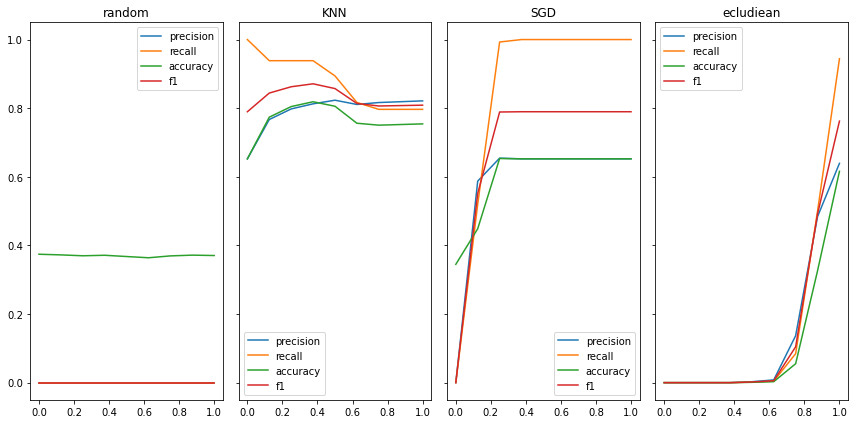

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,6), sharey='row')
ax[0].title.set_text('random')
ax[0] = df_rand.plot(ax=ax[0])
# ax[0].axvline(x=0.11, c="black")


ax[1].title.set_text('KNN')
ax[1] = df_knn.plot(ax=ax[1])
# ax[0].axvline(x=0.11, c="black")

ax[2].title.set_text('SGD')
ax[2] = df_sgd.plot(ax=ax[2])
# ax[1].axvline(x=0.11, c="black")


ax[3].title.set_text('ecludiean')
ax[3] = df_ecl.plot(ax=ax[3])
# ax[2].axvline(x=0.11, c="black")
fig.tight_layout()

plot the performance of the different models without shared y axis

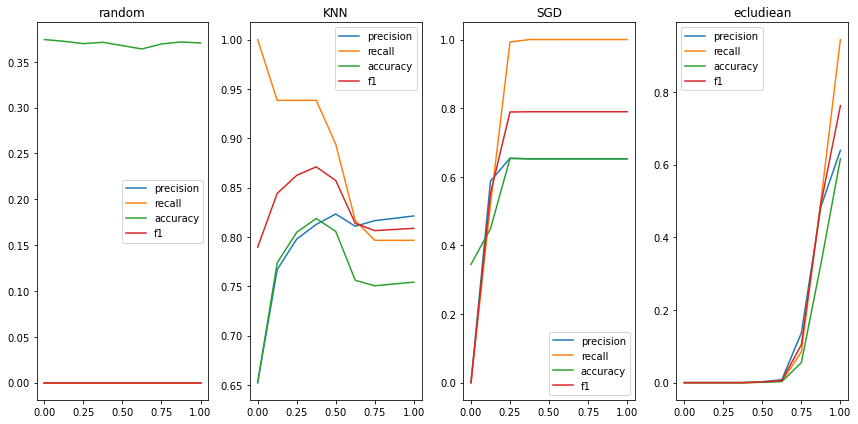

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,6))
ax[0].title.set_text('random')
ax[0] = df_rand.plot(ax=ax[0])
# ax[0].axvline(x=0.11, c="black")


ax[1].title.set_text('KNN')
ax[1] = df_knn.plot(ax=ax[1])
# ax[0].axvline(x=0.11, c="black")

ax[2].title.set_text('SGD')
ax[2] = df_sgd.plot(ax=ax[2])
# ax[1].axvline(x=0.11, c="black")


ax[3].title.set_text('ecludiean')
ax[3] = df_ecl.plot(ax=ax[3])
# ax[2].axvline(x=0.11, c="black")
fig.tight_layout()

save the evaluation as json 

In [50]:
import json
with open('FaceRecognition_evaluation.json', 'w', encoding='utf-8') as f:
    json.dump(pred, f, ensure_ascii=False, indent=4)

Next we could change the train test helper function in a way that would allow us to simulate different proportion of known and unknown data for the test dataset and even how many total observations we want to predict for

In [11]:
from math import floor, ceil

def split_data(arr, resolution="64", proportion_class=80, n=100, exclude_class ="Maureen_Leber", 
               ratio = 0.5, seed=42):
    # How many classes result in 80% of all classes
    random.seed(seed)
    X_tot,y_tot = arr[resolution]

    thr = int(proportion_class * len(Counter(y_tot)) /100)

    X_train = np.zeros(128)
    X_test = np.zeros(128)
    y_train = []
    y_test = []

    freq_classes = dict(Counter(y_tot))
    tr = sample(freq_classes.keys(),thr)
    te = list(set(y_tot)-set(tr))

    for c,v in freq_classes.items():    
        ind = y_tot.index(c)
        if c == exclude_class:
            continue
        elif c in tr:
            y_train += y_tot[ind:ind+v]
            X_train = np.vstack((X_train, X_tot[ind:ind+v,:]))
        elif c in te:
            y_test += y_tot[ind:ind+v]
            X_test = np.vstack((X_test, X_tot[ind:ind+v,:]))

    X_train = np.delete(X_train, (0), axis=0)
    X_test = np.delete(X_test, (0), axis=0)

    train_sub = sample(list(range(len(y_train))), floor(n * ratio))

    X_sub_train = X_train[train_sub,:].copy()
    y_sub_train = np.array(y_train)[train_sub].tolist() 

    test_sub = sample(list(range(len(y_test))), ceil((1-ratio)*n))

    X_sub_test = X_test[test_sub,:]
    y_sub_test = np.array(y_test)[test_sub].tolist()

    X_test = np.vstack((X_sub_train, X_sub_test))    
    y_test = y_sub_train + y_sub_test
    
    return X_train, y_train, X_test, y_test, y_sub_test    

In [18]:
arr = load_database()    
X_train, y_train, X_test, y_test, y_sub_test = split_data(arr, n=10, ratio= 0.95, seed=42)
pred =  clf_predict(X_test,y_test,y_sub_test, clf = ["knn", "euclidean", "sgd", "random"]) 


[['Ifrahim' 'Ifrahim' 'Ifrahim']]
[[1. 0. 0.]]
[7.77676768 7.77676768 7.77676768]
[[7.77676768 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 26.10it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Elvira_Bruno' 'Elvira_Bruno' 'Elvira_Bruno']]
[[1. 1. 1.]]
[0.49428608 0.49428608 0.49428608]
[[0.49428608 0.49428608 0.49428608]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 25.35it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Caren_Bruno' 'Caren_Bruno' 'Caren_Bruno']]
[[4.74531328e+07 2.44880451e+00 2.43067830e+00]]
[0.04587161 0.04587161 0.04587161]
[[2.17675181e+06 1.12330616e-01 1.11499137e-01]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.39it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1. 1. 1.]]
[0.06363967 0.06363967 0.06363967]
[[0.06363967 0.06363967 0.06363967]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.48it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Nabil_Benzaid' 'Nabil_Benzaid' 'Nabil_Benzaid']]
[[1. 1. 0.]]
[3.88838384 3.88838384 3.88838384]
[[3.88838384 3.88838384 0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 23.66it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Esther_Olifant' 'Esther_Olifant' 'Esther_Olifant']]
[[1. 1. 1.]]
[0.48004739 0.48004739 0.48004739]
[[0.48004739 0.48004739 0.48004739]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.74it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Salvatore_Bruno' 'Salvatore_Bruno' 'Salvatore_Bruno']]
[[1. 0. 0.]]
[0.62048678 0.62048678 0.62048678]
[[0.62048678 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.34it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Salvatore_Bruno' 'Salvatore_Bruno' 'Salvatore_Bruno']]
[[1. 0. 0.]]
[0.62048678 0.62048678 0.62048678]
[[0.62048678 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.89it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Ret

[['Esther_Olifant' 'Esther_Olifant' 'Esther_Olifant']]
[[1. 0. 0.]]
[0.48004739 0.48004739 0.48004739]
[[0.48004739 0.         0.        ]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 23.56it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

[['Sandro_Bruno' 'Sandro_Bruno' 'Sandro_Bruno']]
[[1.05238235 1.05238235 1.03332792]]
[0.06363967 0.06363967 0.06363967]
[[0.06697327 0.06697327 0.06576065]]


  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 33%|███████████████                              | 3/9 [00:00<00:00, 24.38it/s]/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ip

In [19]:
perf_knn = {thr: performance(v, pr=False) for thr, v in pred["knn"].items()}
df_knn = pd.DataFrame(perf_knn).T
perf_sgd = {thr: performance(v, pr=False) for thr, v in pred["sgd"].items()}
df_sgd = pd.DataFrame(perf_sgd).T
perf_ecl = {thr: performance(v, pr=False) for thr, v in pred["ecl"].items()}
df_ecl = pd.DataFrame(perf_ecl).T
perf_rand = {thr: performance(v, pr=False) for thr, v in pred["rand"].items()}
df_rand = pd.DataFrame(perf_rand).T

9 0
1 0
8 0
0 1
5 0
0 1
5 0
0 1
3 0
0 1
3 0
0 1
3 0
0 1
3 0
0 1
3 0
0 1
0 0
0 1
division by zero
division by zero
division by zero
6 0
1 0
9 0
1 0
9 0
1 0
9 0
1 0
9 0
1 0
9 0
1 0
9 0
1 0
9 0
1 0
9 0
0 1
9 0
0 1
9 0
0 1
9 0
0 1
9 0
0 1
9 0
0 1
9 0
0 1
9 0
0 1
9 0
1 0
0 8
0 1
division by zero
float division by zero
0 8
0 1
division by zero
float division by zero
0 9
0 1
division by zero
float division by zero
0 9
0 1
division by zero
float division by zero
0 9
0 1
division by zero
float division by zero
0 8
0 1
division by zero
float division by zero
0 8
0 1
division by zero
float division by zero
0 5
0 1
division by zero
float division by zero
0 9
0 1
division by zero
float division by zero


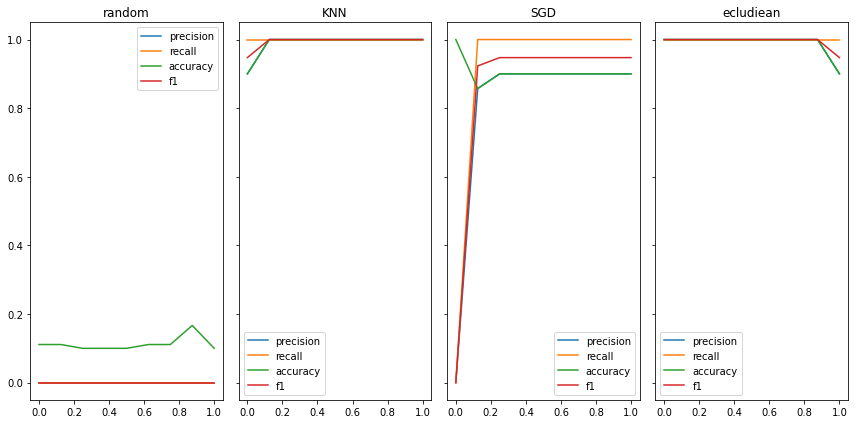

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,6), sharey='row')
ax[0].title.set_text('random')
ax[0] = df_rand.plot(ax=ax[0])
# ax[0].axvline(x=0.11, c="black")


ax[1].title.set_text('KNN')
ax[1] = df_knn.plot(ax=ax[1])
# ax[0].axvline(x=0.11, c="black")

ax[2].title.set_text('SGD')
ax[2] = df_sgd.plot(ax=ax[2])
# ax[1].axvline(x=0.11, c="black")


ax[3].title.set_text('ecludiean')
ax[3] = df_ecl.plot(ax=ax[3])
# ax[2].axvline(x=0.11, c="black")
fig.tight_layout()